***
***

<img width="220" align="right" alt="Screen Shot 2020-10-14 at 20 48 36" src="https://user-images.githubusercontent.com/8030363/96350526-7d09a680-1073-11eb-9e45-a510c496bcc1.png">


# OMOP2OBO

### *Ontologizing Health Systems Data at Scale: Making Translational Discovery a Reality*

<br>

**Author:** [TJCallahan](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=callahantiff@gmail.com)  
**GitHub Repository:** [OMOP2OBO](https://github.com/callahantiff/OMOP2OBO/wiki) ([`V1.0`](https://github.com/callahantiff/OMOP2OBO/wiki/v1.0))  
**Analysis Dates:** `10/16/2020`

<br>

***
***

### Notebook Objective   
The purpose of this notebook is to present the results for the preliminary manuscript describing the `OMOP2OBO` algorithm and mappings. For this analysis, each clinical concepts from several domains (i.e. Conditions, Drug Ingredients, and Measurements) will separately analyzed with respect to the specific Open Biomedical Ontologies (OBO) it was mapped to. The analysis is presented in the order of the mapping algorithm workflow, which is shown below. Additional information on each of the steps shown in this figure, with respect to the analyses performed in this notebook, are provided below. 

**This notebook presents results for the preliminary manuscript describing the `OMOP2OBO` algorithm and mappings.**

<img width="2000" alt="Screen Shot 2020-09-20 at 22 59 00" src="https://user-images.githubusercontent.com/8030363/96931469-99924e00-147a-11eb-9c19-fe5a95786772.png">


**Jupyter Notebooks:** [`omop2obo_manuscript_analyses.ipynb`](https://github.com/callahantiff/OMOP2OBO/tree/master/resources/analyses) 

- **Step 1: Concept Alignment:** This section describes the results generated from performing exact alignment between `OMOP` concept source codes and ontology concept database cross-references (i.e. dbXRefs) as well as `OMOP` concept labels and synonyms to ontology concept labels and synonyms. Done for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept- and ancestor-level. 


- **Step 2: Concept Embedding:** This section describes the results from creating embeddings using a Bag-of-Words + TF-IDF vector space model. This model was created using `OMOP` concept labels and synonyms and ontology concept labels and synonyms. To retrieve mappings from this model, a cosine similarity score was calculated between all clinical and ontology concepts. Only those mappings that were greater than a cut-off threshold (<u>></u>`0.25` for drug ingredients and medications and <u>></u>`0.20` for conditions) and within the top 75% of the distribution of scores were kept. This is performed for `Concepts used in Practice` and `Standard Concepts not used in Practice` and for data at the concept-level.


- **Step 3: Manual Annotation:** This section describes the results obtained from manual annotation. Performed only on `Concepts used in Practice` at the concept-level.


- **Step 4: Final Mapping:** The final set of mappings will be presented. This will include descriptions of mappings by mapping category as well as what level (i.e. concept, ancestor) mappings were created.

<br> 

**Jupyter Notebooks:** [`omop2obo_mapping_validation.ipynb`](https://github.com/callahantiff/OMOP2OBO/tree/master/resources/analyses/omop2obo_mapping_validation.ipynb)   

- **Validation:** This section describes results from three different types of validation designed to assess the accuracy, generalizability, and consistency of the final mapping set.


***
## Table of Contents <a class="anchor" id="toc"></a>
***

This notebook divides the analysis into two components: (1) summarization of mapping results and (2) validation of mapping results. 

* [Ontology Data](#ontology-data)  
* [Mapping Results](#mapping-results)   

***
***

<br>

## Set-up Environment
***

In [1]:
# import needed libraries
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
import urllib.request
import warnings

from collections import Counter
from datetime import date, datetime
from itertools import combinations
from more_itertools import unique_everseen
from scipy.stats import chi2, chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests

from analytic_utils import *

# set time-stamped var for writing output to
date_today = '_' + datetime.strftime(datetime.strptime(str(date.today()), '%Y-%m-%d'), '%d%b%Y').upper()


### Data 

There are several data files needed for this analysis. Each needed data source is described in the table below and can be accessed directly from the [Wiki](https://github.com/callahantiff/OMOP2OBO/wiki/V1.0).   

Data | Data Type | Description | File  
:--: | :--: | :-- | --  
Conditions Clinical Data | `Mapping Data` | A `CSV` file containing clinical data from the OMOP Condition Occurrence table to use for mapping | `OMOP2OBO_2020_Conditions_Concepts_Merged_Oct2020.csv`  
Drug Exposire Ingredients Clinical Data | `Mapping Data` | A `CSV` file containing clinical data from the OMOP Drug Exposure table to use for mapping | `OMOP2OBO_2020_Medications_Concepts_Merged_Oct2020.csv`  
Measurements Clinical Data | `Mapping Data` | A `CSV` file containing clinical data from the OMOP Measurement table to use for mapping | `OMOP2OBO_2020_Measurements_Concepts_Merged.csv`  
Condition Concept Mappings | `Mapping Results` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Condition_Occurrence_Mapping_Full_Oct2020.xlsx`
Drug Ingredient Concept Mappings | `Mapping Results` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Drug_Exposure_Mapping_Full_Oct2020.xlsx`  
Measurement Concept Mappings | `Mapping Results` | An Excel workbook of Sheets storing different result sets:<br>(1) DbXRef_Mapping_Results;<br>(2) String_Mapping_Results;<br>(3) Similarity_Mapping_results;<br>(4) Aggregated_Mapping_Results | `Measurement_Mapping_Subset_Oct2020.xlsx`  
Clinical Concept Frequency | `Mapping Data` | A `csv` file containing metadata for the condition, drug_exposure, and measurement codes utilized in practice. The sheet includes data describing the number of visits and people that have utilized each concept as well as the total number of times the concept was used in practice | `OMOP2OBO_2020_COMOP2OBO_Coverage_Counts.csv` 
Ontology Metadata Dictionary | `Ontology Data` | A pickled dictionary that contains a separate dictionary for each ontology, where the inner keys of the dictionaries for each ontology contains information on: labels, definitions, synonyms, synonym types, and dbXRefs | `master_ontology_dictionary.pickle`  

<br>

*NOTE.* All of the `Mapping Data` and `Ontology Data` are available directly for download via (Zenodo)[]. The `Clinical Concept Frequency` contains some private institutional data and thus are not publicly available at this time. If you are interested in any of these data sources, please email Tiffany Callahan (`callahantiff@gmail.com`).

### Global Variables

In [5]:
### GLOBAL URLS FOR DATA
### clinical data to use for mapping
conditions = '<<file_path>>'
medications = '<<file_path>>'
measurments = '<<file_path>>'

### mapping data
conds_mapping_url = '<<>URL>>'
meds_mapping_url = '<<>URL>>'
labs_mapping_url = '<<>URL>>'

# ontology data\n",
processed_ontology_data = '<<>URL>>'
ontology_metadata = ['label', 'dbxref', 'synonym', 'synonym_type']

# concept frequencies
chco_concept_freq_url = '<<>URL>>'

###  ontology data
processed_ontology_data = '<<>URL>>'


In [3]:
### GLOBAL VARIABLES AND SETTINGS
# create global variables to store ontologies by clinical domain
condition_onts = ['HP', 'MONDO']  
ingredient_onts = ['CHEBI', 'PR', 'NCBITAXON', 'VO']
measurement_onts = ['HP', 'CHEBI', 'CL', 'UBERON', 'PR', 'NCBITAXON']  

# silencing warnings
warnings.filterwarnings('ignore')

# set plotting arguments
%matplotlib inline
plt.style.use('ggplot')

# color palette
my_pal = {'HP': 'mediumpurple',
          'MONDO': 'cadetblue',
          'UBERON': 'gold',
          'VO': 'rebeccapurple',
          'PRO': 'darkorange',
          'NCBITaxon': 'mediumturquoise',
          'CL': 'hotpink',
          'CHEBI': 'limegreen'}


<br>

***
## Ontology Data <a class="anchor" id="ontology-data"></a>
***  

This section is designed to provide an overview of the ontology data available when creating mappings. Each ontologies, shown below by clinical domain, were downloaded on `September 14, 2020`. For each ontology, only current (non-deprecated) classes were considered were eligible for mapping. For all current classes, each ontology was queried to obtain class universal resource identifiers (URI), labels, definitions, synonyms (including synonym type), and database cross-references (dbXRefs).  

Ontology | Clinical Domain 
:--: | :--:
[Human Phenotype Ontology (hp)](http://purl.obolibrary.org/obo/hp.owl) | Conditions; Measurements      
[Mondo Disease Ontology (mondo)](http://purl.obolibrary.org/obo/mondo.owl) | Conditions      
[Cell Ontology (cl)](http://purl.obolibrary.org/obo/cl.owl) | Measurements        
[Chemical Entities of Biological Interest (chebi)](http://purl.obolibrary.org/obo/chebi.owl) | Drugs; Measurements           
[NCBI Organism Taxonomy (ncbitaxon)](http://purl.obolibrary.org/obo/ncbitaxon.owl) | Drugs; Measurements     
[Protein Ontology (pr)](http://purl.obolibrary.org/obo/pr.owl) | Drugs; Measurements        
[Uber Anatomy Ontology (uberon)](http://purl.obolibrary.org/obo/uberon/ext.owl) | Measurements       
[Vaccine Ontology (vo)](http://purl.obolibrary.org/obo/vo.owl) | Drugs  


In [4]:
# load ontology data
ont_data = pickle.load(urllib.request.urlopen(processed_ontology_data))

# filter and process ontology data
processed_ont_info = outputs_ontology_metadata(ont_data, list(ont_data.keys()), ontology_metadata)

NameError: name 'ontology_metadata' is not defined

#### Human Phenotype Ontology (HPO) 
***
The `HP` ontology contained `15,247` labeled classes, `19,569` dbXRefs, and `19,860` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [ ]:
hp_label, hp_dbxref = processed_ont_info['hp']['label'], processed_ont_info['hp']['dbxref']
hp_synonym, hp_synonym_type = processed_ont_info['hp']['synonym'], processed_ont_info['hp']['synonym_type']

print('There are {} HP class labels'.format(hp_label),
      '\nThere are {} HP class dbXRefs'.format(hp_dbxref),
      '\nThere are {} HP class synonyms of type: {}'.format(hp_synonym, hp_synonym_type))

#### Mondo Disease Ontology (MONDO)  
***
The `MONDO` ontology contained `22,288` labeled classes, `159,918` dbXRefs, and `98,181` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, `hasBroadSynonym`, and `excluded_synonym`.

In [ ]:
mondo_label, mondo_dbxref = processed_ont_info['mondo']['label'], processed_ont_info['mondo']['dbxref']
mondo_synonym, mondo_synonym_type = processed_ont_info['mondo']['synonym'], processed_ont_info['mondo']['synonym_type']

print('There are {} MONDO class labels'.format(mondo_label),
      '\nThere are {} MONDO class dbXRefs'.format(mondo_dbxref),
      '\nThere are {} MONDO class synonyms of type: {}'.format(mondo_synonym, mondo_synonym_type))

#### Chemical Entities of Biological Interest (CHEBI)  
***
The `CHEBI` ontology contained `126,169` labeled classes, `231,247` dbXRefs, and `269,798` synonyms of type `hasExactSynonym` and `hasRelatedSynonym`.

In [ ]:
chebi_label, chebi_dbxref = processed_ont_info['chebi']['label'], processed_ont_info['chebi']['dbxref']
chebi_synonym, chebi_synonym_type = processed_ont_info['chebi']['synonym'], processed_ont_info['chebi']['synonym_type']

print('There are {} CHEBI class labels'.format(chebi_label),
      '\nThere are {} CHEBI class dbXRefs'.format(chebi_dbxref),
      '\nThere are {} CHEBI class synonyms of type: {}'.format(chebi_synonym, chebi_synonym_type))

#### Cell Ontology (CL)  
***
The `CL` ontology contained `2,238` labeled classes, `1,376` dbXRefs, and `2,124` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [ ]:
cl_label, cl_dbxref = processed_ont_info['cl']['label'], processed_ont_info['cl']['dbxref']
cl_synonym, cl_synonym_type = processed_ont_info['cl']['synonym'], processed_ont_info['cl']['synonym_type']

print('There are {} CL class labels'.format(cl_label),
      '\nThere are {} CL class dbXRefs'.format(cl_dbxref),
      '\nThere are {} CL class synonyms of type: {}'.format(cl_synonym, cl_synonym_type))

#### NCBI Taxonomy (NCBITaxon)  
***
The `NCBITaxon` ontology contained `2,241,110` labeled classes, `18,426` dbXRefs, and `263,571` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, and `hasBroadSynonym`.

In [ ]:
ncbitaxon_label, ncbitaxon_dbxref = processed_ont_info['ncbitaxon']['label'], processed_ont_info['ncbitaxon']['dbxref']
ncbitaxon_synonym, ncbitaxon_synonym_type = processed_ont_info['ncbitaxon']['synonym'], processed_ont_info['ncbitaxon']['synonym_type']

print('There are {} NCBITaxon class labels'.format(ncbitaxon_label),
      '\nThere are {} NCBITaxon class dbXRefs'.format(ncbitaxon_dbxref),
      '\nThere are {} NCBITaxon class synonyms of type: {}'.format(ncbitaxon_synonym, ncbitaxon_synonym_type))

#### Vaccine Ontology (VO)
***
The `VO` ontology contained `5,789` labeled classes, `0` dbXRefs, and `6` synonyms of type `hasSynonym`.

In [ ]:
vo_label, vo_dbxref = processed_ont_info['vo']['label'], processed_ont_info['vo']['dbxref']
vo_synonym, vo_synonym_type = processed_ont_info['vo']['synonym'], processed_ont_info['vo']['synonym_type']

print('There are {} VO class labels'.format(vo_label),
      '\nThere are {} VO class dbXRefs'.format(vo_dbxref),
      '\nThere are {} VO class synonyms of type: {}'.format(vo_synonym, vo_synonym_type))

#### Uber-Anatomy Ontology (UBERON)  
***
The `UBERON` ontology contained `13,898` labeled classes, `51,322` dbXRefs, and `36,771` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [ ]:
uberon_label, uberon_dbxref = processed_ont_info['uberon']['label'], processed_ont_info['uberon']['dbxref']
uberon_synonym, uberon_synonym_type = processed_ont_info['uberon']['synonym'], processed_ont_info['uberon']['synonym_type']

print('There are {} UBERON class labels'.format(uberon_label),
      '\nThere are {} UBERON class dbXRefs'.format(uberon_dbxref),
      '\nThere are {} UBERON class synonyms of type: {}'.format(uberon_synonym, uberon_synonym_type))

#### Protein Ontology (PRO)  
***
The `PR` ontology contained `215,624` labeled classes, `195,671` dbXRefs, and `590,190` synonyms of type `hasExactSynonym`, `hasRelatedSynonym`, `hasNarrowSynonym`, and `hasBroadSynonym`.

In [ ]:
pr_label, pr_dbxref = processed_ont_info['pr']['label'], processed_ont_info['pr']['dbxref']
pr_synonym, pr_synonym_type = processed_ont_info['pr']['synonym'], processed_ont_info['pr']['synonym_type']

print('There are {} PR class labels'.format(pr_label),
      '\nThere are {} PR class dbXRefs'.format(pr_dbxref),
      '\nThere are {} PR class synonyms of type: {}'.format(pr_synonym, pr_synonym_type))

#### ***Plot Metadata Attribute Counts by Ontology***

In [ ]:
# create grouped DataFrame
ont_list = list(unique_everseen(condition_onts + ingredient_onts + measurement_onts))
ontologies = [x for y in [[x] * 3 for x in ont_list] for x in y]
counts = [math.log10(hp_label), math.log10(hp_dbxref), math.log10(hp_synonym),
          math.log10(mondo_label), math.log10(mondo_dbxref), math.log10(mondo_synonym),
          math.log10(chebi_label), math.log10(chebi_dbxref), math.log10(chebi_synonym),
          math.log10(cl_label), math.log10(cl_dbxref), math.log10(cl_synonym),
          math.log10(ncbitaxon_label), math.log10(ncbitaxon_dbxref), math.log10(ncbitaxon_synonym),
          math.log10(vo_label), vo_dbxref, math.log10(vo_synonym),
          math.log10(uberon_label), math.log10(uberon_dbxref), math.log10(uberon_synonym),
          math.log10(pr_label), math.log10(pr_dbxref), math.log10(pr_synonym)]

ontology_counts = pd.DataFrame({'ontology': ontologies,
                                'metadata': ontology_metadata[:-1] * 8,
                                'counts': counts})

ontology_counts.head()

In [ ]:
# generate bar plot
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

g = sns.barplot(data=ontology_counts, x='ontology', y='counts', hue="metadata", edgecolor='black', linewidth=1)
# g = sns.barplot(data=ontology_counts, x='ontology', y='counts', hue="metadata",
#                 palette=sns.color_palette('gray', 4), edgecolor='black', linewidth=1)

# set plot label information
plt.ylim(0, 7.5)
plt.title('Ontology Mapping Metadata ', fontsize=20)
plt.xlabel('Ontology', fontsize=18)
plt.ylabel('Counts ($log_{10}$)', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(title='', fontsize=15, title_fontsize=14,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=3)

plt.show()


**Chi-Square Test**  
A Chi-Square test of independence was run to determine if the amount of metadata available differed by ontology. First, an omnibus test was run to determine whether there was a significant relationship between the metadata and ontologies. Results from this test (with Yate's correction) revealed a significant association between the ontology metadata and ontology type ($X^{2}(14)=2,664,853.817$, $p<0.0001$). In order to better understand these findings, post-hoc tests were run using a Bonferroni adjustment to correct for multiple comparisons. These tests confirmed all ontologies had significantly different distributions of metadata ($ps<0.0001$).


In [ ]:
# create grouped DataFrame
ontology_df = pd.DataFrame({'ontology': list(unique_everseen(condition_onts + ingredient_onts + measurement_onts)),
                            'label': [hp_label, mondo_label, chebi_label, cl_label, ncbitaxon_label, vo_label, uberon_label, pr_label],
                            'dbxref': [hp_dbxref, mondo_dbxref, chebi_dbxref, cl_dbxref, ncbitaxon_dbxref, vo_dbxref, uberon_dbxref, pr_dbxref],
                            'synonym': [hp_synonym, mondo_synonym, chebi_synonym, cl_synonym, ncbitaxon_synonym, vo_synonym, uberon_synonym, pr_synonym]})

ontology_df

In [ ]:
# reformat data so a contingency table can be created
# labels
ont_label = pd.DataFrame({'ontology': ['HP'] * hp_label + ['MONDO'] * mondo_label + ['CHEBI'] * chebi_label + ['CL'] * cl_label + ['NCBITaxon'] * ncbitaxon_label + ['VO'] * vo_label + ['UBERON'] * uberon_label + ['PR'] * pr_label,
                            'metadata': list(ont_data['hp']['label'].keys()) +
                                     list(ont_data['mondo']['label'].keys()) +
                                     list(ont_data['chebi']['label'].keys()) +
                                     list(ont_data['cl']['label'].keys()) +
                                     list(ont_data['ncbitaxon']['label'].keys()) +
                                     list(ont_data['vo']['label'].keys()) +
                                     list(ont_data['uberon']['label'].keys()) +
                                     list(ont_data['pr']['label'].keys())})
ont_label['metadata_type'] = ['label'] * len(ont_label)
ont_label.head()

# synonyms
ont_synonym = pd.DataFrame({'ontology': ['HP'] * hp_synonym + ['MONDO'] * mondo_synonym + ['CHEBI'] * chebi_synonym + ['CL'] * cl_synonym + ['NCBITaxon'] * ncbitaxon_synonym + ['VO'] * vo_synonym + ['UBERON'] * uberon_synonym + ['PR'] * pr_synonym,
                            'metadata': list(ont_data['hp']['synonym'].keys()) +
                                     list(ont_data['mondo']['synonym'].keys()) +
                                     list(ont_data['chebi']['synonym'].keys()) +
                                     list(ont_data['cl']['synonym'].keys()) +
                                     list(ont_data['ncbitaxon']['synonym'].keys()) +
                                     list(ont_data['vo']['synonym'].keys()) +
                                     list(ont_data['uberon']['synonym'].keys()) +
                                     list(ont_data['pr']['synonym'].keys())})
ont_synonym['metadata_type'] = ['synonym'] * len(ont_synonym)

# dbxref
ont_dbxref = pd.DataFrame({'ontology': ['HP'] * hp_dbxref + ['MONDO'] * mondo_dbxref + ['CHEBI'] * chebi_dbxref + ['CL'] * cl_dbxref + ['NCBITaxon'] * ncbitaxon_dbxref + ['VO'] * vo_dbxref + ['UBERON'] * uberon_dbxref + ['PR'] * pr_dbxref,
                            'metadata': list(ont_data['hp']['dbxref'].keys()) +
                                     list(ont_data['mondo']['dbxref'].keys()) +
                                     list(ont_data['chebi']['dbxref'].keys()) +
                                     list(ont_data['cl']['dbxref'].keys()) +
                                     list(ont_data['ncbitaxon']['dbxref'].keys()) +
                                     list(ont_data['vo']['dbxref'].keys()) +
                                     list(ont_data['uberon']['dbxref'].keys()) +
                                     list(ont_data['pr']['dbxref'].keys())})
ont_dbxref['metadata_type'] = ['dbxref'] * len(ont_dbxref)

# concatenate dfs
ontology_dfs = pd.concat([ont_label, ont_dbxref, ont_synonym])

ontology_dfs.head()

In [ ]:
# create and print contingency table
df = pd.crosstab(ontology_dfs['ontology'], ontology_dfs['metadata_type']) 
df


In [ ]:
# perform post hoc analysis adjusting applying multiple comparisons correction
# other correction types available: https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
result = chisq_and_posthoc_corrected(df, 'bonferroni')
result


***

**Click [here](#toc) to return to the Table of Contents**

***

<br>

***
## Mapping Results <a class="anchor" id="mapping-results"></a>
***  

**Repository Documentation:** [`clinical_data/README.md`](https://github.com/callahantiff/OMOP2OBO/tree/master/resources/clinical_data)  

This section provides an overview of the clinical data available for mapping. To create the mappings, clinical data was pulled in two waves from an OMOP (`v5.0`) PEDSNet (`v3.0`)-normalized instance of Children's Hospital of Colorado data ([`#15-0445`](https://www.dropbox.com/s/kn9n5lygo2fc5d6/Stamped_OMOP%20CDM%20COMIRB%20Protocol_v2_11.29.15.pdf?dl=1)). Additional detail regarding the data used for mapping will described as each domain is presented below. To help identify dbXRefs between the clinical concepts (from all clinical domains) and ontology concepts, the National of Library Medicine's Unified Medical Language System (UMLS) [MRCONSO](https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html) and [MRSTY](https://www.ncbi.nlm.nih.gov/books/NBK9685/table/ch03.Tf/) (`2020AA` version). Using these data requires a license agreement. This section is designed to provide an overview of the mapping results for each domain.

Results in this section are organized by clinical domain (i.e. Conditions, Drug Ingredients, and Measurements) and can be accessed using the following links:
  - [Conditions](#mapping-conditions)  
  - [Drug Ingredients](#mapping-drugs)  
  - [Measurements](#mapping-labs)  


### Conditions <a class="anchor" id="mapping-conditions"></a>
***

**Wiki Page:** [`Conditions`](https://github.com/callahantiff/OMOP2OBO/wiki/Conditions)  

**SQL Queries**  
- [x] Condition Concepts Used in Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_conditionoccurrence-sql))  
- [x] Standard SNOMED-CT Condition Concepts ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_conditionoccurrence_allstandardconcepts-sql))  

#### Data Description 
Clinical data was pulled in two waves. The first waved returned all condition concepts ids used at least 1 time in practice (`n=29,129`). The second wave returned all standard SNOMED-CT concept ids not used in practice (`n=109,719`). Once the `29,129` concepts used in practice were removed, there `80,590` were standard SNOMED-CT concepts that had not been used in practice.

For each wave, the datasets included data at the concept and ancestor level. Details included below:  

<table>
<tr>
<th align="center">CONCEPT LEVEL</th>  
<th align="center">CODES</th>
<th align="center">LABELS</th>
<th align="center">SYNONYMS</th>
<th align="center">VOCABULARIES</th>
</tr>  
<tr>
  <td colspan="5"><b>Concepts Used In Practice</b></td>
</tr>
<tr>
  <td rowspan="1"><i>Concept</i></td>
    <td>29,129</td>
    <td>29,129</td>
    <td>86,630</td>
    <td>SNOMED-CT</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>1,421,104</td>
    <td>1,389,525</td>
    <td>N/A</td>
    <td>SNOMED-CT<br>Cohort<br>MedDRA</td>
</tr>
<tr>
  <td colspan="5"><b>Standard SNOMED-CT Concepts Not Used In Practice</b></td>
</tr>
<tr>
  <td rowspan="1"><i>Concept</i></td>
    <td>80,590</td>
    <td>80,590</td>
    <td>194,264</td>
    <td>SNOMED-CT</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>3,458,072</td>
    <td>3,393,343</td>
    <td>N/A</td>
    <td>SNOMED-CT<br>Cohort<br>MedDRA</td>
</tr>
</table>   

<br><br>


#### Ontology Data 
`OMOP` Condition concept ids were mapped to:
- Phenotypes ([Human Phenotype Ontology (HP)](https://hpo.jax.org/))  
- Diseases ([MonDO Disease Ontology (MONDO)](http://mondo.monarchinitiative.org/))  


***
#### MAPPING DATA

In [5]:
# load clinical data
condition_data = pd.read_csv(conditions, sep=',', header=0)
condition_data.fillna('', inplace=True)

# view data
condition_data.head()


,CONCEPT_TYPE,CONCEPT_ID,STANDARD_CONCEPT,CONCEPT_LABEL,CONCEPT_SOURCE_CODE,CONCEPT_SOURCE_LABEL,CONCEPT_VOCAB,CONCEPT_VOCAB_VERSION,CONCEPT_SYNONYM,ANCESTOR_CONCEPT_ID,ANCESTOR_SOURCE_CODE,ANCESTOR_LABEL,ANCESTOR_VOCAB,ANCESTOR_VOCAB_VERSION
0,Standard Concept Not Used In Practice,42689791,S,Injury whilst bathing,snomed:1068371000000107,Injury whilst bathing,SNOMED,SnomedCT Release 20180131,Injury whilst bathing,42689791,snomed:1068371000000107,Injury whilst bathing,SNOMED,SnomedCT Release 20180131
1,Standard Concept Not Used In Practice,44790817,S,Patient transported by ambulance,snomed:243061000000105,Patient transported by ambulance,SNOMED,SnomedCT Release 20180131,Patient transported by ambulance,44790817,snomed:243061000000105,Patient transported by ambulance,SNOMED,SnomedCT Release 20180131
2,Standard Concept Not Used In Practice,44808793,S,Influenza vaccination second telephone invitation,snomed:860211000000105,Influenza vaccination second telephone invitation,SNOMED,SnomedCT Release 20180131,Influenza vaccination second telephone invitation,44808793,snomed:860211000000105,Influenza vaccination second telephone invitation,SNOMED,SnomedCT Release 20180131
3,Standard Concept Not Used In Practice,44802087,S,HLA (Human leucocyte antigen) B27 positive,snomed:511731000000100,HLA (Human leucocyte antigen) B27 positive,SNOMED,SnomedCT Release 20180131,HLA (Human leucocyte antigen) B27 positive,44802087,snomed:511731000000100,HLA (Human leucocyte antigen) B27 positive,SNOMED,SnomedCT Release 20180131
4,Standard Concept Not Used In Practice,44790816,S,Patient transported with baby in arms,snomed:243051000000107,Patient transported with baby in arms,SNOMED,SnomedCT Release 20180131,Patient transported with baby in arms,44790816,snomed:243051000000107,Patient transported with baby in arms,SNOMED,SnomedCT Release 20180131


In [6]:
# get stats
total_concepts = len(condition_data)

# split results by concept type (i.e. concepts used in practice, standard concepts)
cond_res = process_clinical_data(condition_data, 'CONCEPT_TYPE') 

# get concept_type results
practice_concepts = cond_res['Concept Used In Practice']
not_practice_concepts = cond_res['Standard Concept Not Used In Practice']


Processing Group: Concept Used In Practice
Processing Group: Standard Concept Not Used In Practice


*Concepts Used in Practice*

In [7]:
# print concepts used in practice data
res1 = 'There were {} concepts used in practice that could be mapped'.format(len(practice_concepts['grp_full_data']))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(practice_concepts['concept_src_code']),
                                                                                               len(practice_concepts['concept_src_label']),
                                                                                               len(practice_concepts['concept_synonym']))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(practice_concepts['concept_vocab'])
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(practice_concepts['anc_concept_id']),
                                                                                                    len(practice_concepts['anc_src_code']),
                                                                                                    len(practice_concepts['anc_label']))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5)


There were 29129 concepts used in practice that could be mapped 
At the concept-level, there were 29129 source codes, 29129 labels, and 86630 synonyms 
Concept-level data came from the following vocabularies: SNOMED 

At the ancestor-level, there were 1421104 concept ids, 1421104 source codes and 1389525 labels 
Ancestor-level data came from the following vocabularies: SNOMED, MedDRA, Cohort


*Standard SNOMED-CT Concepts Not Used in Practice*

In [8]:
# print standard concepts not used in practice data
res1 = 'There were {} standard concepts not used in practice that could be mapped'.format(len(not_practice_concepts['grp_full_data']))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(not_practice_concepts['concept_src_code']),
                                                                                               len(not_practice_concepts['concept_src_label']),
                                                                                               len(not_practice_concepts['concept_synonym']))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(not_practice_concepts['concept_vocab'])
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(not_practice_concepts['anc_concept_id']),
                                                                                                    len(not_practice_concepts['anc_src_code']),
                                                                                                    len(not_practice_concepts['anc_label']))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(not_practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5)


There were 80590 standard concepts not used in practice that could be mapped 
At the concept-level, there were 80590 source codes, 80590 labels, and 194264 synonyms 
Concept-level data came from the following vocabularies: SNOMED 

At the ancestor-level, there were 3458072 concept ids, 3458072 source codes and 3393343 labels 
Ancestor-level data came from the following vocabularies: SNOMED, MedDRA, Cohort


***

**Click [here](#mapping-conditions) to return to the Condition Occurrence Data section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

***

#### MAPPING RESULTS  <a class="anchor" id="cond-mapping-results"></a>
- [Database Cross-Reference](#cond-dbxref)  
- [Exact String Alignment](#cond-string)  
- [Cosine Similarity](#cond-cosine)   
- [Final Mapping Results](#cond-fullmapres)

***

#### Database Cross-Reference  <a class="anchor" id="cond-dbxref"></a>  
- [Human Phenotype Ontology](#dbxref-hpo)   
- [Mondo Ontology](#dbxref-mondo)  


In [9]:
# load results from dbxref alignment
cond_dbxref = pd.read_excel(conds_mapping_url, sheet_name='DbXRef_Mapping_Results', sep=',', header=0)
cond_dbxref.fillna('', inplace=True)

# view data
cond_dbxref.head(n=5)


,CONCEPT_ID,CONCEPT_TYPE,CONCEPT_LABEL,CONCEPT_DBXREF_HP_URI,CONCEPT_DBXREF_HP_LABEL,CONCEPT_DBXREF_HP_EVIDENCE,ANCESTOR_DBXREF_HP_URI,ANCESTOR_DBXREF_HP_LABEL,ANCESTOR_DBXREF_HP_EVIDENCE,CONCEPT_DBXREF_MONDO_URI,CONCEPT_DBXREF_MONDO_LABEL,CONCEPT_DBXREF_MONDO_EVIDENCE,ANCESTOR_DBXREF_MONDO_URI,ANCESTOR_DBXREF_MONDO_LABEL,ANCESTOR_DBXREF_MONDO_EVIDENCE
0,22274,Concept Used In Practice,Neoplasm of uncertain behavior of larynx,,,,HP_0012288 | HP_0100606 | HP_0100605 | HP_0002...,neoplasm of head and neck | neoplasm of the re...,ANCESTOR_DBXREF_snomed:255055008 | ANCESTOR_DB...,,,,MONDO_0000001 | MONDO_0021199 | MONDO_0024505 ...,disease or disorder | disease by anatomical sy...,ANCESTOR_DBXREF_snomed:64572001 | ANCESTOR_DBX...
1,22281,Concept Used In Practice,Hb SS disease,,,,HP_0001903 | HP_0002664 | HP_0010566 | HP_0001...,anemia | neoplasm | hamartoma | abnormality of...,ANCESTOR_DBXREF_snomed:271737000 | ANCESTOR_DB...,,,,MONDO_0000001 | MONDO_0021199 | MONDO_0024505 ...,disease or disorder | disease by anatomical sy...,ANCESTOR_DBXREF_snomed:64572001 | ANCESTOR_DBX...
2,22288,Concept Used In Practice,Hereditary elliptocytosis,HP_0004445,elliptocytosis,CONCEPT_DBXREF_snomed:191169008 | CONCEPT_DBXR...,HP_0004445 | HP_0001871 | HP_0001877,elliptocytosis | abnormality of blood and bloo...,ANCESTOR_DBXREF_snomed:191169008 | ANCESTOR_DB...,MONDO_0008165,southeast asian ovalocytosis,CONCEPT_DBXREF_snomed:191169008,MONDO_0000001 | MONDO_0021199 | MONDO_0024505 ...,disease or disorder | disease by anatomical sy...,ANCESTOR_DBXREF_snomed:64572001 | ANCESTOR_DBX...
3,22340,Concept Used In Practice,Esophageal varices without bleeding,,,,HP_0001626 | HP_0002619 | HP_0002040 | HP_0011024,abnormality of the cardiovascular system | var...,ANCESTOR_DBXREF_snomed:49601007 | ANCESTOR_DBX...,MONDO_0021644,esophageal varices without bleeding,CONCEPT_DBXREF_snomed:14223005,MONDO_0000001 | MONDO_0021199 | MONDO_0024505 ...,disease or disorder | disease by anatomical sy...,ANCESTOR_DBXREF_snomed:64572001 | ANCESTOR_DBX...
4,22350,Concept Used In Practice,Edema of larynx,HP_0012027,laryngeal edema,CONCEPT_DBXREF_snomed:51599000 | CONCEPT_DBXRE...,HP_0000969 | HP_0012027 | HP_0002094 | HP_0002...,edema | laryngeal edema | dyspnea | respirator...,ANCESTOR_DBXREF_snomed:267038008 | ANCESTOR_DB...,,,,MONDO_0000001 | MONDO_0021199 | MONDO_0024505 ...,disease or disorder | disease by anatomical sy...,ANCESTOR_DBXREF_snomed:64572001 | ANCESTOR_DBX...


In [10]:
# get processed data for each ontology
cond_dbxref_results = process_mapping_results(cond_dbxref, condition_onts, 'CONCEPT_TYPE', 'DBXREF')

# re-group by ontology
cond_dbxref_hp = cond_dbxref_results['HP']
cond_dbxref_mondo = cond_dbxref_results['MONDO']


Processing Ontology: HP
Processing Ontology: MONDO


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="dbxref-hpo"></a>    
Summarizing the results shown below, there were a total of `70,627` `OMOP` concepts that mapped to at least 1 `HP` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=22,796`)  
  - `3,238` `OMOP` concepts mapped at the concept level to `3,414` ontology concepts (`2,764` unique ontology concepts)  
  - `22,796` `OMOP` concepts mapped at the ancestor level to `83,033` ontology concepts (`2,921` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts Not Used in Practice (`n=47,831`)  
  - `1,005` `OMOP` concepts mapped at the concept level to `1,022` ontology concepts (`953` unique ontology concepts) 
  - `47,831` `OMOP` concepts mapped at the ancestor level to `183,193` ontology concepts (`2,821` unique ontology concepts)

In [11]:
print('{} OMOP concepts were mapped to at least 1 HP concept using DbXRefs'.format(len(cond_dbxref_hp['ont_data'])))

70627 OMOP concepts were mapped to at least 1 HP concept using DbXRefs


*Concepts Used in Practice*

In [12]:
# process data
cond_hp_dbxref_prac = cond_dbxref_hp['Concept Used In Practice']

prac = '{} Concepts used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_dbxref_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_prac['concepts'][0]),
                                                                                                                                      len(cond_hp_dbxref_prac['concepts'][1]),
                                                                                                                                      len(set(cond_hp_dbxref_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_prac['ancestors'][0]),
                                                                                                                                        len(cond_hp_dbxref_prac['ancestors'][1]),
                                                                                                                                        len(set(cond_hp_dbxref_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


22796 Concepts used in Clinical Practice mapped to at least 1 Ontology concept 
  - 3238 concepts mapped at the concept level to 3414 total ontology concepts (2764 unique) 
  - 22796 concepts mapped at the ancestor level to 83033 total ontology concepts (2921 unique)


*Standard SNOMED-CT Concepts Not Used in Practice*

In [13]:
# process data
cond_hp_dbxref_stnd = cond_dbxref_hp['Standard Concept Not Used In Practice']

stnd = '{} Standard SNOMED-CT concepts mapped to at least 1 Ontology concept'.format(len(cond_hp_dbxref_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_stnd['concepts'][0]),
                                                                                                                               len(cond_hp_dbxref_stnd['concepts'][1]),
                                                                                                                               len(set(cond_hp_dbxref_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_dbxref_stnd['ancestors'][0]),
                                                                                                                                 len(cond_hp_dbxref_stnd['ancestors'][1]),
                                                                                                                                 len(set(cond_hp_dbxref_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


47831 Standard SNOMED-CT concepts mapped to at least 1 Ontology concept 
  - 1005 concepts mapped at the concept level to 1022 total ontology concepts (953 unique) 
  - 47831 concepts mapped at the ancestor level to 183193 total ontology concepts (2821 unique)


<br>

***Mondo Disease Ontology Results*** <a class="anchor" id="dbxref-mondo"></a>     
Summarizing the results shown below, there were a total of `79,820` `OMOP` concepts that mapped to at least 1 `MONDO` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=24,511`)  
  - `4,541` `OMOP` concepts mapped at the concept level to `4,541` ontology concepts (`4,508` unique ontology concepts)  
  - `24,511` `OMOP` concepts mapped at the ancestor level to `196,580` ontology concepts (`5,017` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts Not Used in Practice  (`n=55,309`)  
  - `4,038` `OMOP` concepts mapped at the concept level to `4,038` ontology concepts (`4,031` unique ontology concepts) 
  - `55,309` `OMOP` concepts mapped at the ancestor level to `436,195` ontology concepts (`6,985` unique ontology concepts)  

In [14]:
print('{} OMOP concepts were mapped to at least 1 MONDO concept using DbXRefs'.format(len(cond_dbxref_mondo['ont_data'])))

79820 OMOP concepts were mapped to at least 1 MONDO concept using DbXRefs


*Concepts Used in Practice*

In [15]:
# process data
cond_mondo_dbxref_prac = cond_dbxref_mondo['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_mondo_dbxref_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_prac['concepts'][0]),
                                                                                                            len(cond_mondo_dbxref_prac['concepts'][1]),
                                                                                                            len(set(cond_mondo_dbxref_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_prac['ancestors'][0]),
                                                                                                              len(cond_mondo_dbxref_prac['ancestors'][1]),
                                                                                                              len(set(cond_mondo_dbxref_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


24511 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 4541 concepts mapped at the concept level to 4541 total ontology concepts (4508 unique) 
  - 24511 concepts mapped at the ancestor level to 196580 total ontology concepts (5017 unique)


*Standard SNOMED-CT Concepts*

In [16]:
# process data
cond_mondo_dbxref_stnd = cond_dbxref_mondo['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard SNOMED-CT Concepts Not Used in Practice mapped to at least 1 Ontology concept'.format(len(cond_mondo_dbxref_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_stnd['concepts'][0]),
                                                                                                            len(cond_mondo_dbxref_stnd['concepts'][1]),
                                                                                                            len(set(cond_mondo_dbxref_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_dbxref_stnd['ancestors'][0]),
                                                                                                              len(cond_mondo_dbxref_stnd['ancestors'][1]),
                                                                                                              len(set(cond_mondo_dbxref_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


55309 Standard SNOMED-CT Concepts Not Used in Practice mapped to at least 1 Ontology concept 
  - 4038 concepts mapped at the concept level to 4038 total ontology concepts (4031 unique) 
  - 55309 concepts mapped at the ancestor level to 436195 total ontology concepts (6985 unique)


***

**Click [here](#cond-mapping-results) to return to the Condition Occurrence section**  

***

<br>

#### Exact String Alignment  <a class="anchor" id="cond-string"></a>  
***

- [Human Phenotype Ontology](#string-hpo)   
- [Mondo Ontology](#string-mondo)   


In [17]:
# load results from exact string alignment
cond_exact_string = pd.read_excel(conds_mapping_url, sheet_name='String_Mapping_Results', sep=',', header=0)
cond_exact_string.fillna('', inplace=True)

# view data
cond_exact_string.head(n=5)


,CONCEPT_ID,CONCEPT_TYPE,CONCEPT_LABEL,CONCEPT_STR_HP_URI,CONCEPT_STR_HP_LABEL,CONCEPT_STR_HP_EVIDENCE,ANCESTOR_STR_HP_URI,ANCESTOR_STR_HP_LABEL,ANCESTOR_STR_HP_EVIDENCE,CONCEPT_STR_MONDO_URI,CONCEPT_STR_MONDO_LABEL,CONCEPT_STR_MONDO_EVIDENCE,ANCESTOR_STR_MONDO_URI,ANCESTOR_STR_MONDO_LABEL,ANCESTOR_STR_MONDO_EVIDENCE
0,9176,Standard Concept Not Used In Practice,"Patient status determination, deceased",,,,,,,,,,,,
1,22274,Concept Used In Practice,Neoplasm of uncertain behavior of larynx,,,,HP_0002664 | HP_0012288 | HP_0002094,neoplasm | neoplasm of head and neck | dyspnea,ANCESTOR_LABEL:neoplasm | ANCESTOR_LABEL:neopl...,,,,MONDO_0020641 | MONDO_0021351 | MONDO_0021071 ...,respiratory tract neoplasm | neoplasm of neck ...,ANCESTOR_LABEL:respiratory_tract_neoplasm | AN...
2,22281,Concept Used In Practice,Hb SS disease,,,,HP_0010566 | HP_0001903,hamartoma | anemia,ANCESTOR_LABEL:hamartoma | ANCESTOR_LABEL:anem...,MONDO_0011382,sickle cell anemia,CONCEPT_SYNONYM:sickle_cell_anemia | CONCEPT_S...,MONDO_0044348 | MONDO_0000001 | MONDO_0024505 ...,hemoglobinopathy | disease or disorder | disor...,ANCESTOR_LABEL:hemoglobinopathy | ANCESTOR_LAB...
3,22288,Concept Used In Practice,Hereditary elliptocytosis,HP_0004445,elliptocytosis,CONCEPT_SOURCE_LABEL:hereditary_elliptocytosis...,HP_0004445,elliptocytosis,ANCESTOR_LABEL:elliptocytosis | ANCESTOR_LABEL...,MONDO_0017319 | MONDO_0008165,hereditary elliptocytosis | southeast asian ov...,CONCEPT_SOURCE_LABEL:hereditary_elliptocytosis...,MONDO_0017319 | MONDO_0000001 | MONDO_0024505 ...,hereditary elliptocytosis | disease or disorde...,ANCESTOR_LABEL:hereditary_elliptocytosis | ANC...
4,22340,Concept Used In Practice,Esophageal varices without bleeding,,,,HP_0002040,esophageal varix,ANCESTOR_LABEL:esophageal_varices,MONDO_0021644,esophageal varices without bleeding,CONCEPT_SOURCE_LABEL:esophageal_varices_withou...,MONDO_0001221 | MONDO_0021644 | MONDO_0000001 ...,esophageal varices | esophageal varices withou...,ANCESTOR_LABEL:esophageal_varices | ANCESTOR_L...


In [18]:
# get processed data for each ontology
cond_exact_string_results = process_mapping_results(cond_exact_string, condition_onts, 'CONCEPT_TYPE', 'STR')

# re-group by ontology
cond_exact_string_hp = cond_exact_string_results['HP']
cond_exact_string_mondo = cond_exact_string_results['MONDO']


Processing Ontology: HP
Processing Ontology: MONDO


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="string-hpo"></a>    
Summarizing the results shown below, there were a total of `63,707` `OMOP` concepts that mapped to at least 1 `HP` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=19,906`)  
  - `2,767` `OMOP` concepts mapped at the concept level to `2,860` ontology concepts (`2,623` unique ontology concepts)  
  - `19,790` `OMOP` concepts mapped at the ancestor level to `40,182` ontology concepts (`2,367` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts Not Used in Practice (`n=43,801`)  
  - `700` `OMOP` concepts mapped at the concept level to `702` ontology concepts (`678` unique ontology concepts) 
  - `43,767` `OMOP` concepts mapped at the ancestor level to `89,599` ontology concepts (`2,259` unique ontology concepts)

In [19]:
print('{} OMOP concepts were mapped to at least 1 HP concept using exact string alignment'.format(len(cond_exact_string_hp['ont_data'])))


63707 OMOP concepts were mapped to at least 1 HP concept using exact string alignment


*Concepts Used in Practice*

In [20]:
# process data
cond_hp_exact_string_prac = cond_exact_string_hp['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_prac['concepts'][0]),
                                                                                                            len(cond_hp_exact_string_prac['concepts'][1]),
                                                                                                            len(set(cond_hp_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_prac['ancestors'][0]),
                                                                                                              len(cond_hp_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(cond_hp_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


19906 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 2767 concepts mapped at the concept level to 2860 total ontology concepts (2623 unique) 
  - 19790 concepts mapped at the ancestor level to 40182 total ontology concepts (2367 unique)


*Standard SNOMED-CT Concepts Not Used in Practice*

In [21]:
# process data
cond_hp_exact_string_stnd = cond_exact_string_hp['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard SNOMED-CT Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd['concepts'][0]),
                                                                                                            len(cond_hp_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(cond_hp_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd['ancestors'][0]),
                                                                                                              len(cond_hp_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(cond_hp_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


43801 Standard SNOMED-CT Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 700 concepts mapped at the concept level to 702 total ontology concepts (678 unique) 
  - 43767 concepts mapped at the ancestor level to 89599 total ontology concepts (2259 unique)


<br>

***MONDO Disease Ontology Results***  <a class="anchor" id="string-mondo"></a>   
Summarizing the results shown below, there were a total of `88,103` `OMOP` concepts that mapped to at least 1 `MONDO` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=26,084`)  
  - `5,404` `OMOP` concepts mapped at the concept level to `5,970` ontology concepts (`5,051` unique ontology concepts)  
  - `26,070` `OMOP` concepts mapped at the ancestor level to `199,224` ontology concepts (`4,942` unique ontology concepts)  
  

- Standard SNOMED-CT Concepts Not Used in Practice (`n=62,019`)  
  - `4,086` `OMOP` concepts mapped at the concept level to `4,317` ontology concepts (`3,973` unique ontology concepts) 
  - `62,015` `OMOP` concepts mapped at the ancestor level to `451,520` ontology concepts (`6,227` unique ontology concepts)

In [22]:
print('{} OMOP concepts were mapped to at least 1 MONDO concept using exact string alignment'.format(len(cond_exact_string_mondo['ont_data'])))


88103 OMOP concepts were mapped to at least 1 MONDO concept using exact string alignment


*Concepts Used in Practice*

In [23]:
# process data
cond_mondo_exact_string_prac = cond_exact_string_mondo['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_mondo_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_prac['concepts'][0]),
                                                                                                            len(cond_mondo_exact_string_prac['concepts'][1]),
                                                                                                            len(set(cond_mondo_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_prac['ancestors'][0]),
                                                                                                              len(cond_mondo_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(cond_mondo_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


26084 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 5404 concepts mapped at the concept level to 5970 total ontology concepts (5051 unique) 
  - 26070 concepts mapped at the ancestor level to 199224 total ontology concepts (4942 unique)


*Standard SNOMED-CT Concepts Not Used in Practice*

In [24]:
# process data
cond_mondo_exact_string_stnd = cond_exact_string_mondo['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard SNOMED-CT Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_mondo_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_stnd['concepts'][0]),
                                                                                                            len(cond_mondo_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(cond_mondo_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_mondo_exact_string_stnd['ancestors'][0]),
                                                                                                              len(cond_mondo_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(cond_mondo_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


62019 Standard SNOMED-CT Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 4086 concepts mapped at the concept level to 4317 total ontology concepts (3973 unique) 
  - 62015 concepts mapped at the ancestor level to 451520 total ontology concepts (6227 unique)


***

**Click [here](#cond-mapping-results) to return to the Condition Occurrence section**  

***

#### Cosine Similarity  <a class="anchor" id="cond-cosine"></a>  

***

- [Human Phenotype Ontology](#cosine-hpo)   
- [Mondo Ontology](#cosine-mondo)  

In [25]:
# load results from cosine similarity alignment
cond_similarity = pd.read_excel(conds_mapping_url, sheet_name='Similarity_Mapping_Results', sep=',', header=0)
cond_similarity.fillna('', inplace=True)

# view data
cond_similarity.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_SIM_HP_URI,CONCEPT_SIM_HP_LABEL,CONCEPT_SIM_HP_EVIDENCE,CONCEPT_SIM_MONDO_URI,CONCEPT_SIM_MONDO_LABEL,CONCEPT_SIM_MONDO_EVIDENCE
0,Standard Concept Not Used In Practice,9176,"Patient status determination, deceased",HP_0000448,prominent nose,HP_0000448_0.201,,,
1,Concept Used In Practice,22274,Neoplasm of uncertain behavior of larynx,HP_0100605,neoplasm of the larynx,HP_0100605_0.225,MONDO_0021071 | MONDO_0002354,laryngeal neoplasm | benign laryngeal neoplasm,MONDO_0021071_0.225 | MONDO_0002354_0.225
2,Concept Used In Practice,22281,Hb SS disease,HP_0001903 | HP_0001900,anemia | increased hemoglobin,HP_0001903_0.347 | HP_0001900_0.229,MONDO_0011382 | MONDO_0010434 | MONDO_0007736,sickle cell anemia | synovial sarcoma (disease...,MONDO_0011382_1.0 | MONDO_0010434_0.512 | MOND...
3,Concept Used In Practice,22288,Hereditary elliptocytosis,HP_0004445,elliptocytosis,HP_0004445_1.0,MONDO_0017319 | MONDO_0008165 | MONDO_0007533,hereditary elliptocytosis | southeast asian ov...,MONDO_0017319_1.0 | MONDO_0008165_1.0 | MONDO_...
4,Concept Used In Practice,22340,Esophageal varices without bleeding,HP_0002040,esophageal varix,HP_0002040_0.535,MONDO_0021644 | MONDO_0001221,esophageal varices without bleeding | esophage...,MONDO_0021644_1.0 | MONDO_0001221_0.552


In [26]:
# get processed data for each ontology
cond_sim_results = process_mapping_results(cond_similarity, condition_onts, 'CONCEPT_TYPE', 'SIM')

# re-group by ontology
cond_sim_hp = cond_sim_results['HP']
cond_sim_mondo = cond_sim_results['MONDO']


Processing Ontology: HP
Processing Ontology: MONDO


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="cosine-hpo"></a>    
Summarizing the results shown below, there were a total of `61,645` `OMOP` concepts that mapped to at least 1 `HP` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `20,938` `OMOP` concepts mapped at the concept level to `26,172` ontology concepts (`5,918` unique ontology concepts)  
  - The median similarity score was `0.395` (min: `0.2`, max: `1.0`)  
  

- Standard SNOMED-CT Concepts Not Used in Practice 
  - `40,707` `OMOP` concepts mapped at the concept level to `46,387` ontology concepts (`6,787` unique ontology concepts) 
  - The median similarity score was `0.327` (min: `0.2`, max: `1.0`)  


In [27]:
print('{} OMOP concepts were mapped to at least 1 HP concept using cosine similarity'.format(len(cond_sim_hp['ont_data'])))


61645 OMOP concepts were mapped to at least 1 HP concept using cosine similarity


*Concepts Used in Practice*

In [28]:
# process data
cond_hp_sim_prac = cond_sim_hp['Concept Used In Practice']

# obtain ontology concept lists
cond_hp_similarity_prac = [x for y in list(cond_hp_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
cond_hp_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(cond_hp_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity'.format(len(cond_hp_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(cond_hp_similarity_prac), len(set(cond_hp_similarity_prac)))

print(sim_concept, sim_concept1)


20938 OMOP Concepts Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity 
Concepts mapped to 26172 total ontology concepts (5918 unique)


In [29]:
min_score = min(cond_hp_similarity_prac_scores)
max_score = max(cond_hp_similarity_prac_scores)
median_score = statistics.median(cond_hp_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.395 (min: 0.2, max: 1.0)


*Standard SNOMED-CT Concepts Not Used in Practice*

In [30]:
# process data
cond_hp_sim_stnd = cond_sim_hp['Standard Concept Not Used In Practice']

# obtain ontology concept lists
cond_hp_similarity_stnd = [x for y in list(cond_hp_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
cond_hp_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(cond_hp_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity'.format(len(cond_hp_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(cond_hp_similarity_stnd), len(set(cond_hp_similarity_stnd)))

print(sim_concept, sim_concept1)


40707 OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity 
Concepts mapped to 46387 total ontology concepts (6787 unique)


In [31]:
min_score = min(cond_hp_similarity_stnd_scores)
max_score = max(cond_hp_similarity_stnd_scores)
median_score = statistics.median(cond_hp_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.327 (min: 0.2, max: 1.0)


<br>

***Mondo Disease Ontology Results*** <a class="anchor" id="cosine-mondo"></a>    
Summarizing the results shown below, there were a total of `73,375` `OMOP` concepts that mapped to at least 1 `MONDO` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `23,246` `OMOP` concepts mapped at the concept level to `36,021` ontology concepts (`8,852` unique ontology concepts)  
  - The median similarity score was `0.477` (min: `0.2`, max: `1.0`)  
  

- Standard SNOMED-CT Concepts Not Used in Practice    
  - `50,129` `OMOP` concepts mapped at the concept level to `69,095` ontology concepts (`11,441` unique ontology concepts) 
  - The median similarity score was `0.381` (min: `0.2`, max: `1.0`)  


In [32]:
print('{} OMOP concepts were mapped to at least 1 MONDO concept using cosine similarity'.format(len(cond_sim_mondo['ont_data'])))


73375 OMOP concepts were mapped to at least 1 MONDO concept using cosine similarity


*Concepts Used in Practice*

In [33]:
# process data
cond_mondo_sim_prac = cond_sim_mondo['Concept Used In Practice']

# obtain ontology concept lists
cond_mondo_similarity_prac = [x for y in list(cond_mondo_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
cond_mondo_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(cond_mondo_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 MONDO concept using cosine similarity'.format(len(cond_mondo_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(cond_mondo_similarity_prac), len(set(cond_mondo_similarity_prac)))

print(sim_concept, sim_concept1)


23246 OMOP Concepts Used in Clinical Practice were mapped to at least 1 MONDO concept using cosine similarity 
Concepts mapped to 36021 total ontology concepts (8852 unique)


In [34]:
min_score = min(cond_mondo_similarity_prac_scores)
max_score = max(cond_mondo_similarity_prac_scores)
median_score = statistics.median(cond_mondo_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.477 (min: 0.2, max: 1.0)


*Standard SNOMED-CT Concepts Not Used in Practice*

In [35]:
# process data
cond_mondo_sim_stnd = cond_sim_mondo['Standard Concept Not Used In Practice']

# obtain ontology concept lists
cond_mondo_similarity_stnd = [x for y in list(cond_mondo_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
cond_mondo_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(cond_mondo_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 MONDO concept using cosine similarity'.format(len(cond_mondo_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(cond_mondo_similarity_stnd), len(set(cond_mondo_similarity_stnd)))

print(sim_concept, sim_concept1)


50129 OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 MONDO concept using cosine similarity 
Concepts mapped to 69095 total ontology concepts (11441 unique)


In [36]:
min_score = min(cond_mondo_similarity_stnd_scores)
max_score = max(cond_mondo_similarity_stnd_scores)
median_score = statistics.median(cond_mondo_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.381 (min: 0.2, max: 1.0)


*Rescale Similarity Scores and Plot Values*

In [37]:
# normalize scores to be between 0-1
scores = [cond_hp_similarity_prac_scores, cond_hp_similarity_stnd_scores,
         cond_mondo_similarity_prac_scores, cond_mondo_similarity_stnd_scores]

normed_scores = min_max_scaler(scores)

# create plot data
cond_sim_plot = pd.DataFrame({'Ontology':['HP'] * (len(cond_hp_similarity_prac_scores) + len(cond_hp_similarity_stnd_scores)) + ['MONDO'] * (len(cond_mondo_similarity_prac_scores) + len(cond_mondo_similarity_stnd_scores)),
                              'Concept_Type': ['Concept Used In Practice'] * len(cond_hp_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(cond_hp_similarity_stnd_scores) + ['Concept Used In Practice'] * len(cond_mondo_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(cond_mondo_similarity_stnd_scores),
                              'Similarity_Score': normed_scores})


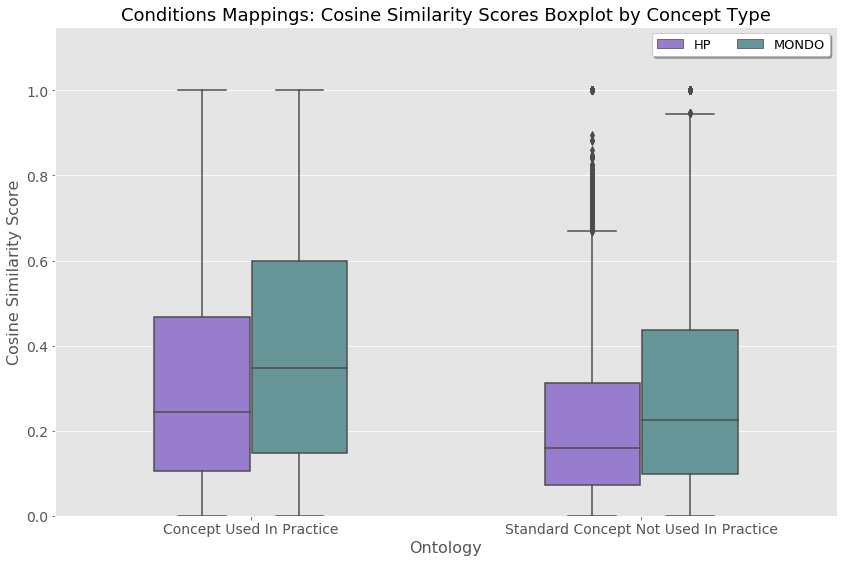

In [38]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='Similarity_Score', x='Concept_Type', hue='Ontology', data=cond_sim_plot, width=0.5, palette=my_pal)
    
plt.title('Conditions Mappings: Cosine Similarity Scores Boxplot by Concept Type', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Cosine Similarity Score', fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(0, 1.15)
plt.legend(title='', fontsize=13, title_fontsize=12,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=2)
plt.show()


***

**Click [here](#cond-mapping-results) to return to the Condition Occurrence section**  

***

#### Final Mapping Set    <a class="anchor" id="cond-fullmapres"></a>   
***

- [Human Phenotype Ontology](#full-hpo)  
- [Mondo Disease Ontology](#full-mondo)  


*Concept Frequency*

Concept frequency is only calculated for concepts that are used in practice (`n=29,129`). As shown below, there are two ways that concept frequency has been calculated: (1) raw concept counts from the `OMOP` condition occurrence table and (2) converting counts from the `OMOP` condition occurrence table that occur fewer than 100 times to 100. The median raw count is `25` (`min=1`, `max=544,618`).


In [39]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Conditions']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,760841,Conditions,1,100
1,4122179,Conditions,1,100
2,4254374,Conditions,1,100
3,4341363,Conditions,1,100
4,436140,Conditions,1,100


In [40]:
min_score = min(chco_concept_counts['CONCEPT_COUNT'])
max_score = max(chco_concept_counts['CONCEPT_COUNT'])
median_score = statistics.median(chco_concept_counts['CONCEPT_COUNT'])

print('The median concept count is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median concept count is 25 (min: 1, max: 544618)


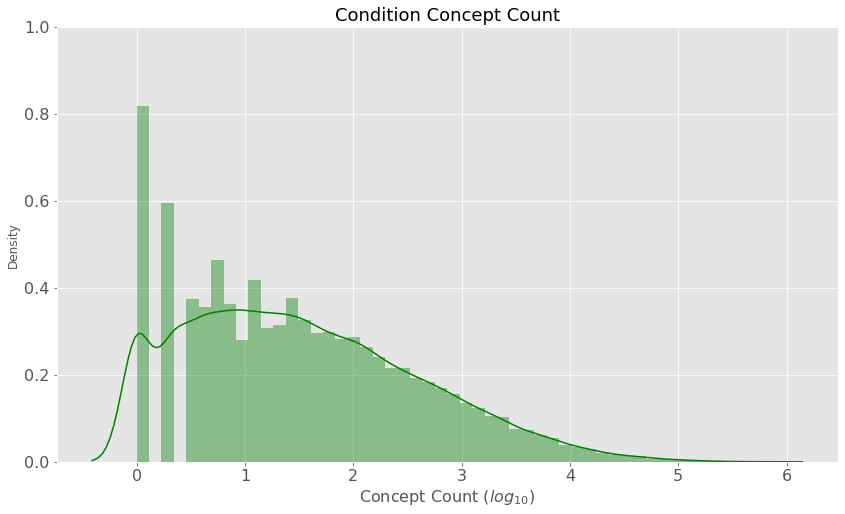

In [41]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
distplot = sns.distplot([math.log10(x) for x in list(chco_concept_counts['CONCEPT_COUNT'])], color='green')
    
plt.title('Condition Concept Count', fontsize=18)
plt.suptitle('')
plt.ylim(0,1.0)
plt.xlabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()


*Mapping Results*

In [42]:
# load mapping results
cond_mappings = pd.read_excel(conds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
cond_mappings.fillna('', inplace=True)

# drop unneeded columns
cond_mappings = cond_mappings[['CONCEPT_ID', 'CONCEPT_TYPE', 'STANDARD', 'CUI', 'SEMANTIC_TYPE',
                               'HP_URI', 'HP_LABEL', 'HP_MAPPING', 'HP_EVIDENCE',
                               'MONDO_URI', 'MONDO_LABEL', 'MONDO_MAPPING', 'MONDO_EVIDENCE']]

# merge concept counts
cond_mappings = cond_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# view data
cond_mappings.head(n=5)


,CONCEPT_ID,CONCEPT_TYPE,STANDARD,CUI,SEMANTIC_TYPE,HP_URI,HP_LABEL,HP_MAPPING,HP_EVIDENCE,MONDO_URI,MONDO_LABEL,MONDO_MAPPING,MONDO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,9176,Standard Concept Not Used In Practice,S,C0184772,Finding,NOT YET MAPPED,NOT YET MAPPED,Unmapped,"Concept could not be mapped using DbXRefs, exa...",FINDING,FINDING,Unmapped,"Clinical finding, sign, or symptom without a c...",NaN,NaN,NaN
1,22274,Concept Used In Practice,S,C0496912,Neoplastic Process,HP_0100605,neoplasm of the larynx,Automatic Exact - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C002...,MONDO_0024505 | MONDO_0000001 | MONDO_0021199 ...,disorder by anatomical region | disease or dis...,Automatic Constructor - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_12...,Conditions,7.0,100.0
2,22281,Concept Used In Practice,S,C0002895,Disease or Syndrome,HP_0001903 | HP_0002664 | HP_0010566 | HP_0001...,anemia | neoplasm | hamartoma | abnormality of...,Automatic Constructor - Ancestor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C016...,MONDO_0011382,sickle cell anemia,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:meddra_10...,Conditions,3917.0,3917.0
3,22288,Concept Used In Practice,S,C0013902,Disease or Syndrome,HP_0004445,elliptocytosis,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:umls_C001...,MONDO_0008165 | MONDO_0017319,southeast asian ovalocytosis | hereditary elli...,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_19...,Conditions,83.0,100.0
4,22340,Concept Used In Practice,S,C0267092,Disease or Syndrome,HP_0002040 | HP_0001892,esophageal varix | abnormal bleeding,Manual Constructor,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:meddra_10...,MONDO_0021644,esophageal varices without bleeding,Automatic Exact - Concept,OBO_DbXref-OMOP_ANCESTOR_SOURCE_CODE:snomed_14...,Conditions,517.0,517.0


*UMLS Semantic Type*

In [43]:
# cui counts
cond_map_cui_coverage = len([x for x in list(cond_mappings['CUI']) if x != 'NO CONCEPT-LEVEL CUI'])
cond_map_cui_total = [x.strip() for y in list(cond_mappings['CUI']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI']
cond_map_cui_unq = set(cond_map_cui_total)

# umls semantic type
cond_map_semantic_type = set([x.strip() for y in list(cond_mappings['SEMANTIC_TYPE']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI'])

cui1 = 'UMLS CUIs were found for {} clinical concepts ({} total CUIs; {} unique CUIs)'.format(cond_map_cui_coverage,
                                                                                             len(cond_map_cui_total),
                                                                                             len(cond_map_cui_unq))
cui2 = '\nThe mapped CUIs represented {} unique Semantic Types'.format(len(cond_map_semantic_type))

print(cui1, cui2)


UMLS CUIs were found for 105976 clinical concepts (108024 total CUIs; 104966 unique CUIs) 
The mapped CUIs represented 69 unique Semantic Types


In [44]:
# get needed data
cond_mapping_results = process_mapping_results(cond_mappings, condition_onts, 'CONCEPT_TYPE')

# split results by ontology
cond_mapping_results_hp = cond_mapping_results['HP']
cond_mapping_results_mondo = cond_mapping_results['MONDO']


Processing Ontology: HP
Processing Ontology: MONDO


<br>

***Human Phenotype Ontology Results***  <a class="anchor" id="full-hpo"></a>  

Summarizing the results shown below, there were a total of `24,459` `Concepts Used in Practice` and `48,959` `Standard SNOMED-CT Concepts Not Used in Practice` that mapped to at least 1 `HP` concept (not including `Unmapped` concepts). UMLS CUIs were found for `105,976` clinical concepts (`108,024` total CUIs, `104,966` unique CUIs) representing `69` unique Semantic Types.

**Concepts Used in Clinical Practice**  
- `24,459` ontology concepts were mapped to `41,384` OMOP concepts (`1.692` ontology concepts/OMOP vocabulary concept)  
- *Mapping Categories*  
  - Automatic Exact (1:1): `3,601` concept-level, `3,155` ancestor-level  
  - Automatic Constructor (1:Many): `125` concept-level, `1,138` ancestor-level 
  - Manual: `995` Concept Similarity, `5,020` Exact, `10,425` Constructor  
  - UnMapped: `50` None, `3,323` Injury, `23` Carrier Status, `906` Complication, `368` Finding  
  
- *Mapping Evidence*   
  - `158,954` sources of (`20,916` unique)  
  - `38,473` were from dbXRefs (`6,142` unique identifier types)  
  - `10,169` were from synonyms (13 unique combinations), covering `4` OBO synonym types   
  - `19,343` were from labels (`11` unique combinations)  
  - `11,975` were from similarity (`0.521` median, `0.2` min, `1.0` max)


**Standard SNOMED-CT Concepts Not Used in Practice**     
- `48,958` ontology concepts were mapped to `183,667` OMOP concepts (`3.752` ontology concepts/OMOP vocabulary concept)  
- *Mapping Categories*  
  - Automatic Exact (1:1): `1,166` concept-level, `10,440` ancestor-level  
  - Automatic Constructor (1:Many): `25` concept-level, `36,947` ancestor-level 
  - `380` Manual Concept Similarity
  - UnMapped: `20,771` Not Yet Mapped, `10,730` Injury, `128` Complication, `3` Finding  
  
- *Mapping Evidence*   
  - `786,524` sources of (`22,486` unique)  
  - `279,236` were from dbXRefs (5,948 unique identifier types)  
  - `42,191` were from synonyms (13 unique combinations), covering `4` OBO synonym types. 
  - `97,920` were from labels (`11` unique combinations)  
  - `15,825` were from similarity (`0.416` median, `0.2` min, `1.0` max)

CONCEPTS USED IN PRACTICE

In [45]:
# split data into concept type sets
cond_hp_map_prac = cond_mapping_results_hp['Concept Used In Practice']['data']

# get total number of OMOP concepts covered by an ontology concept
cond_res = cond_hp_map_prac[cond_hp_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(cond_res)))

# get counts of ontologies mapped to each OMOP concepts
hp_prac_concept_coverage = [x for y in cond_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(hp_prac_concept_coverage)/len(cond_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(cond_res),
                                                                                                                  len(hp_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))



24459 OMOP Concepts Used in practice with at least 1 ontology mapping
24459 ontology concepts were mapped to 41384 OMOP concepts (1.692 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [46]:
# mapping category
hp_cond_prac_map_categories = cond_hp_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_hp_map_prac_unmapped = cond_hp_map_prac[cond_hp_map_prac['CATEGORY_MAPPING'] =='Unmapped']
cond_hp_map_prac_unmapped_types = cond_hp_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in hp_cond_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_hp_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=1138)
  - Automatic Constructor - Concept (n=125)
  - Automatic Exact - Ancestor (n=3155)
  - Automatic Exact - Concept (n=3601)
  - Manual (n=5021)
  - Manual Constructor (n=10425)
  - Manual Exact - Concept Similarity (n=994)
  - Unmapped (n=4670) 

Unmapped reasons:
  - CARRIER STATUS (n=23)
  - COMPLICATION (n=906)
  - FINDING (n=368)
  - INJURY (n=3323)
  - NONE (n=50)


In [47]:
# concept frequency by mapping type 
cond_hp_map_prac_valid = cond_hp_map_prac[cond_hp_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
cond_hp_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(cond_hp_map_prac_valid['CONCEPT_COUNT'])

# # get concept count stats for valid mapped concepts
# cond_hp_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
cond_hp_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                 
                                            min       max median
CATEGORY_MAPPING                                                
Automatic Constructor - Ancestor            1.0  160610.0   19.0
Automatic Constructor - Concept             1.0   72099.0  490.0
Automatic Exact - Ancestor                  1.0  471512.0   19.0
Automatic Exact - Concept                   1.0  544618.0  139.0
Manual                                      1.0  302393.0   19.0
Manual Constructor                          1.0  248363.0   19.0
Manual Exact - Concept Similarity           1.0  183729.0   24.0

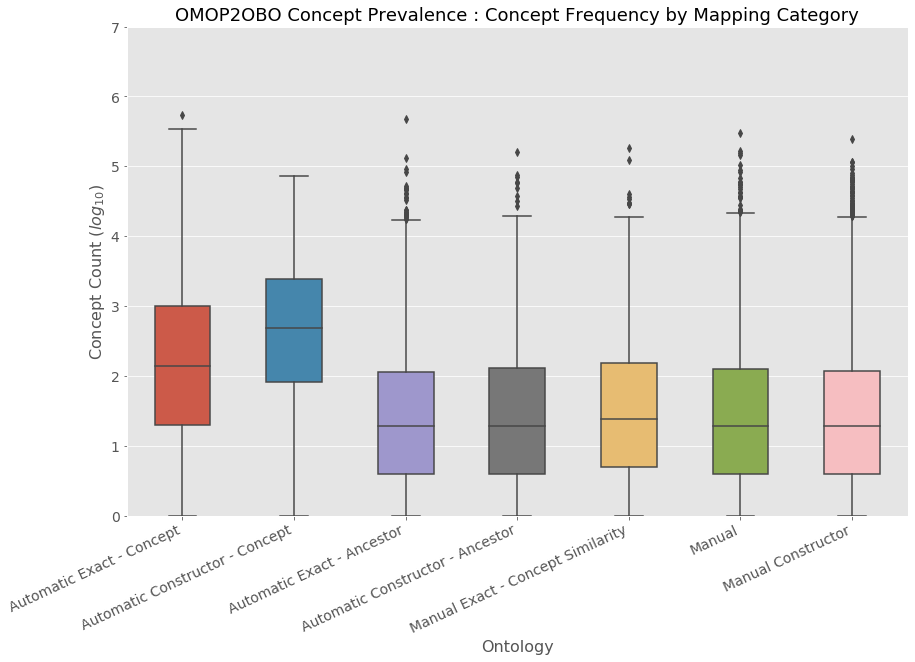

In [48]:
# get log of counts to improve plotting
cond_hp_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(cond_hp_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=cond_hp_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Concept Prevalence : Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.ylim(0,7)
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [49]:
# parses evidence
cond_hp_map_evidence = process_mapping_evidence(list(cond_hp_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_hp_map_evidence['all']), len(set(cond_hp_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_hp_map_evidence['dbxref']), len(set(cond_hp_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_hp_map_evidence['synonym']),
                                                                                                      len(set(cond_hp_map_evidence['synonym'])),
                                                                                                      len(cond_hp_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_hp_map_evidence['label']), len(set(cond_hp_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(cond_hp_map_evidence['similarity']),
                                                                                         statistics.median(cond_hp_map_evidence['similarity']),
                                                                                         min(cond_hp_map_evidence['similarity']),
                                                                                         max(cond_hp_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 158953 (20915 unique) pieces of evidence 
Among the evidence, 38473 were from dbXRefs (6142 unique) 
Among the evidence, 10169 were from synonyms (13 unique), covering 4 OBO synonym types 
Among the evidence, 19343 were from labels (11 unique) 
Among the evidence, 11974 were from similarity (0.521 median, 0.2 min, 1.0 max)


STANDARD SNOMED-CT CONCEPTS NOT USED IN PRACTICE

In [50]:
# split data into concept type sets
cond_hp_map_stnd = cond_mapping_results_hp['Standard Concept Not Used In Practice']['data']

cond_res = cond_hp_map_stnd[cond_hp_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Standard SNOMED-CT Concepts Not Used in practice with at least 1 ontology mapping'.format(len(cond_res)))

# get counts of ontologies mapped to each OMOP concepts
hp_stnd_concept_coverage = [x for y in cond_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(hp_stnd_concept_coverage)/len(cond_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(cond_res),
                                                                                                                  len(hp_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


48958 OMOP Standard SNOMED-CT Concepts Not Used in practice with at least 1 ontology mapping
48958 ontology concepts were mapped to 183667 OMOP concepts (3.752 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [51]:
# mapping category
hp_cond_stnd_map_categories = cond_hp_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_hp_map_stnd_unmapped = cond_hp_map_stnd[cond_hp_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
cond_hp_map_stnd_unmapped_types = cond_hp_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in hp_cond_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_hp_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=36947)
  - Automatic Constructor - Concept (n=25)
  - Automatic Exact - Ancestor (n=10440)
  - Automatic Exact - Concept (n=1166)
  - Manual Exact - Concept Similarity (n=380)
  - Unmapped (n=31632) 

Unmapped reasons:
  - COMPLICATION (n=128)
  - INJURY (n=10733)
  - NOT YET MAPPED (n=20771)


*Mapping Evidence*

In [52]:
# parses evidence
cond_hp_map_stnd_valid = cond_hp_map_stnd[cond_hp_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
cond_hp_map_stnd_valid = cond_hp_map_stnd_valid.drop(['DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED'], axis=1)
cond_hp_map_evidence = process_mapping_evidence(list(cond_hp_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_hp_map_evidence['all']), len(set(cond_hp_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_hp_map_evidence['dbxref']), len(set(cond_hp_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_hp_map_evidence['synonym']),
                                                                                                      len(set(cond_hp_map_evidence['synonym'])),
                                                                                                      len(cond_hp_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_hp_map_evidence['label']), len(set(cond_hp_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(cond_hp_map_evidence['similarity']),
                                                                                         statistics.median(cond_hp_map_evidence['similarity']),
                                                                                         min(cond_hp_map_evidence['similarity']),
                                                                                         max(cond_hp_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 786514 (22486 unique) pieces of evidence 
Among the evidence, 279236 were from dbXRefs (5948 unique) 
Among the evidence, 42191 were from synonyms (13 unique), covering 4 OBO synonym types 
Among the evidence, 97920 were from labels (11 unique) 
Among the evidence, 15825 were from similarity (0.416 median, 0.2 min, 1.0 max)


<br>

***Mondo Disease Ontology Results***  <a class="anchor" id="full-mondo"></a>  

Summarizing the results shown below, there were a total of `20,055` `Concepts Used in Practice` and `43,320` `Standard SNOMED-CT Concepts Not Used in Practice` that mapped to at least 1 `MONDO` concept (not including `Unmapped` concepts). UMLS CUIs were found for `105,976` clinical concepts (`108,024` total CUIs, `104,966` unique CUIs) representing `69` unique Semantic Types. 

**Concepts Used in Clinical Practice**  
- `20,055` ontology concepts were mapped to `57,848` OMOP concepts (`2.884` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `4,836` concept-level, `5,961` ancestor-level  
  - Automatic Constructor (1:Many): `632` concept-level, `4,482` ancestor-level 
  - Manual: `553` Concept Similarity, `755` Exact, `2,836` Constructor  
  - UnMapped: `84` None, `3,323` Injury, `22` Carrier Status, `906` Complication, `4,739` Finding  
  
- *Mapping Evidence*   
  - `300,606` sources of (`26,417` unique)  
  - `52,430` were from dbXRefs (`5,388` unique identifier types)  
  - `67,381` were from synonyms (14 unique combinations), covering `5` OBO synonym types   
  - `75,795` were from labels (`11` unique combinations)  
  - `12,789` were from similarity (`0.76` median, `0.25` min, `1.0` max)


**Standard SNOMED-CT Concepts Not Used in Practice**    
- `43,320` ontology concepts were mapped to `396,234` OMOP concepts (`9.147` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `4,261` concept-level, `2,949` ancestor-level  
  - Automatic Constructor (1:Many): `253` concept-level, `35,743` ancestor-level 
  - `114` Manual Concept Similarity
  - UnMapped: `5,118` Not Yet Mapped, `10,726` Injury, `103` Complication, `21,323` Finding  
  
- *Mapping Evidence*   
  - `906,100` sources of (`13,016` unique)  
  - `339,210` were from dbXRefs (`7,178` unique identifier types)  
  - `85,132` were from synonyms (12 unique combinations), covering `4` OBO synonym types. 
  - `113,565` were from labels (`11` unique combinations) 
  - `114` were from similarity (`1.0` median, `0.22` min, `1.0` max)

CONCEPTS USED IN PRACTICE

In [53]:
# split data into concept type sets
cond_mondo_map_prac = cond_mapping_results_mondo['Concept Used In Practice']['data']

# get concept counts
cond_res = cond_mondo_map_prac[cond_mondo_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(cond_res)))

# get counts of ontologies mapped to each OMOP concepts
mondo_prac_concept_coverage = [x for y in cond_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(mondo_prac_concept_coverage)/len(cond_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(cond_res),
                                                                                                                  len(mondo_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


20055 OMOP Concepts Used in practice with at least 1 ontology mapping
20055 ontology concepts were mapped to 57848 OMOP concepts (2.884 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [54]:
# mapping category
mondo_cond_prac_map_categories = cond_mondo_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_mondo_map_prac_unmapped = cond_mondo_map_prac[cond_mondo_map_prac['CATEGORY_MAPPING'] =='Unmapped']
cond_mondo_map_prac_unmapped_types = cond_mondo_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in mondo_cond_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_mondo_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=4482)
  - Automatic Constructor - Concept (n=632)
  - Automatic Exact - Ancestor (n=5961)
  - Automatic Exact - Concept (n=4836)
  - Manual (n=755)
  - Manual Constructor (n=2836)
  - Manual Exact - Concept Similarity (n=553)
  - Unmapped (n=9074) 

Unmapped reasons:
  - CARRIER STATUS (n=22)
  - COMPLICATION (n=906)
  - FINDING (n=4739)
  - INJURY (n=3323)
  - NONE (n=84)


In [55]:
# concept frequency by mapping type 
cond_mondo_map_prac_valid = cond_mondo_map_prac[cond_mondo_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
cond_mondo_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(cond_mondo_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
cond_mondo_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
cond_mondo_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                 
                                            min       max median
CATEGORY_MAPPING                                                
Automatic Constructor - Ancestor            1.0   91994.0   17.0
Automatic Constructor - Concept             1.0  255219.0  117.0
Automatic Exact - Ancestor                  1.0  144587.0   19.0
Automatic Exact - Concept                   1.0  471512.0   61.0
Manual                                      1.0  134677.0   20.0
Manual Constructor                          1.0  302393.0   19.0
Manual Exact - Concept Similarity           1.0  160610.0   20.0

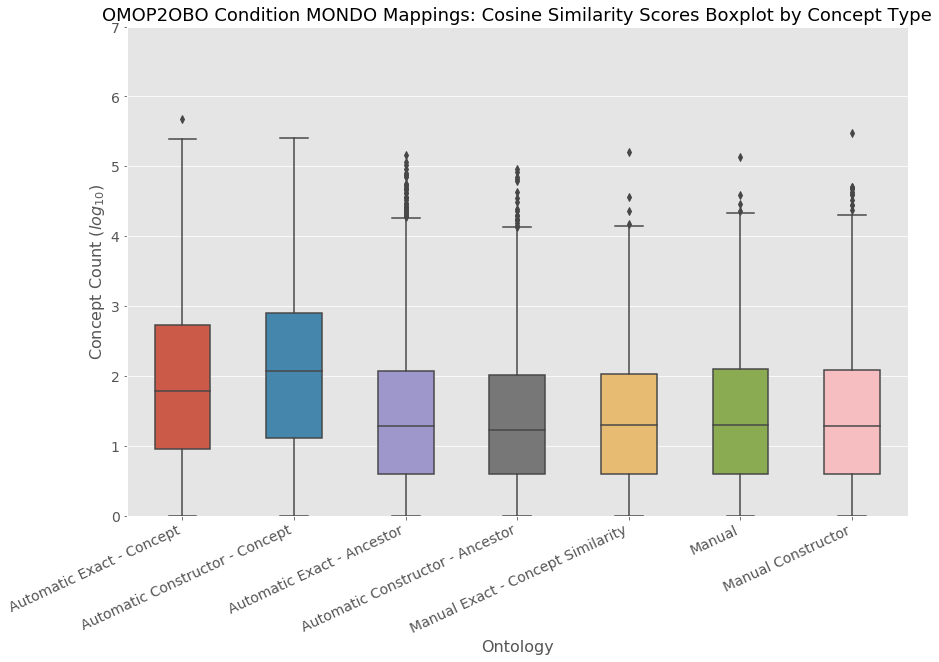

In [56]:
# get log of counts to improve plotting
cond_mondo_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(cond_mondo_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=cond_mondo_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Condition MONDO Mappings: Cosine Similarity Scores Boxplot by Concept Type', fontsize=18)
plt.suptitle("")
plt.ylim(0, 7)
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [57]:
# parses evidence
cond_mondo_map_evidence = process_mapping_evidence(list(cond_mondo_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_mondo_map_evidence['all']), len(set(cond_mondo_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_mondo_map_evidence['dbxref']), len(set(cond_mondo_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_mondo_map_evidence['synonym']),
                                                                                                      len(set(cond_mondo_map_evidence['synonym'])),
                                                                                                      len(cond_mondo_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_mondo_map_evidence['label']), len(set(cond_mondo_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(cond_mondo_map_evidence['similarity']),
                                                                                         statistics.median(cond_mondo_map_evidence['similarity']),
                                                                                         min(cond_mondo_map_evidence['similarity']),
                                                                                         max(cond_mondo_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 300606 (26417 unique) pieces of evidence 
Among the evidence, 52430 were from dbXRefs (5388 unique) 
Among the evidence, 67381 were from synonyms (14 unique), covering 5 OBO synonym types 
Among the evidence, 75795 were from labels (11 unique) 
Among the evidence, 12789 were from similarity (0.76 median, 0.25 min, 1.0 max)


STANDARD SNOMED-CT CONCEPTS NOT USED IN PRACTICE

In [58]:
# split data into concept type sets
cond_mondo_map_stnd = cond_mapping_results_mondo['Standard Concept Not Used In Practice']['data']

# print concept counts
cond_res = cond_mondo_map_stnd[cond_mondo_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping'.format(len(cond_res)))

# get counts of ontologies mapped to each OMOP concepts
mondo_stnd_concept_coverage = [x for y in cond_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(mondo_stnd_concept_coverage)/len(cond_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(cond_res),
                                                                                                                  len(mondo_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


43319 OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping
43319 ontology concepts were mapped to 396221 OMOP concepts (9.147 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [59]:
# mapping category
mondo_cond_stnd_map_categories = cond_mondo_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
cond_mondo_map_stnd_unmapped = cond_mondo_map_stnd[cond_mondo_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
cond_mondo_map_stnd_unmapped_types = cond_mondo_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in mondo_cond_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cond_mondo_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=35742)
  - Automatic Constructor - Concept (n=253)
  - Automatic Exact - Ancestor (n=2949)
  - Automatic Exact - Concept (n=4261)
  - Manual Exact - Concept Similarity (n=114)
  - Unmapped (n=37271) 

Unmapped reasons:
  - COMPLICATION (n=128)
  - FINDING (n=21292)
  - INJURY (n=10733)
  - NOT YET MAPPED (n=5118)


*Mapping Evidence*

In [60]:
# parses evidence
cond_mondo_map_stnd_valid = cond_mondo_map_stnd[cond_mondo_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
cond_mondo_map_evidence = process_mapping_evidence(list(cond_mondo_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(cond_mondo_map_evidence['all']), len(set(cond_mondo_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(cond_mondo_map_evidence['dbxref']), len(set(cond_mondo_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(cond_mondo_map_evidence['synonym']),
                                                                                                      len(set(cond_mondo_map_evidence['synonym'])),
                                                                                                      len(cond_mondo_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_mondo_map_evidence['label']), len(set(cond_mondo_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(cond_mondo_map_evidence['similarity']),
                                                                                         statistics.median(cond_mondo_map_evidence['similarity']),
                                                                                         min(cond_mondo_map_evidence['similarity']),
                                                                                         max(cond_mondo_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 906064 (13016 unique) pieces of evidence 
Among the evidence, 339195 were from dbXRefs (7178 unique) 
Among the evidence, 85130 were from synonyms (12 unique), covering 4 OBO synonym types 
Among the evidence, 113562 were from labels (11 unique) 
Among the evidence, 114 were from similarity (1.0 median, 0.22 min, 1.0 max)


***

**Click [here](#cond-mapping-results) to return to the Condition Occurrence Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

### Drug Ingredients <a class="anchor" id="mapping-drugs"></a>

***

**SQL Queries**  
- [x] Drug Exposure Ingredients Used in Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_drugexposure-sql))  
- [x] Standard RxNorm Drug Ingredients Concepts ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_drugexposure_allstandardconcepts-sql))  

**Data Description:**  
A total of `56,200` drug-ingredient concepts were eligible for mapping (`51,941` drugs; `11,807` ingredients). The first waved returned all drug concepts ids used at least 1 time in practice (`9,175` drugs; `1,697` ingredients). The second wave returned all standard drug concepts ids from RxNorm (`42,766` drugs; `10,110` ingredients).

For each wave, the datasets included data for drugs and ingredients at both the concept and ancestor level. Details included below:  

<table>
<tr>
<th align="center">DATA TYPE</th>  
<th align="center">CONCEPT LEVEL</th>  
<th align="center">CODES</th>
<th align="center">LABELS</th>
<th align="center">SYNONYMS</th>
<th align="center">VOCABULARIES</th>
</tr>  
<tr>
  <td colspan="6"><b>Concepts Used In Practice</b></td>
</tr>
<tr>
  <td rowspan="2"><i>Drugs</i></td>
  <td rowspan="1"><i>Concept</i></td>
    <td>9,175</td>
    <td>9,154</td>
    <td>19,496</td>
    <td>RxNorm</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>140,937</td>
    <td>77,135</td>
    <td>N/A</td>
    <td>SPL<br>Cohort<br>ATC<br>NDFRT<br>RxNorm<br>VA Class<br>CVX</td>
</tr>
  <td rowspan="2"><i>Ingredients</i></td>
  <td rowspan="1"><i>Concept</i></td>
    <td>1,697</td>
    <td>1,696</td>
    <td>1,868</td>
    <td>RxNorm<br>SPL</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>1,697</td>
    <td>1,696</td>
    <td>N/A</td>
    <td>RxNorm<br>SPL</td>
</tr>
<tr>
  <td colspan="6"><b>Standard RxNorm Concepts Not Used In Practice</b></td>
</tr>
<tr>
  <td rowspan="2"><i>Drugs</i></td>
  <td rowspan="1"><i>Concept</i></td>
    <td>42,766</td>
    <td>42,640</td>
    <td>52,688</td>
    <td>RxNorm</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>68,343</td>
    <td>64,212</td>
    <td>N/A</td>
    <td>SPL<br>Cohort<br>ATC<br>NDFRT<br>RxNorm<br>VA Class<br>CVX</td>
</tr>
  <td rowspan="2"><i>Ingredients</i></td>
  <td rowspan="1"><i>Concept</i></td>
    <td>10,110</td>
    <td>10,110</td>
    <td>11,235</td>
    <td>RxNorm</td>
</tr>
<tr>
  <td rowspan="1"><i>Ancestor</i></td>
    <td>10,578</td>
    <td>10,578</td>
    <td>N/A</td>
    <td>RxNorm</td>
</tr>
</table>   

<br><br>


**Ontology Data:**  
`OMOP` Drug Exposure ingredient concept ids were mapped to:  
- Chemicals, hormones, and enzymes ([Chemical Entities of Biological Interest (CHEBI)](https://www.ebi.ac.uk/chebi/)) 
- Organisms ([NCBI Organism Taxonomy (NCBITaxon)](https://www.ncbi.nlm.nih.gov/taxonomy))  
- Proteins ([Protein Ontology (PR)](https://proconsortium.org/))  
- Vaccines/Immunizations ([Vaccine Ontology (VO)](http://www.violinet.org/vaccineontology/))  



***
#### MAPPING DATA

In [61]:
# load link to drug mapping data 
drug_data = pd.read_csv(medications, sep=',', header=0)
drug_data.fillna('', inplace=True)

# view data
drug_data.head()


,CONCEPT_TYPE,CONCEPT_ID,STANDARD_CONCEPT,CONCEPT_SOURCE_CODE,CONCEPT_LABEL,CONCEPT_VOCAB,CONCEPT_VOCAB_VERSION,CONCEPT_SYNONYM,ANCESTOR_CONCEPT_ID,ANCESTOR_SOURCE_CODE,...,INGREDIENT_STANDARD_CONCEPT,INGREDIENT_LABEL,INGREDIENT_VOCAB,INGREDIENT_VOCAB_VERSION,INGREDIENT_SYNONYM,INGRED_ANCESTOR_CONCEPT_ID,INGRED_ANCESTOR_SOURCE_CODE,INGRED_ANCESTOR_LABEL,INGRED_ANCESTOR_VOCAB,INGRED_ANCESTOR_VOCAB_VERSION
0,Concept Used In Practice,40173224,S,rxnorm:899350,Mesna 100 MG/ML Injectable Solution [Mesnex],RxNorm,RxNorm Full 20180507,Mesnex 100 MG/ML Injectable Solution | Mesnex ...,4351460 | 4330900 | 40179089 | 4351063 | 43238...,ndfrt:N0000007505 | ndfrt:N0000178916 | ndfrt:...,...,S,Mesna,RxNorm,RxNorm Full 20180507,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507
1,Concept Used In Practice,1354699,S,rxnorm:142113,Mesna 400 MG Oral Tablet,RxNorm,RxNorm Full 20180507,Mesna 400 MG Oral Tablet,4278862 | 36225395 | 4352030 | 4266424 | 43275...,ndfrt:N0000007505 | va class:AD000 | rxnorm:14...,...,S,Mesna,RxNorm,RxNorm Full 20180507,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507
2,Concept Used In Practice,19028312,S,rxnorm:204870,Mesna 100 MG/ML Injectable Solution,RxNorm,RxNorm Full 20180507,mesna 1 GM per 10 ML Injectable Solution | Mes...,4330900 | 4351063 | 45649761 | 45702443 | 4323...,ndfrt:N0000178916 | spl:71236841-707e-45d0-ac4...,...,S,Mesna,RxNorm,RxNorm Full 20180507,Mesna,1354698,rxnorm:44,Mesna,RxNorm,RxNorm Full 20180507
3,Standard Concept Not Used In Practice,19123344,S,rxnorm:61,beta-Alanine,RxNorm,RxNorm Full 20180507,beta-Alanine,4255640 | 4325133 | 4349682 | 4331211 | 433191...,ndfrt:N0000009802 | ndfrt:N0000175780 | ndfrt:...,...,S,beta-Alanine,RxNorm,RxNorm Full 20180507,beta-Alanine,19123344,rxnorm:61,beta-Alanine,RxNorm,RxNorm Full 20180507
4,Standard Concept Not Used In Practice,40096887,S,rxnorm:437910,beta-Alanine Oral Tablet,RxNorm,RxNorm Full 20180507,beta-Alanine Oral Tablet,4325133 | 4331211 | 36226022 | 4349682 | 42556...,rxnorm:1151131 | ndfrt:N0000000004 | ndfrt:N00...,...,S,beta-Alanine,RxNorm,RxNorm Full 20180507,beta-Alanine,19123344,rxnorm:61,beta-Alanine,RxNorm,RxNorm Full 20180507


In [62]:
# print results
all1 = 'There were {} drug-ingredients concepts eligible for mapping'.format(len(drug_data))
all2 = '\n  - Drug concepts (unique): {}'.format(len(set(drug_data['CONCEPT_ID'])))
all3 = '\n  - Ingredients concepts (unique): {}'.format(len(set(drug_data['INGREDIENT_CONCEPT_ID'])))

print(all1, all2, all3)


There were 56200 drug-ingredients concepts eligible for mapping 
  - Drug concepts (unique): 51941 
  - Ingredients concepts (unique): 11807


In [63]:
# drugs
drug_concepts = drug_data[['CONCEPT_TYPE', 'CONCEPT_ID', 'STANDARD_CONCEPT', 'CONCEPT_SOURCE_CODE',
                           'CONCEPT_LABEL', 'CONCEPT_VOCAB', 'CONCEPT_SYNONYM', 'ANCESTOR_CONCEPT_ID',
                           'ANCESTOR_SOURCE_CODE','ANCESTOR_LABEL', 'ANCESTOR_VOCAB']].drop_duplicates()

# split results by concept type (i.e. concepts used in practice, standard concepts)
drug_res = process_clinical_data(drug_concepts, 'CONCEPT_TYPE') 

# get concept_type results
drug_practice_concepts = drug_res['Concept Used In Practice']
drug_not_practice_concepts = drug_res['Standard Concept Not Used In Practice']


Processing Group: Concept Used In Practice
Processing Group: Standard Concept Not Used In Practice


In [64]:
# ingredients
ingred_concepts = drug_data[['CONCEPT_TYPE', 'INGREDIENT_CONCEPT_ID', 'INGREDIENT_STANDARD_CONCEPT', 'INGREDIENT_SOURCE_CODE',
                             'INGREDIENT_LABEL', 'INGREDIENT_VOCAB', 'INGREDIENT_SYNONYM', 'INGRED_ANCESTOR_CONCEPT_ID',
                             'INGRED_ANCESTOR_SOURCE_CODE', 'INGRED_ANCESTOR_LABEL', 'INGRED_ANCESTOR_VOCAB']].drop_duplicates()

# rename columns
ingred_concepts.columns = drug_concepts.columns

# split results by concept type (i.e. concepts used in practice, standard concepts)
ingredient_res = process_clinical_data(ingred_concepts, 'CONCEPT_TYPE') 

# get concept_type results
ingred_practice_concepts = ingredient_res['Concept Used In Practice']
ingred_not_practice_concepts = ingredient_res['Standard Concept Not Used In Practice']


Processing Group: Concept Used In Practice
Processing Group: Standard Concept Not Used In Practice


*Concepts Used In Practice*

In [65]:
# concepts used in practice data
res1 = '\nAt the drug concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(set(drug_practice_concepts['concept_src_code'])),
                                                                                                    len(set(drug_practice_concepts['concept_src_label'])),
                                                                                                    len(set(drug_practice_concepts['concept_synonym'])))
res2 = '\nDrug concept-level data came from the following vocabularies: {}'.format(drug_practice_concepts['concept_vocab'])
res3 = '\nAt the ingredient concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(set(ingred_practice_concepts['concept_src_code'])),
                                                                                                          len(set(ingred_practice_concepts['concept_src_label'])),
                                                                                                          len(set(ingred_practice_concepts['concept_synonym'])))
res4 = '\nIngredient concept-level data came from the following vocabularies: {}'.format(ingred_practice_concepts['concept_vocab'])
res5 = '\n\nAt the drug ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(set(drug_practice_concepts['anc_concept_id'])),
                                                                                                         len(set(drug_practice_concepts['anc_src_code'])),
                                                                                                         len(set(drug_practice_concepts['anc_label'])))
res6 = '\nDrug ancestor-level data came from the following vocabularies: {}'.format(drug_practice_concepts['anc_vocab'])
res7 = '\nAt the ingredient ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(set(ingred_practice_concepts['anc_concept_id'])),
                                                                                                             len(set(ingred_practice_concepts['anc_src_code'])),
                                                                                                             len(set(ingred_practice_concepts['anc_label'])))
res8 = '\nIngredient ancestor-level data came from the following vocabularies: {}'.format(ingred_practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5, res6, res7, res8)



At the drug concept-level, there were 9175 source codes, 9154 labels, and 19496 synonyms 
Drug concept-level data came from the following vocabularies: RxNorm 
At the ingredient concept-level, there were 1697 source codes, 1696 labels, and 1868 synonyms 
Ingredient concept-level data came from the following vocabularies: RxNorm, SPL 

At the drug ancestor-level, there were 140937 concept ids, 140937 source codes and 77135 labels 
Drug ancestor-level data came from the following vocabularies: CVX, NDFRT, Cohort, VA Class, ATC, RxNorm, SPL 
At the ingredient ancestor-level, there were 1697 concept ids, 1697 source codes and 1696 labels 
Ingredient ancestor-level data came from the following vocabularies: RxNorm, SPL


*Standard RxNorm Concepts Not Used in Practice*

In [66]:
# concepts used in practice data
res1 = '\nAt the drug concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(set(drug_not_practice_concepts['concept_src_code'])),
                                                                                                    len(set(drug_not_practice_concepts['concept_src_label'])),
                                                                                                    len(set(drug_not_practice_concepts['concept_synonym'])))
res2 = '\nDrug concept-level data came from the following vocabularies: {}'.format(drug_not_practice_concepts['concept_vocab'])
res3 = '\nAt the ingredient concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(set(ingred_not_practice_concepts['concept_src_code'])),
                                                                                                          len(set(ingred_not_practice_concepts['concept_src_label'])),
                                                                                                          len(set(ingred_not_practice_concepts['concept_synonym'])))
res4 = '\nIngredient concept-level data came from the following vocabularies: {}'.format(ingred_not_practice_concepts['concept_vocab'])
res5 = '\n\nAt the drug ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(set(drug_not_practice_concepts['anc_concept_id'])),
                                                                                                         len(set(drug_not_practice_concepts['anc_src_code'])),
                                                                                                         len(set(drug_not_practice_concepts['anc_label'])))
res6 = '\nDrug ancestor-level data came from the following vocabularies: {}'.format(drug_not_practice_concepts['anc_vocab'])
res7 = '\nAt the ingredient ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(set(ingred_not_practice_concepts['anc_concept_id'])),
                                                                                                             len(set(ingred_not_practice_concepts['anc_src_code'])),
                                                                                                             len(set(ingred_not_practice_concepts['anc_label'])))
res8 = '\nIngredient ancestor-level data came from the following vocabularies: {}'.format(ingred_not_practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5, res6, res7, res8)



At the drug concept-level, there were 42766 source codes, 42640 labels, and 52688 synonyms 
Drug concept-level data came from the following vocabularies: RxNorm 
At the ingredient concept-level, there were 10110 source codes, 10110 labels, and 11235 synonyms 
Ingredient concept-level data came from the following vocabularies: RxNorm 

At the drug ancestor-level, there were 68343 concept ids, 68343 source codes and 64212 labels 
Drug ancestor-level data came from the following vocabularies: RxNorm, NDFRT, Cohort, VA Class, CVX, ATC, SPL 
At the ingredient ancestor-level, there were 10578 concept ids, 10578 source codes and 10578 labels 
Ingredient ancestor-level data came from the following vocabularies: RxNorm


***

**Click [here](#mapping-drugs) to return to the Drug Ingredient Data section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

***

#### MAPPING RESULTS  <a class="anchor" id="drug-mapping-results"></a>
- [Database Cross-Reference](#drug-dbxref)  
- [Exact String Alignment](#drug-string)  
- [Cosine Similarity](#drug-cosine)   
- [Final Mapping Results](#drug-fullmapres)

***

#### Database Cross-Reference  <a class="anchor" id="drug-dbxref"></a>  

***

- [Chemical Entities of Biological Interest](#dx-dbxref-chebi)   


In [67]:
# load results from dbxref alignment
med_dbxref = pd.read_excel(meds_mapping_url, sheet_name='DbXRef_Mapping_Results', sep=',', header=0)
med_dbxref.fillna('', inplace=True)

# view data
med_dbxref.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_DBXREF_CHEBI_URI,CONCEPT_DBXREF_CHEBI_LABEL,CONCEPT_DBXREF_CHEBI_EVIDENCE,ANCESTOR_DBXREF_CHEBI_URI,ANCESTOR_DBXREF_CHEBI_LABEL,ANCESTOR_DBXREF_CHEBI_EVIDENCE
0,Concept Used In Practice,700253,Thiopental,CHEBI_102166,thiopental,CONCEPT_DBXREF_drugbank:db00599,CHEBI_102166,thiopental,ANCESTOR_DBXREF_drugbank:db00599
1,Concept Used In Practice,700299,Thioridazine,CHEBI_48566,thioridazine hydrochloride,CONCEPT_DBXREF_drugbank:db00679,CHEBI_48566,thioridazine hydrochloride,ANCESTOR_DBXREF_drugbank:db00679
2,Concept Used In Practice,701322,Memantine,CHEBI_64312,memantine,CONCEPT_DBXREF_drugbank:db01043,CHEBI_64312,memantine,ANCESTOR_DBXREF_drugbank:db01043
3,Concept Used In Practice,702685,Mephobarbital,CHEBI_6758,mephobarbital,CONCEPT_DBXREF_drugbank:db00849,CHEBI_6758,mephobarbital,ANCESTOR_DBXREF_drugbank:db00849
4,Concept Used In Practice,702774,Mepivacaine,CHEBI_6760,mepivacaine hydrochloride,CONCEPT_DBXREF_drugbank:db00961,CHEBI_6760,mepivacaine hydrochloride,ANCESTOR_DBXREF_drugbank:db00961


In [68]:
# get processed data for each ontology
med_dbxref_results = process_mapping_results(med_dbxref, ingredient_onts, 'CONCEPT_TYPE', 'DBXREF')

# re-group by ontology
med_dbxref_chebi = med_dbxref_results['CHEBI']


Processing Ontology: CHEBI


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="dx-string-chebi"></a>   
Summarizing the results shown below, there were a total of `1,879` `OMOP` ingredient concepts that mapped to at least 1 `CHEBI` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=992`)  
  - `882` `OMOP` concepts mapped at the concept level to `825` ontology concepts (`813` unique ontology concepts)  
  - `992` `OMOP` concepts mapped at the ancestor level to `2,519` ontology concepts (`813` unique ontology concepts)  
  

- Standard RxNorm Concepts Concepts Not Used in Practice (`n=887`)  
  - `444` `OMOP` concepts mapped at the concept level to `445` ontology concepts (`436` unique ontology concepts) 
  - `887` `OMOP` concepts mapped at the ancestor level to `1,603` ontology concepts (`670` unique ontology concepts)

In [69]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using DbXRefs'.format(len(med_dbxref_chebi['ont_data'])))

1879 OMOP concepts were mapped to at least 1 CHEBI concept using DbXRefs


*Concepts Used in Practice*

In [70]:
# process data
med_dbxref_chebi_prac = med_dbxref_chebi['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_dbxref_chebi_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_dbxref_chebi_prac['concepts'][0]),
                                                                                                            len(med_dbxref_chebi_prac['concepts'][1]),
                                                                                                            len(set(med_dbxref_chebi_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_dbxref_chebi_prac['ancestors'][0]),
                                                                                                              len(med_dbxref_chebi_prac['ancestors'][1]),
                                                                                                              len(set(med_dbxref_chebi_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


992 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 822 concepts mapped at the concept level to 825 total ontology concepts (813 unique) 
  - 992 concepts mapped at the ancestor level to 2519 total ontology concepts (813 unique)


*Standard RxNorm Concepts Not Used in Practice*

In [71]:
# process data
med_dbxref_chebi_stnd = med_dbxref_chebi['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_dbxref_chebi_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_dbxref_chebi_stnd['concepts'][0]),
                                                                                                            len(med_dbxref_chebi_stnd['concepts'][1]),
                                                                                                            len(set(med_dbxref_chebi_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_dbxref_chebi_stnd['ancestors'][0]),
                                                                                                              len(med_dbxref_chebi_stnd['ancestors'][1]),
                                                                                                              len(set(med_dbxref_chebi_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


887 Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 444 concepts mapped at the concept level to 445 total ontology concepts (436 unique) 
  - 887 concepts mapped at the ancestor level to 1603 total ontology concepts (670 unique)


***

**Click [here](#drug-mapping-results) to return to the Drug Ingredient section**  

***

#### Exact String Alignment  <a class="anchor" id="drug-string"></a>  

***

- [Chemical Entities of Biological Interest](#dx-string-chebi)   
- [Protein Ontology](#dx-string-pro)   
- [Vaccine Ontology](#dx-string-vo)   
- [NCBI Organism Taxonomy Ontology](#dx-string-ncbi) 


In [72]:
# load results from exact string alignment
med_exact_string = pd.read_excel(meds_mapping_url, sheet_name='String_Mapping_Results', sep=',', header=0)
med_exact_string.fillna('', inplace=True)

# view data
med_exact_string.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_STR_CHEBI_URI,CONCEPT_STR_CHEBI_LABEL,CONCEPT_STR_CHEBI_EVIDENCE,ANCESTOR_STR_CHEBI_URI,ANCESTOR_STR_CHEBI_LABEL,ANCESTOR_STR_CHEBI_EVIDENCE,CONCEPT_STR_NCBITAXON_URI,...,CONCEPT_STR_PR_EVIDENCE,ANCESTOR_STR_PR_URI,ANCESTOR_STR_PR_LABEL,ANCESTOR_STR_PR_EVIDENCE,CONCEPT_STR_VO_URI,CONCEPT_STR_VO_LABEL,CONCEPT_STR_VO_EVIDENCE,ANCESTOR_STR_VO_URI,ANCESTOR_STR_VO_LABEL,ANCESTOR_STR_VO_EVIDENCE
0,Concept Used In Practice,507832,Human herpesvirus 3,,,,,,,NCBITaxon_10335,...,,,,,,,,,,
1,Concept Used In Practice,509079,meningococcal group A polysaccharide,,,,,,,,...,,,,,VO_0004888,meningococcal group a polysaccharide,CONCEPT_LABEL:meningococcal_group_a_polysaccha...,VO_0004859 | VO_0004886 | VO_0004860 | VO_0004888,meningococcal group c polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_c_polysacch...
2,Concept Used In Practice,509081,meningococcal group C polysaccharide,,,,,,,,...,,,,,VO_0004859,meningococcal group c polysaccharide,CONCEPT_LABEL:meningococcal_group_c_polysaccha...,VO_0004859 | VO_0004886 | VO_0004860 | VO_0004888,meningococcal group c polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_c_polysacch...
3,Concept Used In Practice,514012,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP W-135,,,,,,,,...,,,,,VO_0004886,meningococcal polysaccharide vaccine group w-135,CONCEPT_LABEL:meningococcal_polysaccharide_vac...,VO_0004859 | VO_0004886 | VO_0004860 | VO_0004888,meningococcal group c polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_c_polysacch...
4,Concept Used In Practice,514015,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP Y,,,,,,,,...,,,,,VO_0004860,meningococcal polysaccharide vaccine group y,CONCEPT_LABEL:meningococcal_polysaccharide_vac...,VO_0004859 | VO_0004886 | VO_0004860 | VO_0004888,meningococcal group c polysaccharide | meningo...,ANCESTOR_LABEL:meningococcal_group_c_polysacch...


In [73]:
# get processed data for each ontology
med_exact_string_results = process_mapping_results(med_exact_string, ingredient_onts, 'CONCEPT_TYPE', 'STR')

# re-group by ontology
med_exact_string_chebi = med_exact_string_results['CHEBI']
med_exact_string_pr = med_exact_string_results['PR']
med_exact_string_vo = med_exact_string_results['VO']
med_exact_string_ncbitaxon = med_exact_string_results['NCBITAXON']


Processing Ontology: CHEBI
Processing Ontology: PR
Processing Ontology: NCBITAXON
Processing Ontology: VO


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="dx-string-chebi"></a>   
Summarizing the results shown below, there were a total of `3,900` `OMOP` ingredient concepts that mapped to at least 1 `CHEBI` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=1,271`)  
  - `1,197` `OMOP` concepts mapped at the concept level to `1,289` ontology concepts (`1,282` unique ontology concepts)  
  - `1,270` `OMOP` concepts mapped at the ancestor level to `4,210` ontology concepts (`1,262` unique ontology concepts)  
  

- Standard RxNorm Concepts Not Used in Practice (`n=2,629`)  
  - `2,362` `OMOP` concepts mapped at the concept level to `2,473` ontology concepts (`2,445` unique ontology concepts) 
  - `2,612` `OMOP` concepts mapped at the ancestor level to `4,460` ontology concepts (`2,807` unique ontology concepts)

In [74]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using exact string alignment'.format(len(med_exact_string_chebi['ont_data'])))


3900 OMOP concepts were mapped to at least 1 CHEBI concept using exact string alignment


*Concepts Used in Practice* 

In [75]:
# process data
med_exact_string_chebi_prac = med_exact_string_chebi['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_chebi_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_chebi_prac['concepts'][0]),
                                                                                                            len(med_exact_string_chebi_prac['concepts'][1]),
                                                                                                            len(set(med_exact_string_chebi_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_chebi_prac['ancestors'][0]),
                                                                                                              len(med_exact_string_chebi_prac['ancestors'][1]),
                                                                                                              len(set(med_exact_string_chebi_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


1271 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 1197 concepts mapped at the concept level to 1289 total ontology concepts (1282 unique) 
  - 1270 concepts mapped at the ancestor level to 4210 total ontology concepts (1262 unique)


*Standard RxNorm Concepts Not Used in Practice*

In [76]:
# process data
med_exact_string_chebi_stnd = med_exact_string_chebi['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_chebi_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_chebi_stnd['concepts'][0]),
                                                                                                            len(med_exact_string_chebi_stnd['concepts'][1]),
                                                                                                            len(set(med_exact_string_chebi_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_chebi_stnd['ancestors'][0]),
                                                                                                              len(med_exact_string_chebi_stnd['ancestors'][1]),
                                                                                                              len(set(med_exact_string_chebi_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


2629 Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 2362 concepts mapped at the concept level to 2473 total ontology concepts (2445 unique) 
  - 2612 concepts mapped at the ancestor level to 4460 total ontology concepts (2807 unique)


<br>

***Protein Ontology Results*** <a class="anchor" id="dx-string-pro"></a>   
Summarizing the results shown below, there were a total of `97` `OMOP` ingredient concepts that mapped to at least 1 `PRO` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=34`)  
  - `24` `OMOP` concepts mapped at the concept level to `24` ontology concepts (`23` unique ontology concepts)  
  - `33` `OMOP` concepts mapped at the ancestor level to `39` ontology concepts (`20` unique ontology concepts)  
  
- Standard RxNorm Concepts Not Used in Practice (`n=63`)  
  - `44` `OMOP` concepts mapped at the concept level to `45` ontology concepts (`44` unique ontology concepts) 
  - `62` `OMOP` concepts mapped at the ancestor level to `62` ontology concepts (`46` unique ontology concepts)

In [77]:
print('{} OMOP concepts were mapped to at least 1 PRO concept using exact string alignment'.format(len(med_exact_string_pr['ont_data'])))


97 OMOP concepts were mapped to at least 1 PRO concept using exact string alignment


*Concepts Used in Practice* 

In [78]:
# process data
med_exact_string_pr_prac = med_exact_string_pr['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_pr_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_pr_prac['concepts'][0]),
                                                                                                            len(med_exact_string_pr_prac['concepts'][1]),
                                                                                                            len(set(med_exact_string_pr_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_pr_prac['ancestors'][0]),
                                                                                                              len(med_exact_string_pr_prac['ancestors'][1]),
                                                                                                              len(set(med_exact_string_pr_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


34 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 24 concepts mapped at the concept level to 24 total ontology concepts (23 unique) 
  - 33 concepts mapped at the ancestor level to 39 total ontology concepts (20 unique)


*Standard RxNorm Concepts Not Used in Practice*

In [79]:
# process data
med_exact_string_pr_stnd = med_exact_string_pr['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_pr_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_pr_stnd['concepts'][0]),
                                                                                                            len(med_exact_string_pr_stnd['concepts'][1]),
                                                                                                            len(set(med_exact_string_pr_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_pr_stnd['ancestors'][0]),
                                                                                                              len(med_exact_string_pr_stnd['ancestors'][1]),
                                                                                                              len(set(med_exact_string_pr_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


63 Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 44 concepts mapped at the concept level to 45 total ontology concepts (44 unique) 
  - 62 concepts mapped at the ancestor level to 62 total ontology concepts (46 unique)


<br>

***Vaccine Ontology Results*** <a class="anchor" id="dx-string-vo"></a>   
Summarizing the results shown below, there were a total of `116` `OMOP` ingredient concepts that mapped to at least 1 `VO` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=94`)  
  - `92` `OMOP` concepts mapped at the concept level to `92` ontology concepts (`92` unique ontology concepts)  
  - `94` `OMOP` concepts mapped at the ancestor level to `972` ontology concepts (`92` unique ontology concepts)  
  
- Standard RxNorm Concepts Not Used in Practice (`n=22`)  
  - `18` `OMOP` concepts mapped at the concept level to `18` ontology concepts (`18` unique ontology concepts) 
  - `22` `OMOP` concepts mapped at the ancestor level to `32` ontology concepts (`22` unique ontology concepts)

In [80]:
print('{} OMOP concepts were mapped to at least 1 VO concept using exact string alignment'.format(len(med_exact_string_vo['ont_data'])))


116 OMOP concepts were mapped to at least 1 VO concept using exact string alignment


*Concepts Used in Practice* 

In [81]:
# process data
med_exact_string_vo_prac = med_exact_string_vo['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_vo_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_vo_prac['concepts'][0]),
                                                                                                            len(med_exact_string_vo_prac['concepts'][1]),
                                                                                                            len(set(med_exact_string_vo_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_vo_prac['ancestors'][0]),
                                                                                                              len(med_exact_string_vo_prac['ancestors'][1]),
                                                                                                              len(set(med_exact_string_vo_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


94 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 92 concepts mapped at the concept level to 92 total ontology concepts (92 unique) 
  - 94 concepts mapped at the ancestor level to 972 total ontology concepts (92 unique)


*Standard RxNorm Concepts Not Used in Practice*

In [82]:
# process data
med_exact_string_vo_stnd = med_exact_string_vo['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_vo_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_vo_stnd['concepts'][0]),
                                                                                                            len(med_exact_string_vo_stnd['concepts'][1]),
                                                                                                            len(set(med_exact_string_vo_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_vo_stnd['ancestors'][0]),
                                                                                                              len(med_exact_string_vo_stnd['ancestors'][1]),
                                                                                                              len(set(med_exact_string_vo_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


22 Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 18 concepts mapped at the concept level to 18 total ontology concepts (18 unique) 
  - 22 concepts mapped at the ancestor level to 32 total ontology concepts (22 unique)


<br>

***NCBI Organism Taxonomy Ontology Results*** <a class="anchor" id="dx-string-ncbi"></a>   
Summarizing the results shown below, there were a total of `208` `OMOP` ingredient concepts that mapped to at least 1 `NCBITaxon` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=52`)  
  - `21` `OMOP` concepts mapped at the concept level to `21` ontology concepts (`21` unique ontology concepts)  
  - `49` `OMOP` concepts mapped at the ancestor level to `64` ontology concepts (`18` unique ontology concepts)  
  
- Standard RxNorm Concepts Not Used in Practice (`n=156`)  
  - `137` `OMOP` concepts mapped at the concept level to `138` ontology concepts (`138` unique ontology concepts) 
  - `152` `OMOP` concepts mapped at the ancestor level to `158` ontology concepts (`140` unique ontology concepts)

In [83]:
print('{} OMOP concepts were mapped to at least 1 NCBITaxon concept using exact string alignment'.format(len(med_exact_string_ncbitaxon['ont_data'])))


208 OMOP concepts were mapped to at least 1 NCBITaxon concept using exact string alignment


*Concepts Used in Practice* 

In [84]:
# process data
med_exact_string_ncbitaxon_prac = med_exact_string_ncbitaxon['Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_ncbitaxon_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_ncbitaxon_prac['concepts'][0]),
                                                                                                            len(med_exact_string_ncbitaxon_prac['concepts'][1]),
                                                                                                            len(set(med_exact_string_ncbitaxon_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_ncbitaxon_prac['ancestors'][0]),
                                                                                                              len(med_exact_string_ncbitaxon_prac['ancestors'][1]),
                                                                                                              len(set(med_exact_string_ncbitaxon_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


52 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 21 concepts mapped at the concept level to 21 total ontology concepts (21 unique) 
  - 49 concepts mapped at the ancestor level to 64 total ontology concepts (18 unique)


*Standard RxNorm Concepts Not Used in Practice*

In [85]:
# process data
med_exact_string_ncbitaxon_stnd = med_exact_string_ncbitaxon['Standard Concept Not Used In Practice']

# print results
stnd = '{} Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(med_exact_string_ncbitaxon_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_ncbitaxon_stnd['concepts'][0]),
                                                                                                            len(med_exact_string_ncbitaxon_stnd['concepts'][1]),
                                                                                                            len(set(med_exact_string_ncbitaxon_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(med_exact_string_ncbitaxon_stnd['ancestors'][0]),
                                                                                                              len(med_exact_string_ncbitaxon_stnd['ancestors'][1]),
                                                                                                              len(set(med_exact_string_ncbitaxon_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


156 Standard Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 137 concepts mapped at the concept level to 138 total ontology concepts (138 unique) 
  - 152 concepts mapped at the ancestor level to 158 total ontology concepts (140 unique)


***

**Click [here](#drug-mapping-results) to return to the Drug Ingredient section**  

***

#### Cosine Similarity  <a class="anchor" id="med-cosine"></a>  

***

- [Chemical Entities of Biological Interest](#dx-cosine-chebi)   
- [Protein Ontology](#dx-cosineg-pro)   
- [Vaccine Ontology](#dx-cosine-vo)   
- [NCBI Organism Taxonomy Ontology](#dx-cosine-ncbi) 

In [86]:
# load results from cosine similarity alignment
med_similarity = pd.read_excel(meds_mapping_url, sheet_name='Similarity_Mapping_Results', sep=',', header=0)
med_similarity.fillna('', inplace=True)

# view data
med_similarity.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,CONCEPT_LABEL,CONCEPT_SIM_CHEBI_URI,CONCEPT_SIM_CHEBI_LABEL,CONCEPT_SIM_CHEBI_EVIDENCE,CONCEPT_SIM_NCBITAXON_URI,CONCEPT_SIM_NCBITAXON_LABEL,CONCEPT_SIM_NCBITAXON_EVIDENCE,CONCEPT_SIM_PR_URI,CONCEPT_SIM_PR_LABEL,CONCEPT_SIM_PR_EVIDENCE,CONCEPT_SIM_VO_URI,CONCEPT_SIM_VO_LABEL,CONCEPT_SIM_VO_EVIDENCE
0,Concept Used In Practice,501343,hepatitis B immune globulin,,,,NCBITaxon_10407,hepatitis b virus,NCBITaxon_10407_0.366,,,,VO_0000745,hepatitis a&b vaccine,VO_0000745_0.285
1,Concept Used In Practice,507832,Human herpesvirus 3,,,,NCBITaxon_10335 | NCBITaxon_10338 | NCBITaxon_...,human alphaherpesvirus 3 | human herpesvirus 3...,NCBITaxon_10335_1.0 | NCBITaxon_10338_0.605 | ...,,,,,,
2,Concept Used In Practice,509079,meningococcal group A polysaccharide,CHEBI_62326,[6)-alpha-d-glcp-(1->4)-alpha-d-neupac-(2->]n,CHEBI_62326_0.309,,,,,,,VO_0004888,meningococcal group a polysaccharide,VO_0004888_0.397
3,Concept Used In Practice,509081,meningococcal group C polysaccharide,CHEBI_59325,pneumococcal strain csr scs2 polysaccharide,CHEBI_59325_0.527,,,,,,,VO_0004859 | VO_0004862,meningococcal group c polysaccharide | meningo...,VO_0004859_1.0 | VO_0004862_0.65
4,Concept Used In Practice,514012,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP W-135,CHEBI_62326,[6)-alpha-d-glcp-(1->4)-alpha-d-neupac-(2->]n,CHEBI_62326_0.441,,,,,,,VO_0004886 | VO_0004887,meningococcal polysaccharide vaccine group w-1...,VO_0004886_1.0 | VO_0004887_0.758


In [87]:
# get processed data for each ontology
med_sim_results = process_mapping_results(med_similarity, ingredient_onts, 'CONCEPT_TYPE', 'SIM')

# re-group by ontology
med_sim_chebi = med_sim_results['CHEBI']
med_sim_pr = med_sim_results['PR']
med_sim_vo = med_sim_results['VO']
med_sim_ncbitaxon = med_sim_results['NCBITAXON']


Processing Ontology: CHEBI
Processing Ontology: PR
Processing Ontology: NCBITAXON
Processing Ontology: VO


<br>

***Chemical Entities of Biological Interest Results Results*** <a class="anchor" id="dx-cosine-chebi"></a>    
Summarizing the results shown below, there were a total of `6,347` `OMOP` concepts that mapped to at least 1 `CHEBI` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `1,351` `OMOP` concepts mapped at the concept level to `1,984` ontology concepts (`1,810` unique ontology concepts)  
  - The median similarity score was `0.251` (min: `0.251`, max: `1.0`)  
  

- Standard RxNorm Concepts Not Used in Practice    
  - `4,996` `OMOP` concepts mapped at the concept level to `7,764` ontology concepts (`4,382` unique ontology concepts) 
  - The median similarity score was `0.566` (min: `0.25`, max: `1.0`)  

In [88]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using cosine similarity'.format(len(med_sim_chebi['ont_data'])))


6347 OMOP concepts were mapped to at least 1 CHEBI concept using cosine similarity


*Concepts Used in Practice*

In [89]:
# process data
med_chebi_sim_prac = med_sim_chebi['Concept Used In Practice']

# obtain ontology concept lists
med_chebi_similarity_prac = [x for y in list(med_chebi_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_chebi_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(med_chebi_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity'.format(len(med_chebi_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_chebi_similarity_prac), len(set(med_chebi_similarity_prac)))

print(sim_concept, sim_concept1)


1351 OMOP Concepts Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity 
Concepts mapped to 1984 total ontology concepts (1810 unique)


In [90]:
min_score = min(med_chebi_similarity_prac_scores)
max_score = max(med_chebi_similarity_prac_scores)
median_score = statistics.median(med_chebi_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 1.0 (min: 0.251, max: 1.0)


*Standard RxNorm Concepts Not Used in Practice*

In [91]:
# process data
med_chebi_sim_stnd = med_sim_chebi['Standard Concept Not Used In Practice']

# obtain ontology concept lists
med_chebi_similarity_stnd = [x for y in list(med_chebi_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_chebi_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(med_chebi_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity'.format(len(med_chebi_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_chebi_similarity_stnd), len(set(med_chebi_similarity_stnd)))

print(sim_concept, sim_concept1)


4996 OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity 
Concepts mapped to 7764 total ontology concepts (4382 unique)


In [92]:
min_score = min(med_chebi_similarity_stnd_scores)
max_score = max(med_chebi_similarity_stnd_scores)
median_score = statistics.median(med_chebi_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.566 (min: 0.25, max: 1.0)


<br>

***Protein Ontology Results*** <a class="anchor" id="dx-cosine-pro"></a>    
Summarizing the results shown below, there were a total of `1,970` `OMOP` concepts that mapped to at least 1 `PRO` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `252` `OMOP` concepts mapped at the concept level to `327` ontology concepts (`259` unique ontology concepts)  
  - The median similarity score was `0.488` (min: `0.256`, max: `1.0`)  
  

- Standard RxNorm Concepts Not Used in Practice    
  - `1,718` `OMOP` concepts mapped at the concept level to `2,134` ontology concepts (`685` unique ontology concepts) 
  - The median similarity score was `0.3045` (min: `0.25`, max: `1.0`)  

In [93]:
print('{} OMOP concepts were mapped to at least 1 PRO concept using cosine similarity'.format(len(med_sim_pr['ont_data'])))


1970 OMOP concepts were mapped to at least 1 PRO concept using cosine similarity


*Concepts Used in Practice* 

In [94]:
# process data
med_pr_sim_prac = med_sim_pr['Concept Used In Practice']

# obtain ontology concept lists
med_pr_similarity_prac = [x for y in list(med_pr_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_pr_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(med_pr_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity'.format(len(med_pr_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_pr_similarity_prac), len(set(med_pr_similarity_prac)))

print(sim_concept, sim_concept1)


252 OMOP Concepts Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity 
Concepts mapped to 327 total ontology concepts (259 unique)


In [95]:
min_score = min(med_pr_similarity_prac_scores)
max_score = max(med_pr_similarity_prac_scores)
median_score = statistics.median(med_pr_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.488 (min: 0.256, max: 1.0)


*Standard RxNorm Concepts Not Used in Practice*

In [96]:
# process data
med_pr_sim_stnd = med_sim_pr['Standard Concept Not Used In Practice']

# obtain ontology concept lists
med_pr_similarity_stnd = [x for y in list(med_pr_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_pr_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(med_pr_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity'.format(len(med_pr_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_pr_similarity_stnd), len(set(med_pr_similarity_stnd)))

print(sim_concept, sim_concept1)


1718 OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity 
Concepts mapped to 2134 total ontology concepts (685 unique)


In [97]:
min_score = min(med_pr_similarity_stnd_scores)
max_score = max(med_pr_similarity_stnd_scores)
median_score = statistics.median(med_pr_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.3045 (min: 0.25, max: 1.0)


<br>

***Vaccine Ontology Results*** <a class="anchor" id="dx-cosine-vo"></a>   
Summarizing the results shown below, there were a total of `285` `OMOP` concepts that mapped to at least 1 `VO` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `134` `OMOP` concepts mapped at the concept level to `309` ontology concepts (`223` unique ontology concepts)  
  - The median similarity score was `0.751` (min: `0.252`, max: `1.0`)  
  

- Standard RxNorm Concepts Not Used in Practice  
  - `151` `OMOP` concepts mapped at the concept level to `185` ontology concepts (`132` unique ontology concepts) 
  - The median similarity score was `0.51` (min: `0.252`, max: `1.0`)  

In [98]:
print('{} OMOP concepts were mapped to at least 1 VO concept using cosine similarity'.format(len(med_sim_vo['ont_data'])))


285 OMOP concepts were mapped to at least 1 VO concept using cosine similarity


*Concepts Used in Practice* 

In [99]:
# process data
med_vo_sim_voac = med_sim_vo['Concept Used In Practice']

# obtain ontology concept lists
med_vo_similarity_voac = [x for y in list(med_vo_sim_voac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_vo_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(med_vo_sim_voac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 VO concept using cosine similarity'.format(len(med_vo_sim_voac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_vo_similarity_voac), len(set(med_vo_similarity_voac)))

print(sim_concept, sim_concept1)


134 OMOP Concepts Used in Clinical Practice were mapped to at least 1 VO concept using cosine similarity 
Concepts mapped to 309 total ontology concepts (223 unique)


In [100]:
min_score = min(med_vo_similarity_prac_scores)
max_score = max(med_vo_similarity_prac_scores)
median_score = statistics.median(med_vo_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.751 (min: 0.252, max: 1.0)


*Standard RxNorm Concepts Not Used in Practice*

In [101]:
# process data
med_vo_sim_stnd = med_sim_vo['Standard Concept Not Used In Practice']

# obtain ontology concept lists
med_vo_similarity_stnd = [x for y in list(med_vo_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_vo_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(med_vo_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 VO concept using cosine similarity'.format(len(med_vo_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_vo_similarity_stnd), len(set(med_vo_similarity_stnd)))

print(sim_concept, sim_concept1)


151 OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 VO concept using cosine similarity 
Concepts mapped to 185 total ontology concepts (132 unique)


In [102]:

min_score = min(med_vo_similarity_stnd_scores)
max_score = max(med_vo_similarity_stnd_scores)
median_score = statistics.median(med_vo_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.51 (min: 0.252, max: 1.0)


<br>

***NCBI Organism Taxonomy Ontology Results*** <a class="anchor" id="dx-cosine-ncbi"></a>    
Summarizing the results shown below, there were a total of `4,638` `OMOP` concepts that mapped to at least 1 `NCBITaxon` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `195` `OMOP` concepts mapped at the concept level to `311` ontology concepts (`260` unique ontology concepts)  
  - The median similarity score was `0.507` (min: `0.251`, max: `1.0`)  
  

- Standard RxNorm Concepts Not Used in Practice    
  - `4,443` `OMOP` concepts mapped at the concept level to `6,477` ontology concepts (`3,615` unique ontology concepts) 
  - The median similarity score was `0.557` (min: `0.25`, max: `1.0`)  

In [103]:
print('{} OMOP concepts were mapped to at least 1 NCBITaxon concept using cosine similarity'.format(len(med_sim_ncbitaxon['ont_data'])))


4638 OMOP concepts were mapped to at least 1 NCBITaxon concept using cosine similarity


*Concepts Used in Practice* 

In [104]:
# process data
med_ncbitaxon_sim_prac = med_sim_ncbitaxon['Concept Used In Practice']

# obtain ontology concept lists
med_ncbitaxon_similarity_prac = [x for y in list(med_ncbitaxon_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_ncbitaxon_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(med_ncbitaxon_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity'.format(len(med_ncbitaxon_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_similarity_prac), len(set(med_ncbitaxon_similarity_prac)))

print(sim_concept, sim_concept1)


195 OMOP Concepts Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity 
Concepts mapped to 311 total ontology concepts (260 unique)


In [105]:
min_score = min(med_ncbitaxon_similarity_prac_scores)
max_score = max(med_ncbitaxon_similarity_prac_scores)
median_score = statistics.median(med_ncbitaxon_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))

The median similarity score is 0.507 (min: 0.251, max: 1.0)


*Standard RxNorm Concepts Not Used in Practice*

In [106]:
# process data
med_ncbitaxon_sim_stnd = med_sim_ncbitaxon['Standard Concept Not Used In Practice']

# obtain ontology concept lists
med_ncbitaxon_similarity_stnd = [x for y in list(med_ncbitaxon_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
med_ncbitaxon_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(med_ncbitaxon_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity'.format(len(med_ncbitaxon_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(med_ncbitaxon_similarity_stnd), len(set(med_ncbitaxon_similarity_stnd)))

print(sim_concept, sim_concept1)


4443 OMOP Standard Concepts Not Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity 
Concepts mapped to 6477 total ontology concepts (3615 unique)


In [107]:
min_score = min(med_ncbitaxon_similarity_stnd_scores)
max_score = max(med_ncbitaxon_similarity_stnd_scores)
median_score = statistics.median(med_ncbitaxon_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.557 (min: 0.25, max: 1.0)


*Rescale Similarity Scores and Plot Values*

In [108]:
# create plot data
chebi = ['CHEBI'] * (len(med_chebi_similarity_prac_scores) + len(med_chebi_similarity_stnd_scores)) 
chebi_ct = ['Concept Used In Practice'] * len(med_chebi_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(med_chebi_similarity_stnd_scores)
chebi_scr = [med_chebi_similarity_prac_scores, med_chebi_similarity_stnd_scores]

pro = ['PRO'] * (len(med_pr_similarity_prac_scores) + len(med_pr_similarity_stnd_scores))
pro_ct = ['Concept Used In Practice'] * len(med_pr_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(med_pr_similarity_stnd_scores)
pro_scr = [med_pr_similarity_prac_scores, med_pr_similarity_stnd_scores]

vo = ['VO'] * (len(med_vo_similarity_prac_scores) + len(med_vo_similarity_stnd_scores))
vo_ct = ['Concept Used In Practice'] * len(med_vo_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(med_vo_similarity_stnd_scores)
vo_scr = [med_vo_similarity_prac_scores, med_vo_similarity_stnd_scores]

ncbitaxon = ['NCBITaxon'] * (len(med_ncbitaxon_similarity_prac_scores) + len(med_ncbitaxon_similarity_stnd_scores))
ncbitaxon_ct = ['Concept Used In Practice'] * len(med_ncbitaxon_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(med_ncbitaxon_similarity_stnd_scores)
ncbitaxon_scr = [med_ncbitaxon_similarity_prac_scores, med_ncbitaxon_similarity_stnd_scores]

# normalize scores to be between 0-1
scores = chebi_scr + pro_scr + vo_scr + ncbitaxon_scr
normed_scores = min_max_scaler(scores)

# store data as single pandas dataframe
med_sim_plot = pd.DataFrame({'Ontology': chebi + pro + vo + ncbitaxon,
                              'Concept_Type': chebi_ct + pro_ct + vo_ct + ncbitaxon_ct,
                              'Similarity_Score': normed_scores})

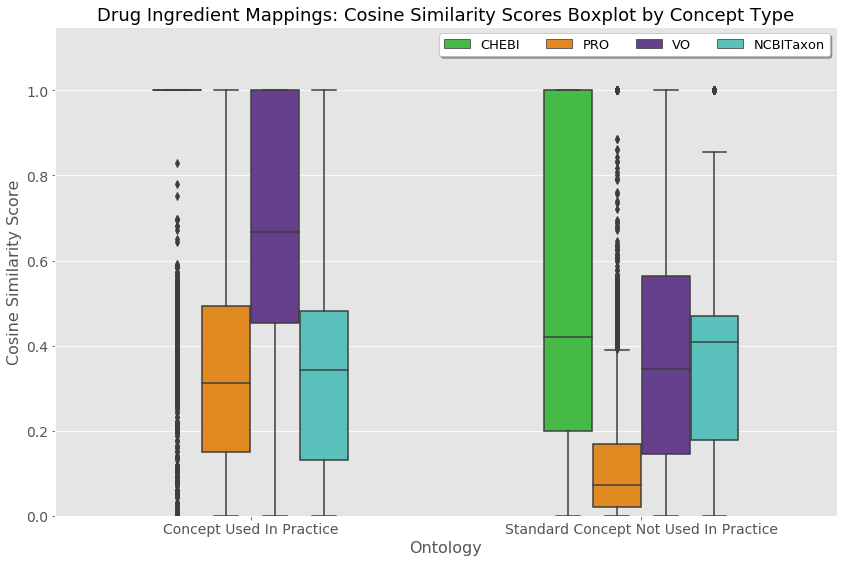

In [109]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='Similarity_Score', x='Concept_Type', hue='Ontology', data=med_sim_plot, width=0.5, palette=my_pal)
    
plt.title('Drug Ingredient Mappings: Cosine Similarity Scores Boxplot by Concept Type', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Cosine Similarity Score', fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(0, 1.15)
plt.legend(title='', fontsize=13, title_fontsize=12,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=4)
plt.show()

***

**Click [here](#drug-mapping-results) to return to the Drug Exposure Ingredient Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**

***

#### Final Mapping Set    <a class="anchor" id="dx-fullmapres"></a>   

***

- [Chemical Entities of Biological Interest](#dx-full-chebi)   
- [Protein Ontology](#dx-full-pro)   
- [Vaccine Ontology](#dx-full-vo)   
- [NCBI Organism Taxonomy Ontology](#dx-full-ncbi) 


*Concept Frequency*

Concept frequency is only calculated for concepts that are used in practice (`n=1,697`). As shown below, there are two ways that concept frequency has been calculated: (1) raw concept counts from the `OMOP` Drug Exposure table and (2) converting counts from the `OMOP` Drug Exposure table that occur fewer than 100 times to 100. The median raw count is `251` (min=`1`, max=`2,267,866`).


In [110]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Drugs']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
458,19123846,Drugs,1,100
459,42900069,Drugs,1,100
493,954853,Drugs,1,100
494,19136429,Drugs,1,100
495,715710,Drugs,1,100


In [111]:
min_score = min(chco_concept_counts['CONCEPT_COUNT'])
max_score = max(chco_concept_counts['CONCEPT_COUNT'])
median_score = statistics.median(chco_concept_counts['CONCEPT_COUNT'])

print('The median concept count is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median concept count is 251 (min: 1, max: 2267866)


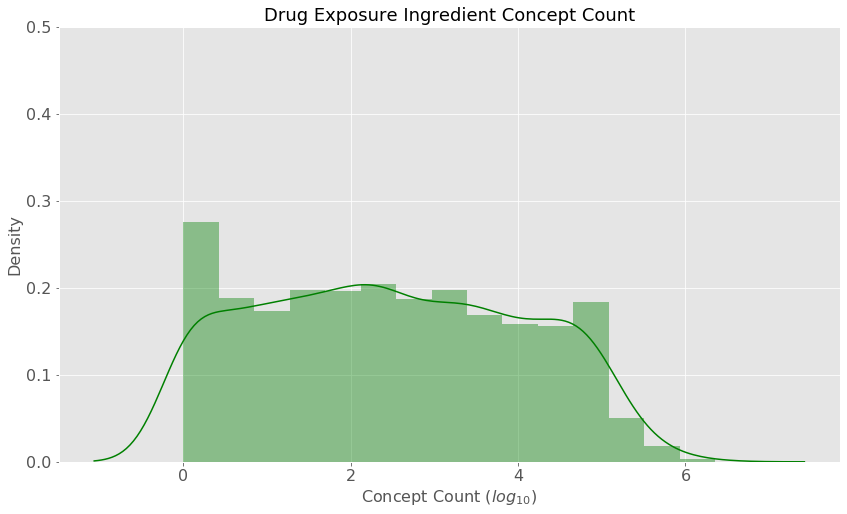

In [112]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
distplot = sns.distplot([math.log10(x) for x in list(chco_concept_counts['CONCEPT_COUNT'])], color='green')
    
plt.title('Drug Exposure Ingredient Concept Count', fontsize=18)
plt.suptitle('')
plt.xlabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.ylim(0, 0.5)
plt.tick_params(labelsize=16)
plt.show()


*Mapping Results*

In [113]:
# load mapping results
med_mappings = pd.read_excel(meds_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
med_mappings.fillna('', inplace=True)

# merge concept counts
med_mappings = med_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# view data
med_mappings.head(n=5)


,CONCEPT_TYPE,CONCEPT_ID,STANDARD_CONCEPT,CONCEPT_LABEL,UMLS_CUI,UMLS_SEM_TYPE,CHEBI_LOGIC,CHEBI_URI,CHEBI_LABEL,CHEBI_MAPPING,...,PR_MAPPING,PR_EVIDENCE,VO_LOGIC,VO_URI,VO_LABEL,VO_MAPPING,VO_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,Concept Used In Practice,501343,S,hepatitis B immune globulin,C0062525,"Amino Acid, Peptide, or Protein | Pharmacologi...",,CHEBI_60816,immunogen,Manual,...,Manual,Hand Mapping,,VO_0010781,hepatitis b virus protein,Manual,Hand Mapping,Drugs,145.0,145.0
1,Concept Used In Practice,507832,S,Human herpesvirus 3,C0042338,Virus,,CHEBI_60816,immunogen,Manual,...,Manual,Hand Mapping,,VO_0000729,herpes simplex virus vaccine,Manual,Hand Mapping,Drugs,12912.0,12912.0
2,Concept Used In Practice,509079,S,meningococcal group A polysaccharide,C0065942,Organic Chemical | Pharmacologic Substance | I...,AND,CHEBI_65212 | CHEBI_60816,polysaccharide derivative | immunogen,Manual Constructor,...,Manual,Expert Reviewed Mapping | Hand Mapping,,VO_0004888,meningococcal group a polysaccharide,Automatic Exact - Concept,OBO_LABEL-OMOP_CONCEPT_LABEL:meningococcal_gro...,Drugs,93.0,100.0
3,Concept Used In Practice,509081,S,meningococcal group C polysaccharide,C0065944,Organic Chemical | Pharmacologic Substance | I...,AND,CHEBI_65212 | CHEBI_60816,polysaccharide derivative | immunogen,Manual Constructor,...,Manual,Hand Mapping,,VO_0004859,meningococcal group c polysaccharide,Automatic Exact - Concept,OBO_LABEL-OMOP_ANCESTOR_LABEL:meningococcal_gr...,Drugs,93.0,100.0
4,Concept Used In Practice,514012,S,MENINGOCOCCAL POLYSACCHARIDE VACCINE GROUP W-135,C0982275,Organic Chemical | Pharmacologic Substance | I...,AND,CHEBI_65212 | CHEBI_60816,polysaccharide derivative | immunogen,Manual Constructor,...,Manual,Hand Mapping,,VO_0004886,meningococcal polysaccharide vaccine group w-135,Automatic Exact - Concept,OBO_LABEL-OMOP_ANCESTOR_LABEL:meningococcal_po...,Drugs,93.0,100.0


In [114]:
# split results by ontology
med_mappings_stacked = reconfigures_dataframe(ingredient_onts, med_mappings)

# split stacked data by concept type
med_mappings_ont_data = med_mappings_stacked.groupby('CATEGORY')


*UMLS Semantic Type*

In [115]:
# cui counts
med_map_cui_coverage = len([x for x in list(med_mappings_stacked['UMLS_CUI']) if x != 'NO CONCEPT-LEVEL CUI'])
med_map_cui_total = [x.strip() for y in list(med_mappings_stacked['UMLS_CUI']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI']
med_map_cui_unq = set(med_map_cui_total)

# umls semantic type
med_map_semantic_type = set([x.strip() for y in list(med_mappings_stacked['UMLS_SEM_TYPE']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI'])

cui1 = 'UMLS CUIs were found for {} clinical concepts ({} total CUIs; {} unique CUIs)'.format(med_map_cui_coverage,
                                                                                             len(med_map_cui_total),
                                                                                             len(med_map_cui_unq))
cui2 = '\nThe mapped CUIs represented {} unique Semantic Types'.format(len(med_map_semantic_type))

print(cui1, cui2)


UMLS CUIs were found for 46864 clinical concepts (46864 total CUIs; 11716 unique CUIs) 
The mapped CUIs represented 23 unique Semantic Types


In [116]:
# get needed data
med_mapping_results = process_mapping_results(med_mappings, ingredient_onts, 'CONCEPT_TYPE')

# re-group by ontology
med_mapping_results_chebi = med_mapping_results['CHEBI']
med_mapping_results_pr = med_mapping_results['PR']
med_mapping_results_vo = med_mapping_results['VO']
med_mapping_results_ncbitaxon = med_mapping_results['NCBITAXON']


Processing Ontology: CHEBI
Processing Ontology: PR
Processing Ontology: NCBITAXON
Processing Ontology: VO


<br>

***Chemical Entities of Biological Interest Results***  <a class="anchor" id="dx-full-chebi"></a>  

Summarizing the results shown below, there were a total of `1,697` `Concepts Used in Practice` and `2,718` `Standard RxNorm Concepts Not Used in Practice` that mapped to at least 1 `CHEBI` concept (not including `Unmapped` concepts). UMLS CUIs were found for `46,864` clinical concepts (`46,864` total CUIs, `11,716` unique CUIs) representing `23` unique Semantic Types.

**Concepts Used in Clinical Practice**  
- `1,697` ontology concepts were mapped to `2,555` OMOP concepts (`1.506` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `959` concept-level, `17` ancestor-level  
  - Automatic Constructor (1:Many): `235` concept-level, `61` ancestor-level 
  - Manual: `318` Concept Similarity, `31` Exact, `76` Constructor  
  - UnMapped: `0` 
  
- *Mapping Evidence*   
  - `118,582` sources of (`3,462` unique)  
  - `957` were from dbXRefs (`813` unique identifier types)  
  - `4,567` were from synonyms (7 unique combinations), covering `2` OBO synonym types   
  - `5,578` were from labels (`7` unique combinations)  
  - `1,352` were from similarity (`1.0` median, `0.257` min, `1.0` max)


**Standard RxNorm Concepts Not Used in Practice**  
- `2,718` ontology concepts were mapped to `3,307` OMOP concepts (`1.217` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `2,192` concept-level, `130` ancestor-level  
  - Automatic Constructor (1:Many): `169` concept-level, `149` ancestor-level 
  - Manual: `78` Concept Similarity   
  - UnMapped: `7,392` Not Yet Mapped  
  
- *Mapping Evidence*   
  - `29,798` sources of (`5,768` unique)  
  - `759` were from dbXRefs (540 unique identifier types)  
  - `7,732` were from synonyms (7 unique combinations), covering `2` OBO synonym types. 
  - `9,676` were from labels (`7` unique combinations)  
  - `2,562` were from similarity (`1.0` median, `0.259` min, `1.0` max)

CONCEPTS USED IN PRACTICE

In [117]:
# split data into concept type sets
med_chebi_map_prac = med_mapping_results_chebi['Concept Used In Practice']['data']

med_res = med_chebi_map_prac[med_chebi_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
chebi_prac_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(chebi_prac_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(chebi_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


1697 OMOP Concepts Used in practice with at least 1 ontology mapping
1697 ontology concepts were mapped to 2555 OMOP concepts (1.506 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [118]:
# mapping category
chebi_med_prac_map_categories = med_chebi_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
chebi_med_map_prac_unmapped = med_chebi_map_prac[med_chebi_map_prac['CATEGORY_MAPPING'] =='Unmapped']
chebi_med_map_prac_unmapped_types = chebi_med_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in chebi_med_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:{}'.format('No Unmapped Concepts')

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=61)
  - Automatic Constructor - Concept (n=235)
  - Automatic Exact - Ancestor (n=17)
  - Automatic Exact - Concept (n=959)
  - Manual (n=318)
  - Manual Constructor (n=76)
  - Manual Exact - Concept Similarity (n=31) 

Unmapped reasons:No Unmapped Concepts


In [119]:
# concept frequency by mapping type 
med_chebi_map_prac_valid = med_chebi_map_prac[med_chebi_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
med_chebi_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(med_chebi_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
med_chebi_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
med_chebi_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                   
                                            min        max  median
CATEGORY_MAPPING                                                  
Automatic Constructor - Ancestor            1.0   193286.0    50.5
Automatic Constructor - Concept             1.0   845160.0  1858.0
Automatic Exact - Ancestor                 11.0   130527.0  3300.0
Automatic Exact - Concept                   1.0  2267866.0   295.0
Manual                                      1.0   119010.0    48.0
Manual Constructor                          1.0    16650.0  1438.5
Manual Exact - Concept Similarity           1.0    16618.0    35.0

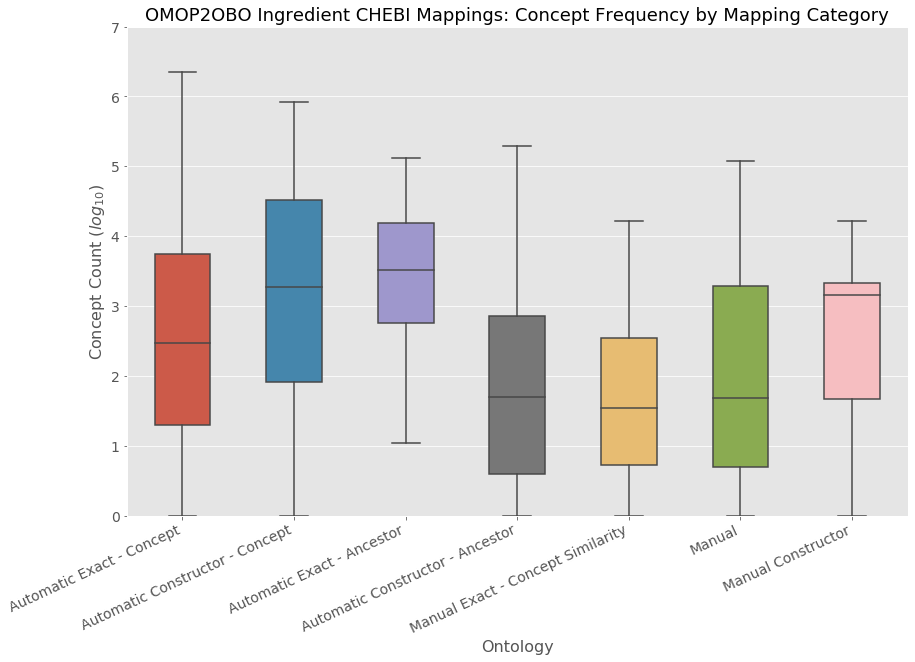

In [120]:
# get log of counts to improve plotting
med_chebi_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(med_chebi_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=med_chebi_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.ylim(0, 7)
plt.title('OMOP2OBO Ingredient CHEBI Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [121]:
# parses evidence
med_chebi_map_evidence = process_mapping_evidence(list(med_chebi_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_chebi_map_evidence['all']), len(set(med_chebi_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_chebi_map_evidence['dbxref']), len(set(med_chebi_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_chebi_map_evidence['synonym']),
                                                                                                      len(set(med_chebi_map_evidence['synonym'])),
                                                                                                      len(med_chebi_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_chebi_map_evidence['label']), len(set(med_chebi_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_chebi_map_evidence['similarity']),
                                                                                         statistics.median(med_chebi_map_evidence['similarity']),
                                                                                         min(med_chebi_map_evidence['similarity']),
                                                                                         max(med_chebi_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 18582 (3462 unique) pieces of evidence 
Among the evidence, 957 were from dbXRefs (813 unique) 
Among the evidence, 4567 were from synonyms (7 unique), covering 2 OBO synonym types 
Among the evidence, 5578 were from labels (7 unique) 
Among the evidence, 1352 were from similarity (1.0 median, 0.257 min, 1.0 max)


STANDARD RXNORM CONCEPTS NOT USED IN PRACTICE

In [122]:
# split data into concept type sets
med_chebi_map_stnd = med_mapping_results_chebi['Standard Concept Not Used In Practice']['data']

med_res = med_chebi_map_stnd[med_chebi_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
chebi_stnd_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(chebi_stnd_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(chebi_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


2718 OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping
2718 ontology concepts were mapped to 3307 OMOP concepts (1.217 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [123]:
# mapping category
med_chebi_map_stnd_categories = med_chebi_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_chebi_map_stnd_unmapped = med_chebi_map_stnd[med_chebi_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
med_chebi_map_stnd_unmapped_types = med_chebi_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_chebi_map_stnd_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_chebi_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=149)
  - Automatic Constructor - Concept (n=169)
  - Automatic Exact - Ancestor (n=130)
  - Automatic Exact - Concept (n=2192)
  - Manual Exact - Concept Similarity (n=78)
  - Unmapped (n=7392) 

Unmapped reasons:
  - NOT YET MAPPED (n=7392)


*Mapping Evidence*

In [124]:
# parses evidence
med_chebi_map_stnd_valid = med_chebi_map_stnd[med_chebi_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
med_chebi_map_evidence = process_mapping_evidence(list(med_chebi_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_chebi_map_evidence['all']), len(set(med_chebi_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_chebi_map_evidence['dbxref']), len(set(med_chebi_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_chebi_map_evidence['synonym']),
                                                                                                      len(set(med_chebi_map_evidence['synonym'])),
                                                                                                      len(med_chebi_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_chebi_map_evidence['label']), len(set(med_chebi_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_chebi_map_evidence['similarity']),
                                                                                         statistics.median(med_chebi_map_evidence['similarity']),
                                                                                         min(med_chebi_map_evidence['similarity']),
                                                                                         max(med_chebi_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 29798 (5768 unique) pieces of evidence 
Among the evidence, 759 were from dbXRefs (540 unique) 
Among the evidence, 7732 were from synonyms (7 unique), covering 2 OBO synonym types 
Among the evidence, 9676 were from labels (7 unique) 
Among the evidence, 2562 were from similarity (1.0 median, 0.259 min, 1.0 max)


<br>

***Protein Ontology Results*** <a class="anchor" id="dx-full-pro"></a>  

Summarizing the results shown below, there were a total of `245` `Concepts Used in Practice` and `72` `Standard RxNorm Concepts Not Used in Practice` that mapped to at least 1 `PRO` concept (not including `Unmapped` concepts). UMLS CUIs were found for `46,864` clinical concepts (`46,864` total CUIs, `11,716` unique CUIs) representing `23` unique Semantic Types.

**Concepts Used in Clinical Practice**  
- `245` ontology concepts were mapped to `270` OMOP concepts (`1.102` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `7` concept-level, `5` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `3` ancestor-level 
  - Manual: `214` Concept Similarity, `9` Exact, `7` Constructor  
  - UnMapped: `1,425` 
  
- *Mapping Evidence*   
  - `357` sources of (`40` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `26` were from synonyms (`8` unique combinations), covering `3` OBO synonym types   
  - `25` were from labels (`8` unique combinations)  
  - `16` were from similarity (`0.906` median, `0.348` min, `1.0` max)


**Standard RxNorm Concepts Not Used in Practice**    
- `72` ontology concepts were mapped to `73` OMOP concepts (`1.014` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `42` concept-level, `19` ancestor-level  
  - Automatic Constructor (1:Many): `1` concept-level, `0` ancestor-level 
  - Manual: `10` Concept Similarity   
  - UnMapped: `10,038` Not Yet Mapped  
  
- *Mapping Evidence*   
  - `408` sources of (`114` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `94` were from synonyms (`10` unique combinations), covering `3` OBO synonym types. 
  - `132` were from labels (`9` unique combinations)  
  - `54` were from similarity (`1.0` median, `0.623` min, `1.0` max)

CONCEPTS USED IN PRACTICE

In [125]:
# split data into concept type sets
med_pr_map_prac = med_mapping_results_pr['Concept Used In Practice']['data']

med_res = med_pr_map_prac[med_pr_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
pr_prac_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(pr_prac_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(pr_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


242 OMOP Concepts Used in practice with at least 1 ontology mapping
242 ontology concepts were mapped to 266 OMOP concepts (1.099 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [126]:
# mapping category
pr_med_prac_map_categories = med_pr_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_pr_map_prac_unmapped = med_pr_map_prac[med_pr_map_prac['CATEGORY_MAPPING'] =='Unmapped']
med_pr_map_prac_unmapped_types = med_pr_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in pr_med_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_pr_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=2)
  - Automatic Exact - Ancestor (n=5)
  - Automatic Exact - Concept (n=6)
  - Manual (n=213)
  - Manual Constructor (n=7)
  - Manual Exact - Concept Similarity (n=9)
  - Unmapped (n=1455) 

Unmapped reasons:
  - NONE (n=1455)


In [127]:
# concept frequency by mapping type 
med_pr_map_prac_valid = med_pr_map_prac[med_pr_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
med_pr_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(med_pr_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
med_pr_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
med_pr_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                 
                                            min      max  median
CATEGORY_MAPPING                                                
Automatic Constructor - Ancestor           58.0    805.0   431.5
Automatic Exact - Ancestor                 18.0  53492.0   686.0
Automatic Exact - Concept                   1.0   2085.0    10.0
Manual                                      1.0  82664.0  1315.0
Manual Constructor                          1.0    144.0     3.0
Manual Exact - Concept Similarity           1.0  41374.0    67.0

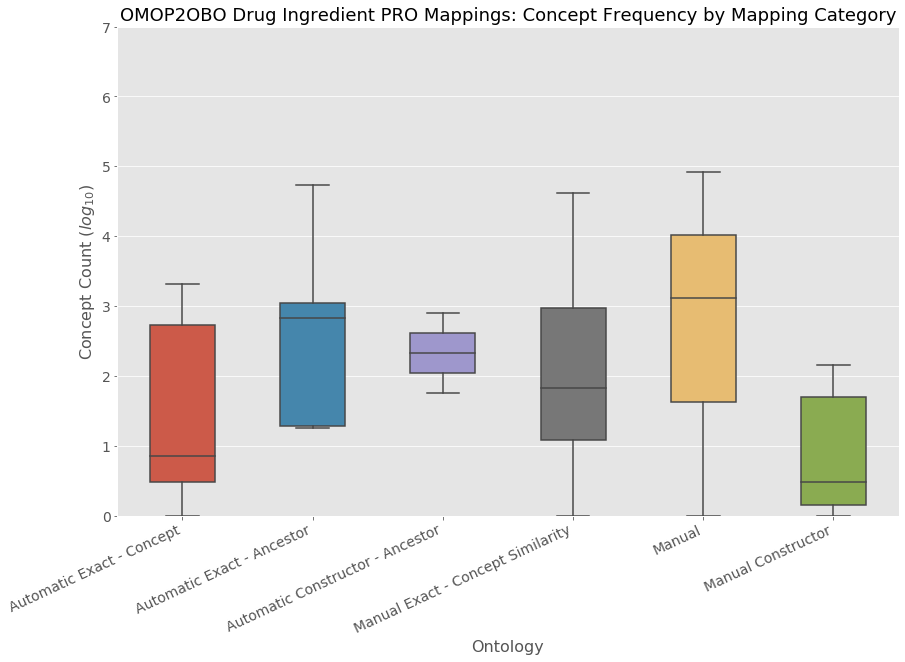

In [128]:
# get log of counts to improve plotting
med_pr_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(med_pr_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=med_pr_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Drug Ingredient PRO Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylim(0, 7)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [129]:
# parses evidence
med_pr_map_evidence = process_mapping_evidence(list(med_pr_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_pr_map_evidence['all']), len(set(med_pr_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_pr_map_evidence['dbxref']), len(set(med_pr_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_pr_map_evidence['synonym']),
                                                                                                      len(set(med_pr_map_evidence['synonym'])),
                                                                                                      len(med_pr_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_pr_map_evidence['label']), len(set(med_pr_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_pr_map_evidence['similarity']),
                                                                                         statistics.median(med_pr_map_evidence['similarity']),
                                                                                         min(med_pr_map_evidence['similarity']),
                                                                                         max(med_pr_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 346 (39 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 22 were from synonyms (8 unique), covering 3 OBO synonym types 
Among the evidence, 22 were from labels (8 unique) 
Among the evidence, 15 were from similarity (0.812 median, 0.348 min, 1.0 max)


STANDARD RXNORM CONCEPTS NOT USED IN PRACTICE

In [130]:
# split data into concept type sets
med_pr_map_stnd = med_mapping_results_pr['Standard Concept Not Used In Practice']['data']

med_res = med_pr_map_stnd[med_pr_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
pr_stnd_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(pr_stnd_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(pr_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


72 OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping
72 ontology concepts were mapped to 73 OMOP concepts (1.014 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [131]:
# mapping category
pr_med_stnd_map_categories = med_pr_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_pr_map_stnd_unmapped = med_pr_map_stnd[med_pr_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
med_pr_map_stnd_unmapped_types = med_pr_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in pr_med_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_pr_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Concept (n=1)
  - Automatic Exact - Ancestor (n=19)
  - Automatic Exact - Concept (n=42)
  - Manual Exact - Concept Similarity (n=10)
  - Unmapped (n=10038) 

Unmapped reasons:
  - NOT YET MAPPED (n=10038)


In [132]:
# parses evidence
med_pr_map_stnd_valid = med_pr_map_stnd[med_pr_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
med_pr_map_evidence = process_mapping_evidence(list(med_pr_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_pr_map_evidence['all']), len(set(med_pr_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_pr_map_evidence['dbxref']), len(set(med_pr_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_pr_map_evidence['synonym']),
                                                                                                      len(set(med_pr_map_evidence['synonym'])),
                                                                                                      len(med_pr_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_pr_map_evidence['label']), len(set(med_pr_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_pr_map_evidence['similarity']),
                                                                                         statistics.median(med_pr_map_evidence['similarity']),
                                                                                         min(med_pr_map_evidence['similarity']),
                                                                                         max(med_pr_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 408 (114 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 94 were from synonyms (10 unique), covering 3 OBO synonym types 
Among the evidence, 132 were from labels (9 unique) 
Among the evidence, 54 were from similarity (1.0 median, 0.623 min, 1.0 max)


<br>

***Vaccine Ontology Results***  <a class="anchor" id="dx-full-vo"></a>   

Summarizing the results shown below, there were a total of `125` `Concepts Used in Practice` and `36` `Standard RxNorm Concepts Not Used in Practice` that mapped to at least 1 `VO` concept (not including `Unmapped` concepts). UMLS CUIs were found for `46,864` clinical concepts (`46,864` total CUIs, `11,716` unique CUIs) representing `23` unique Semantic Types.

**Concepts Used in Clinical Practice**  
- `125` ontology concepts were mapped to `131` OMOP concepts (`1.048` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `92` concept-level, `0` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `2` ancestor-level 
  - Manual: `24` Concept Similarity, `5` Exact, `2` Constructor  
  - UnMapped: `1,572` 
  
- *Mapping Evidence*   
  - `806` sources of (`198` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `92` were from synonyms (`1` unique combinations), covering `0` OBO synonym types   
  - `282` were from labels (`3` unique combinations)  
  - `100` were from similarity (`1.0` median, `0.356` min, `1.0` max)


**Standard RxNorm Concepts Not Used in Practice**    
- `36` ontology concepts were mapped to `36` OMOP concepts (`1.0` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `18` concept-level, `0` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `4` ancestor-level 
  - Manual: `14` Concept Similarity   
  - UnMapped: `10,074` Not Yet Mapped  
  
- *Mapping Evidence*   
  - `180` sources of (`55` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `18` were from synonyms (`1` unique combinations), covering `0` OBO synonym types. 
  - `97,920` were from labels (`3` unique combinations)  
  - `32` were from similarity (`0.786` median, `0.346` min, `1.0` max)

CONCEPTS USED IN PRACTICE

In [133]:
# split data into concept type sets
med_vo_map_prac = med_mapping_results_vo['Concept Used In Practice']['data']

med_res = med_vo_map_prac[med_vo_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
vo_prac_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(vo_prac_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(vo_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


126 OMOP Concepts Used in practice with at least 1 ontology mapping
126 ontology concepts were mapped to 132 OMOP concepts (1.048 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [134]:
# mapping category
med_vo_map_prac_categories = med_vo_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_vo_map_prac_unmapped = med_vo_map_prac[med_vo_map_prac['CATEGORY_MAPPING'] =='Unmapped']
med_vo_map_prac_unmapped_types = med_vo_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_vo_map_prac_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_vo_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=2)
  - Automatic Exact - Concept (n=92)
  - Manual (n=25)
  - Manual Constructor (n=2)
  - Manual Exact - Concept Similarity (n=5)
  - Unmapped (n=1571) 

Unmapped reasons:
  - NONE (n=1571)


In [135]:
# concept frequency by mapping type 
med_vo_map_prac_valid = med_vo_map_prac[med_vo_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
med_vo_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(med_vo_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
med_vo_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
med_vo_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                  
                                            min      max   median
CATEGORY_MAPPING                                                 
Automatic Constructor - Ancestor         5178.0  57988.0  31583.0
Automatic Exact - Concept                   1.0  82664.0   4072.0
Manual                                      1.0  69311.0    920.0
Manual Constructor                          1.0  28795.0  14398.0
Manual Exact - Concept Similarity          22.0   9507.0    920.0

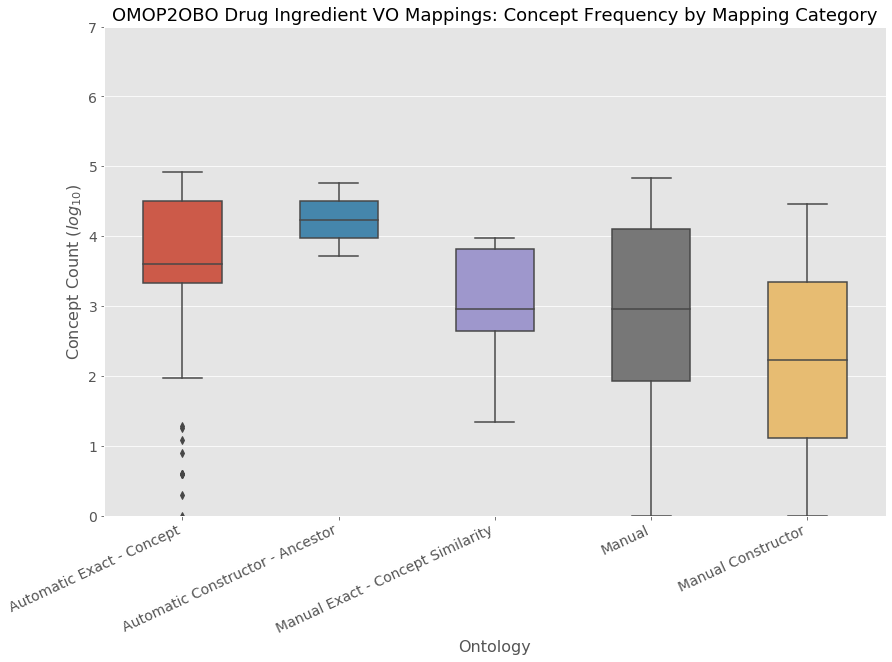

In [136]:
# get log of counts to improve plotting
med_vo_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(med_vo_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=med_vo_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Drug Ingredient VO Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylim(0, 7)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [137]:
# parses evidence
med_vo_map_evidence = process_mapping_evidence(list(med_vo_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_vo_map_evidence['all']), len(set(med_vo_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_vo_map_evidence['dbxref']), len(set(med_vo_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_vo_map_evidence['synonym']),
                                                                                                      len(set(med_vo_map_evidence['synonym'])),
                                                                                                      len(med_vo_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_vo_map_evidence['label']), len(set(med_vo_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_vo_map_evidence['similarity']),
                                                                                         statistics.median(med_vo_map_evidence['similarity']),
                                                                                         min(med_vo_map_evidence['similarity']),
                                                                                         max(med_vo_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 807 (198 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 92 were from synonyms (1 unique), covering 0 OBO synonym types 
Among the evidence, 282 were from labels (3 unique) 
Among the evidence, 100 were from similarity (1.0 median, 0.356 min, 1.0 max)


STANDARD RXNORM CONCEPTS NOT USED IN PRACTICE

In [138]:
# split data into concept type sets
med_vo_map_stnd = med_mapping_results_vo['Standard Concept Not Used In Practice']['data']

med_res = med_vo_map_stnd[med_vo_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
vo_stnd_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(vo_stnd_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(vo_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


36 OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping
36 ontology concepts were mapped to 36 OMOP concepts (1.0 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [139]:
# mapping category
med_vo_map_stnd_map_categories = med_vo_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_vo_map_stnd_unmapped = med_vo_map_stnd[med_vo_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
med_vo_map_stnd_unmapped_types = med_vo_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_vo_map_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_vo_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=4)
  - Automatic Exact - Concept (n=18)
  - Manual Exact - Concept Similarity (n=14)
  - Unmapped (n=10074) 

Unmapped reasons:
  - NOT YET MAPPED (n=10074)


*Mapping Evidence*

In [140]:
# parses evidence
med_vo_map_stnd_valid = med_vo_map_stnd[med_vo_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
med_vo_map_evidence = process_mapping_evidence(list(med_vo_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_vo_map_evidence['all']), len(set(med_vo_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_vo_map_evidence['dbxref']), len(set(med_vo_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_vo_map_evidence['synonym']),
                                                                                                      len(set(med_vo_map_evidence['synonym'])),
                                                                                                      len(med_vo_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(cond_hp_map_evidence['label']), len(set(med_vo_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_vo_map_evidence['similarity']),
                                                                                         statistics.median(med_vo_map_evidence['similarity']),
                                                                                         min(med_vo_map_evidence['similarity']),
                                                                                         max(med_vo_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 180 (55 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 18 were from synonyms (1 unique), covering 0 OBO synonym types 
Among the evidence, 97920 were from labels (3 unique) 
Among the evidence, 32 were from similarity (0.7855000000000001 median, 0.346 min, 1.0 max)


<br>

***NCBI Organism Taxonomy Ontology Results***  <a class="anchor" id="dx-full-ncbi"></a>     

Summarizing the results shown below, there were a total of `463` `Concepts Used in Practice` and `4,256` `Standard NCBITaxon Concepts Not Used in Practice` that mapped to at least 1 `VO` concept (not including `Unmapped` concepts). UMLS CUIs were found for `46,864` clinical concepts (`46,864` total CUIs, `11,716` unique CUIs) representing `23` unique Semantic Types.

**Concepts Used in Clinical Practice**  
- `463` ontology concepts were mapped to `485` OMOP concepts (`1.048` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `20` concept-level, `22` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `2` ancestor-level 
  - Manual: `271` Concept Similarity, `136` Exact, `12` Constructor  
  - UnMapped: `1,234` 
  
- *Mapping Evidence*   
  - `826` sources of (`193` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `59` were from synonyms (`7` unique combinations), covering `2` OBO synonym types   
  - `71` were from labels (`7` unique combinations)  
  - `160` were from similarity (`0.575` median, `0.257` min, `1.0` max)


**Standard SNOMED-CT Concepts**   
- `4,256` ontology concepts were mapped to `4,258` OMOP concepts (`1.0` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `135` concept-level, `14` ancestor-level  
  - Automatic Constructor (1:Many): `1` concept-level, `1` ancestor-level 
  - Manual: `4,105` Concept Similarity 
  - UnMapped: `5,584` Not Yet Mapped  
  
- *Mapping Evidence*   
  - `9,322` sources of (`4,276` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `199` were from synonyms (`7` unique combinations), covering `2` OBO synonym types. 
  - `391` were from labels (`7` unique combinations)  
  - `4,241` were from similarity (`0.586` median, `0.25` min, `1.0` max)
  

CONCEPTS USED IN PRACTICE

In [141]:
# split data into concept type sets
med_ncbitaxon_map_prac = med_mapping_results_ncbitaxon['Concept Used In Practice']['data']

med_res = med_ncbitaxon_map_prac[med_ncbitaxon_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
ncbi_prac_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(ncbi_prac_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(ncbi_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


466 OMOP Concepts Used in practice with at least 1 ontology mapping
466 ontology concepts were mapped to 488 OMOP concepts (1.047 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [142]:
# mapping category
ncbitaxon_med_prac_map_categories = med_ncbitaxon_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_ncbitaxon_map_prac_unmapped = med_ncbitaxon_map_prac[med_ncbitaxon_map_prac['CATEGORY_MAPPING'] =='Unmapped']
med_ncbitaxon_map_prac_unmapped_types = med_ncbitaxon_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in ncbitaxon_med_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_ncbitaxon_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=2)
  - Automatic Exact - Ancestor (n=22)
  - Automatic Exact - Concept (n=20)
  - Manual (n=274)
  - Manual Constructor (n=12)
  - Manual Exact - Concept Similarity (n=136)
  - Unmapped (n=1231) 

Unmapped reasons:
  - NONE (n=1231)


In [143]:
# concept frequency by mapping type 
ncbitaxon_med_map_prac_valid = med_ncbitaxon_map_prac[med_ncbitaxon_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
ncbitaxon_med_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(ncbitaxon_med_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
ncbitaxon_med_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
ncbitaxon_med_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                     
                                            min        max    median
CATEGORY_MAPPING                                                    
Automatic Constructor - Ancestor           57.0     7643.0    3850.0
Automatic Exact - Ancestor                  1.0   121017.0  100675.5
Automatic Exact - Concept                   1.0   119372.0       8.0
Manual                                      1.0  2267866.0     440.0
Manual Constructor                          1.0   107569.0      44.0
Manual Exact - Concept Similarity           1.0   119010.0      22.0

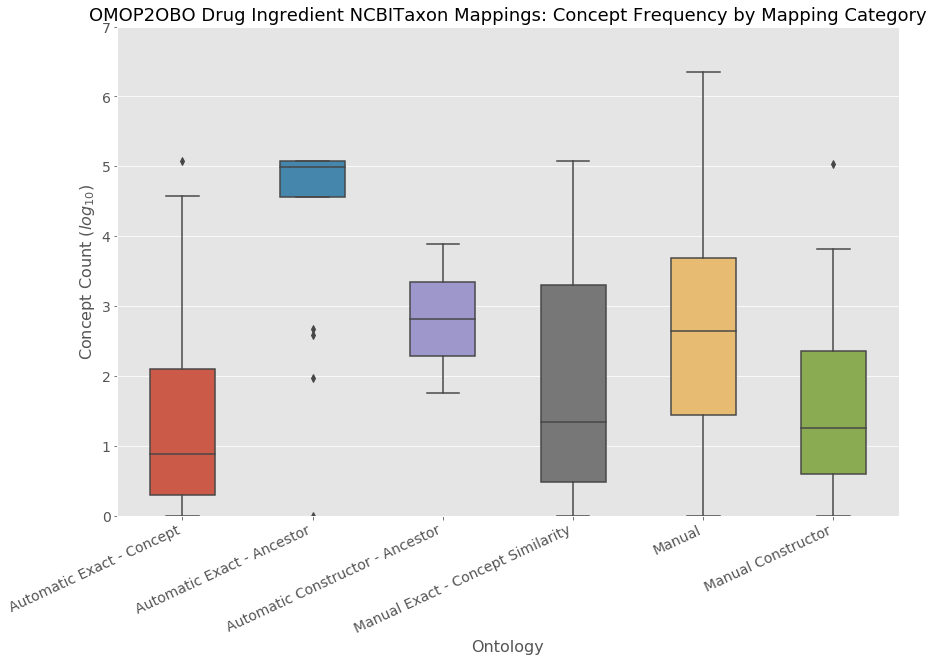

In [144]:
# get log of counts to improve plotting
ncbitaxon_med_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(ncbitaxon_med_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=ncbitaxon_med_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Drug Ingredient NCBITaxon Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylim(0, 7)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [145]:
# parses evidence
med_ncbitaxon_map_evidence = process_mapping_evidence(list(ncbitaxon_med_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_ncbitaxon_map_evidence['all']), len(set(med_ncbitaxon_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_ncbitaxon_map_evidence['dbxref']), len(set(med_ncbitaxon_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_ncbitaxon_map_evidence['synonym']),
                                                                                                      len(set(med_ncbitaxon_map_evidence['synonym'])),
                                                                                                      len(med_ncbitaxon_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_ncbitaxon_map_evidence['label']), len(set(med_ncbitaxon_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_ncbitaxon_map_evidence['similarity']),
                                                                                         statistics.median(med_ncbitaxon_map_evidence['similarity']),
                                                                                         min(med_ncbitaxon_map_evidence['similarity']),
                                                                                         max(med_ncbitaxon_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 829 (193 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 59 were from synonyms (7 unique), covering 2 OBO synonym types 
Among the evidence, 71 were from labels (7 unique) 
Among the evidence, 160 were from similarity (0.5754999999999999 median, 0.257 min, 1.0 max)


STANDARD RXNORM CONCEPTS NOT USED IN PRACTICE

In [146]:
# split data into concept type sets
med_ncbitaxon_map_stnd = med_mapping_results_ncbitaxon['Standard Concept Not Used In Practice']['data']

med_res = med_ncbitaxon_map_stnd[med_ncbitaxon_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping'.format(len(med_res)))

# get counts of ontologies mapped to each OMOP concepts
ncbi_stnd_concept_coverage = [x for y in med_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(ncbi_stnd_concept_coverage)/len(med_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(med_res),
                                                                                                                  len(ncbi_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


4256 OMOP Standard Concepts Not Used in practice with at least 1 ontology mapping
4256 ontology concepts were mapped to 4258 OMOP concepts (1.0 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [147]:
# mapping category
med_ncbitaxon_map_stnd_map_categories = med_ncbitaxon_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
med_ncbitaxon_map_stnd_unmapped = med_ncbitaxon_map_stnd[med_ncbitaxon_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
med_ncbitaxon_map_stnd_unmapped_types = med_ncbitaxon_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_ncbitaxon_map_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in med_ncbitaxon_map_stnd_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=1)
  - Automatic Constructor - Concept (n=1)
  - Automatic Exact - Ancestor (n=14)
  - Automatic Exact - Concept (n=135)
  - Manual Exact - Concept Similarity (n=4105)
  - Unmapped (n=5854) 

Unmapped reasons:
  - NOT YET MAPPED (n=5854)


*Mapping Evidence*

In [148]:
# parses evidence
med_ncbitaxon_map_stnd_valid = med_ncbitaxon_map_stnd[med_ncbitaxon_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
med_ncbitaxon_map_evidence = process_mapping_evidence(list(med_ncbitaxon_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(med_ncbitaxon_map_evidence['all']), len(set(med_ncbitaxon_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(med_ncbitaxon_map_evidence['dbxref']), len(set(med_ncbitaxon_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(med_ncbitaxon_map_evidence['synonym']),
                                                                                                      len(set(med_ncbitaxon_map_evidence['synonym'])),
                                                                                                      len(med_ncbitaxon_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(med_ncbitaxon_map_evidence['label']), len(set(med_ncbitaxon_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(med_ncbitaxon_map_evidence['similarity']),
                                                                                         statistics.median(med_ncbitaxon_map_evidence['similarity']),
                                                                                         min(med_ncbitaxon_map_evidence['similarity']),
                                                                                         max(med_ncbitaxon_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 9322 (4276 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 199 were from synonyms (7 unique), covering 2 OBO synonym types 
Among the evidence, 391 were from labels (7 unique) 
Among the evidence, 4241 were from similarity (0.586 median, 0.25 min, 1.0 max)


***

**Click [here](#drug-mapping-results) to return to the Drug Exposure Ingredient Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

### Measurements <a class="anchor" id="mapping-labs"></a>

***

**SQL Queries**  
- [x] CHCO Measurements Used in Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_measurements-sql))  
- [x] Standard LOINC2HPO Concepts Not Used In Practice ([`GitHub Gist`](https://gist.github.com/callahantiff/7b84c1bc063ad162bf5bdf5e578d402f#file-omopconcepts_measurements_loinc2hpo-sql))  


**Data Description:**  
Two types of data were combined prior to performing mapping on this domain. The first wave of data was pulled from `CHCO` and like with the condition and measurement domains, contains only those concepts that were used at least once in clinical practice. This set contained a total of `1,606` LOINC concepts or `4,425` lab test results (more information on how lab test results were identified below). The initial set of `CHCO` data were supplemented by adding the latest `LOINC2HPO` annotations. The current annotation set ([annotations.tsv](https://github.com/TheJacksonLaboratory/loinc2hpoAnnotation/blob/develop/Data/TSVSingleFile/annotations.tsv); last updated `06/07/2020`) was downloaded from the develop branch of the [LOINC2HPO GitHub repository](https://github.com/TheJacksonLaboratory/loinc2hpoAnnotation) on `08/12/2020`). Of the `3,119` unique codes obtained from `LOINC2HPO` (`7,421` unique results), `631` overlapped with the `OMOP` measurement terms retrieved from `CHCO` and were excluded. An additional `11` concepts were excluded due to being deprecated. The final set of processed terms included `2,477` unique LOINC concepts or `6,844` lab test results. 

*Identifying LOINC Scale and Result Type*  
All lab test scale types (i.e. ordinal, nominal, quantitative, qualitative, narrative, doc, and panel) were initially eligible to be mapped. The scale type of each lab test was identified by parsing the free-text text in the concept synonym field for the presence of any of the scale types listed above. Result type was identified using a two-step approach. First, we analyzed the reference ranges available in the patient data. If at least one numeric result was reported the result type was recorded as `Normal/Low/High` and if a `positive` or `negative` result was reported it was recorded as `Positive/Negative`. Then, for all lab tests without a reference range in the data, the result type was obtained by parsing the free-text in the concept synonym field. For all tests with an ordinal scale type, if the keywords `presence` or `screen` were identified, the result type was reported as `Positive/Negative`. All tests with a quantitative scale type were given the result type `Normal/Low/High`. All other scale types were annotated with `Unknown Result Type`. 


**CHCO Concepts Used in Practice:**
- <u>Scale types</u>: `1,320` quantitative, `192` ordinal, `66` nominal, `24` narratives, `2` panel, `1` document and `1` Other  
- <u>Result types</u>: `1,293` Normal/Low/High, `233` Negative/Positive, and `80` Unknown  
- <u>Concept-Level Results</u>: `1,606` source codes, `1,606` labels, and `41,891` synonyms using `LOINC` and `PEDSnet`   
- <u>Ancestor-Level Results</u>: `20,781` source codes and `21,191` labels using `LOINC`  

**LOINC2HPO Concepts:**  
- <u>Scale types</u>: `1,885` quantitative, `573` ordinal, `17` nominal, `1` narratives, and `1` panel
- <u>Result types</u>: `1,890` Normal/Low/High, `587` Negative/Positive
- <u>Concept-Level Results</u>: `2,477` source codes, `2,477` labels, and `73,612` synonyms using `LOINC`  
- <u>Ancestor-Level Results</u>: `23,457` source codes and `24,306` labels using `LOINC`  


**Ontology Data:**  
`OMOP` Measurement concept ids were mapped to:  
- Phenotypes ([Human Phenotype Ontology (HPO)](https://hpo.jax.org/)) 
- Anatomical entities ([Uber-Anatomy Ontology (UBERON)](http://uberon.org/))   
- Organisms ([NCBI Organism Taxonomy (NCBITaxon)](https://www.ncbi.nlm.nih.gov/taxonomy))  
- Proteins ([Protein Ontology (PRO)](https://proconsortium.org/))  
- Chemicals, hormones, and enzymes ([Chemical Entities of Biological Interest (CHEBI)](https://www.ebi.ac.uk/chebi/))
- Cells ([Cell Ontology (CL)](https://github.com/obophenotype/cell-ontology))  


#### MAPPING DATA   <a class="anchor" id="mapping-labs"></a>

In [149]:
# load data used for mapping
measurement_data = pd.read_csv(measurements, sep=',', header=0)
measurement_data.fillna('', inplace=True)

# view data
measurement_data.head()

,CONCEPT_TYPE,STANDARD_CONCEPT,CONCEPT_ID,CONCEPT_SOURCE_CODE,CONCEPT_LABEL,CONCEPT_VOCAB,CONCEPT_VOCAB_VERSION,CONCEPT_SYNONYM,ANCESTOR_CONCEPT_ID,ANCESTOR_SOURCE_CODE,ANCESTOR_LABEL,ANCESTOR_VOCAB,ANCESTOR_VOCAB_VERSION,SCALE,RESULT_TYPE
0,LOINC2HPO Concept,S,3039873,loinc:53133-5,Cholesterol in LDL [Moles/volume] in Body fluid,LOINC,LOINC 2.64,LDLc Fld-sCnc | B/F | BF | bod | Bodies | Body...,45876002 | 40772590 | 40789215 | 40783186 | 36...,loinc:CHEM | loinc:LP15493-7 | loinc:LP15705-4...,"Cholesterol | Lipids | Chemistry, challenge | ...",LOINC,LOINC 2.64,QUANT,Normal/Low/High
1,LOINC2HPO Concept,S,3008204,loinc:32167-9,Clarity of Urine,LOINC,LOINC 2.64,Clarity Ur | Clarity of Urine | Nominal | Poin...,45876058 | 40785809 | 3029361 | 36208195 | 300...,loinc:SPEC | loinc:LP14542-2 | loinc:50556-0 |...,Specimen characteristics | Appearance | Urinal...,LOINC,LOINC 2.64,NOM,Normal/Low/High
2,LOINC2HPO Concept,S,3008108,loinc:11153-4,Hematocrit [Volume Fraction] of Body fluid,LOINC,LOINC 2.64,Hematocrit [Volume Fraction] of Body fluid | H...,3008108 | 36208195 | 45876038 | 40792793 | 407...,loinc:11153-4 | loinc:LP248770-2 | loinc:PANEL...,Hematocrit [Volume Fraction] of Body fluid | L...,LOINC,LOINC 2.64,QUANT,Normal/Low/High
3,LOINC2HPO Concept,S,3043570,loinc:43964-6,CD4+CD45RA+ cells/100 cells in Body fluid,LOINC,LOINC 2.64,CD4+CD45RA+ Cells NFr Fld | CD4+CD45RA+ cells/...,45875999 | 40772860 | 40784400 | 3043570 | 407...,loinc:CELLMARK | loinc:LP21159-6 | loinc:LP529...,Cell surface models | CD4+CD45RA+ cells | CD4+...,LOINC,LOINC 2.64,QUANT,Normal/Low/High
4,LOINC2HPO Concept,S,3023923,loinc:19079-3,CD43 cells/100 cells in Unspecified specimen,LOINC,LOINC 2.64,CD43 cells/100 cells in Unspecified specimen |...,45875999 | 3023923 | 40786257 | 36206173 | 407...,loinc:CELLMARK | loinc:19079-3 | loinc:LP32737...,Cell surface models | CD43 cells/100 cells in ...,LOINC,LOINC 2.64,QUANT,Normal/Low/High


In [150]:
# get stats
total_concepts = len(measurement_data)

# split results by concept type (i.e. concepts used in practice, standard concepts)
lab_res = process_clinical_data(measurement_data, 'CONCEPT_TYPE') 

# get concept_type results
practice_concepts = lab_res['CHCO Concept Used In Practice']
not_practice_concepts = lab_res['LOINC2HPO Concept']


Processing Group: CHCO Concept Used In Practice
Processing Group: LOINC2HPO Concept


*CHCO Concepts Used in Practice*

In [151]:
# print concepts used in practice data
res1 = 'There were {} concepts used in practice that could be mapped'.format(len(practice_concepts['grp_full_data']))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(practice_concepts['concept_src_code']),
                                                                                               len(practice_concepts['concept_src_label']),
                                                                                               len(practice_concepts['concept_synonym']))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(practice_concepts['concept_vocab'])
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(practice_concepts['anc_concept_id']),
                                                                                                    len(practice_concepts['anc_src_code']),
                                                                                                    len(practice_concepts['anc_label']))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5)


There were 1606 concepts used in practice that could be mapped 
At the concept-level, there were 1606 source codes, 1606 labels, and 41891 synonyms 
Concept-level data came from the following vocabularies: LOINC, PEDSnet 

At the ancestor-level, there were 20781 concept ids, 20781 source codes and 21191 labels 
Ancestor-level data came from the following vocabularies: , LOINC


In [152]:
# get scale information
chco_concepts = len(set(practice_concepts['grp_full_data']['CONCEPT_ID']))
chco_scale_counts = practice_concepts['grp_full_data'].groupby(['SCALE']).size()
chco_result_type_counts = practice_concepts['grp_full_data'].groupby(['RESULT_TYPE']).size()

res1 = 'There are {} CHCO LOINC concepts'.format(chco_concepts)
res2 = '\nScale types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in chco_scale_counts.to_dict().items()]))
res3 = '\nResult types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in chco_result_type_counts.to_dict().items()]))

print(res1, res2, res3)

There are 1606 CHCO LOINC concepts 
Scale types: DOC (n=1), NAR (n=24), NOM (n=66), ORD (n=192), Other (n=1), PNL (n=2), QUANT (n=1320) 
Result types: Negative/Positive (n=233), Normal/Low/High (n=1293), Unknown Result Type (n=80)


*LOINC2HPO Concepts Not Used in Practice*

In [153]:
# print standard concepts not used in practice data
res1 = 'There were {} standard concepts not used in practice that could be mapped'.format(len(not_practice_concepts['grp_full_data']))
res2 = '\nAt the concept-level, there were {} source codes, {} labels, and {} synonyms'.format(len(not_practice_concepts['concept_src_code']),
                                                                                               len(not_practice_concepts['concept_src_label']),
                                                                                               len(not_practice_concepts['concept_synonym']))
res3 = '\nConcept-level data came from the following vocabularies: {}'.format(not_practice_concepts['concept_vocab'])
res4 = '\n\nAt the ancestor-level, there were {} concept ids, {} source codes and {} labels'.format(len(not_practice_concepts['anc_concept_id']),
                                                                                                    len(not_practice_concepts['anc_src_code']),
                                                                                                    len(not_practice_concepts['anc_label']))
res5 = '\nAncestor-level data came from the following vocabularies: {}'.format(not_practice_concepts['anc_vocab'])

print(res1, res2, res3, res4, res5)


There were 2477 standard concepts not used in practice that could be mapped 
At the concept-level, there were 2477 source codes, 2477 labels, and 73612 synonyms 
Concept-level data came from the following vocabularies: LOINC 

At the ancestor-level, there were 23457 concept ids, 23457 source codes and 24306 labels 
Ancestor-level data came from the following vocabularies: , LOINC


In [154]:
# get scale information
l2h_concepts = len(set(not_practice_concepts['grp_full_data']['CONCEPT_ID']))
l2h_scale_counts = not_practice_concepts['grp_full_data'].groupby(['SCALE']).size()
l2h_result_type_counts = not_practice_concepts['grp_full_data'].groupby(['RESULT_TYPE']).size()

res1 = 'There are {} CHCO LOINC concepts'.format(l2h_concepts)
res2 = '\nScale types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in l2h_scale_counts.to_dict().items()]))
res3 = '\nResult types: {}'.format(', '.join([k + ' (n=' + str(v) + ')' for k,v in l2h_result_type_counts.to_dict().items()]))

print(res1, res2, res3)


There are 2477 CHCO LOINC concepts 
Scale types: NAR (n=1), NOM (n=17), ORD (n=573), PNL (n=1), QUANT (n=1885) 
Result types: Negative/Positive (n=587), Normal/Low/High (n=1890)


***

**Click [here](#mapping-labs) to return to the Lab Measurement Data section**  
**Click [here](#toc) to return to the Table of Contents**

***

<br>

***

#### MAPPING RESULTS  <a class="anchor" id="lab-mapping-results"></a>
- [Database Cross-Reference](#lab-dbxref)  
- [Exact String Alignment](#lab-string)  
- [Cosine Similarity](#lab-cosine)   
- [Final Mapping Results](#lab-fullmapres)

***


#### Database Cross-Reference  <a class="anchor" id="lab-dbxref"></a>  

***

- [Human Phenotype Ontology](#lb-dbxref-hpo)   
- [Uber-Anatomy Ontology](#lb-dbxref-uberon)   
- [Chemical Entities of Biological Interest](#lb-dbxref-chebi) 
- [Cell Ontology](#lb-dbxref-cl)  


In [155]:
# load results from dbxref alignment
lab_dbxref = pd.read_excel(labs_mapping_url, sheet_name='DbXRef_Mapping_Results', sep=',', header=0)
lab_dbxref.fillna('', inplace=True)

# view data
lab_dbxref.head(n=5)


,CONCEPT_ID,CONCEPT_TYPE,CONCEPT_LABEL,SCALE,RESULT_TYPE,ANCESTOR_DBXREF_HP_URI,ANCESTOR_DBXREF_HP_LABEL,ANCESTOR_DBXREF_HP_EVIDENCE,ANCESTOR_DBXREF_CHEBI_URI,ANCESTOR_DBXREF_CHEBI_LABEL,ANCESTOR_DBXREF_CHEBI_EVIDENCE,ANCESTOR_DBXREF_CL_URI,ANCESTOR_DBXREF_CL_LABEL,ANCESTOR_DBXREF_CL_EVIDENCE,ANCESTOR_DBXREF_UBERON_URI,ANCESTOR_DBXREF_UBERON_LABEL,ANCESTOR_DBXREF_UBERON_EVIDENCE
0,3000059,LOINC2HPO Concept,Corticotropin [Mass/volume] in Plasma --4th sp...,QUANT,Normal,,,,CHEBI_3892,corticotropin,ANCESTOR_DBXREF_drugbank:db01285,,,,UBERON_0000949,endocrine system,ANCESTOR_DBXREF_fma:9668 | ANCESTOR_DBXREF_msh...
1,3000059,LOINC2HPO Concept,Corticotropin [Mass/volume] in Plasma --4th sp...,QUANT,Low,,,,CHEBI_3892,corticotropin,ANCESTOR_DBXREF_drugbank:db01285,,,,UBERON_0000949,endocrine system,ANCESTOR_DBXREF_fma:9668 | ANCESTOR_DBXREF_msh...
2,3000059,LOINC2HPO Concept,Corticotropin [Mass/volume] in Plasma --4th sp...,QUANT,High,,,,CHEBI_3892,corticotropin,ANCESTOR_DBXREF_drugbank:db01285,,,,UBERON_0000949,endocrine system,ANCESTOR_DBXREF_fma:9668 | ANCESTOR_DBXREF_msh...
3,3000066,LOINC2HPO Concept,Cortisol [Mass/volume] in Serum or Plasma --1 ...,QUANT,Normal,,,,CHEBI_17609,cortisol 21-acetate,ANCESTOR_DBXREF_drugbank:db00741,,,,UBERON_0000949,endocrine system,ANCESTOR_DBXREF_fma:9668 | ANCESTOR_DBXREF_msh...
4,3000066,LOINC2HPO Concept,Cortisol [Mass/volume] in Serum or Plasma --1 ...,QUANT,Low,,,,CHEBI_17609,cortisol 21-acetate,ANCESTOR_DBXREF_drugbank:db00741,,,,UBERON_0000949,endocrine system,ANCESTOR_DBXREF_fma:9668 | ANCESTOR_DBXREF_msh...


In [156]:
# get processed data for each ontology
lab_dbxref_results = process_mapping_results(lab_dbxref, measurement_onts, 'CONCEPT_TYPE', 'DBXREF')

# re-group by ontology
lab_dbxref_hp = lab_dbxref_results['HP']
lab_dbxref_chebi = lab_dbxref_results['CHEBI']
lab_dbxref_cl = lab_dbxref_results['CL']
lab_dbxref_uberon = lab_dbxref_results['UBERON']


Processing Ontology: HP
Processing Ontology: CHEBI
Processing Ontology: CL
Processing Ontology: UBERON


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="lb-dbxref-hpo"></a>    
Summarizing the results shown below, there were a total of `15` `OMOP` concepts that mapped to at least 1 `HP` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=10`)  
  - `0` `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts)  
  - `10` `OMOP` concepts mapped at the ancestor level to `10` ontology concepts (`4` unique ontology concepts)  
  

- LOINC2HPO Concepts Not Used in Practice (`n=5`)  
  - `0` `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts) 
  - `5` `OMOP` concepts mapped at the ancestor level to `5` ontology concepts (`1` unique ontology concepts)

In [157]:
print('{} OMOP concepts were mapped to at least 1 HP concept using DbXRefs'.format(len(lab_dbxref_hp['ont_data'])))


15 OMOP concepts were mapped to at least 1 HP concept using DbXRefs


*CHCO Concepts Used in Practice*

In [158]:
# process data
lab_hp_dbxref_prac = lab_dbxref_hp['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_hp_dbxref_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_hp_dbxref_prac['ancestors'][0]),
                                                                                                                                        len(lab_hp_dbxref_prac['ancestors'][1]),
                                                                                                                                        len(set(lab_hp_dbxref_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


10 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 10 concepts mapped at the ancestor level to 10 total ontology concepts (4 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [159]:
# process data
lab_hp_dbxref_stnd = lab_dbxref_hp['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept'.format(len(lab_hp_dbxref_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_hp_dbxref_stnd['ancestors'][0]),
                                                                                                                                 len(lab_hp_dbxref_stnd['ancestors'][1]),
                                                                                                                                 len(set(lab_hp_dbxref_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


5 LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 5 concepts mapped at the ancestor level to 5 total ontology concepts (1 unique)


<br>

***Uber-Anatomy Ontology Results*** <a class="anchor" id="lb-dbxref-uberon"></a>    
Summarizing the results shown below, there were a total of `1,326` `OMOP` concepts that mapped to at least 1 `UBERON` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=235`)  
  - `0 `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts)  
  - `235` `OMOP` concepts mapped at the ancestor level to `235` ontology concepts (`5` unique ontology concepts)  
  

- LOINC2HPO Concepts Not Used in Practice (`n=1,091`)  
  - `0` `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts) 
  - `1,091` `OMOP` concepts mapped at the ancestor level to `1,091` ontology concepts (`3` unique ontology concepts)

In [160]:
print('{} OMOP concepts were mapped to at least 1 UBERON concept using DbXRefs'.format(len(lab_dbxref_uberon['ont_data'])))


1326 OMOP concepts were mapped to at least 1 UBERON concept using DbXRefs


*CHCO Concepts Used in Practice*

In [161]:
# process data
lab_uberon_dbxref_prac = lab_dbxref_uberon['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_uberon_dbxref_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_uberon_dbxref_prac['ancestors'][0]),
                                                                                                                                        len(lab_uberon_dbxref_prac['ancestors'][1]),
                                                                                                                                        len(set(lab_uberon_dbxref_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


235 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 235 concepts mapped at the ancestor level to 235 total ontology concepts (5 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [162]:
# process data
lab_uberon_dbxref_stnd = lab_dbxref_uberon['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept'.format(len(lab_uberon_dbxref_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_uberon_dbxref_stnd['ancestors'][0]),
                                                                                                                                 len(lab_uberon_dbxref_stnd['ancestors'][1]),
                                                                                                                                 len(set(lab_uberon_dbxref_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)

1091 LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 1091 concepts mapped at the ancestor level to 1091 total ontology concepts (3 unique)


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="lb-dbxref-chebi"></a>    
Summarizing the results shown below, there were a total of `2,969` `OMOP` concepts that mapped to at least 1 `CHEBI` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=875`)  
  - `0 `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts)  
  - `875` `OMOP` concepts mapped at the ancestor level to `914` ontology concepts (`49` unique ontology concepts)  
  

- LOINC2HPO Concepts Not Used in Practice (`n=2,094`)  
  - `0` `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts) 
  - `2,094` `OMOP` concepts mapped at the ancestor level to `2,147` ontology concepts (`49` unique ontology concepts)

In [163]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using DbXRefs'.format(len(lab_dbxref_chebi['ont_data'])))


2969 OMOP concepts were mapped to at least 1 CHEBI concept using DbXRefs


*CHCO Concepts Used in Practice*

In [164]:
# process data
lab_chebi_dbxref_prac = lab_dbxref_chebi['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_chebi_dbxref_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_chebi_dbxref_prac['ancestors'][0]),
                                                                                                                                        len(lab_chebi_dbxref_prac['ancestors'][1]),
                                                                                                                                        len(set(lab_chebi_dbxref_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


875 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 875 concepts mapped at the ancestor level to 914 total ontology concepts (135 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [165]:
# process data
lab_chebi_dbxref_stnd = lab_dbxref_chebi['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept'.format(len(lab_chebi_dbxref_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_chebi_dbxref_stnd['ancestors'][0]),
                                                                                                                                 len(lab_chebi_dbxref_stnd['ancestors'][1]),
                                                                                                                                 len(set(lab_chebi_dbxref_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)



2094 LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 2094 concepts mapped at the ancestor level to 2147 total ontology concepts (49 unique)


<br>

***Cell Ontology Results*** <a class="anchor" id="lb-dbxref-cell"></a>    
Summarizing the results shown below, there were a total of `537` `OMOP` concepts that mapped to at least 1 `CL` concept using DbXRefs.  

- Concepts Used in Clinical Practice (`n=325`)  
  - `0 `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts)  
  - `325` `OMOP` concepts mapped at the ancestor level to `889` ontology concepts (`23` unique ontology concepts)  
  

- LOINC2HPO Concepts Not Used in Practice (`n=5`)  
  - `0` `OMOP` concepts mapped at the concept level to `0` ontology concepts (`0` unique ontology concepts) 
  - `212` `OMOP` concepts mapped at the ancestor level to `576` ontology concepts (`15` unique ontology concepts)

In [166]:
print('{} OMOP concepts were mapped to at least 1 CL concept using DbXRefs'.format(len(lab_dbxref_cl['ont_data'])))


537 OMOP concepts were mapped to at least 1 CL concept using DbXRefs


*CHCO Concepts Used in Practice*

In [167]:
# process data
lab_cl_dbxref_prac = lab_dbxref_cl['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_cl_dbxref_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_cl_dbxref_prac['ancestors'][0]),
                                                                                                                                        len(lab_cl_dbxref_prac['ancestors'][1]),
                                                                                                                                        len(set(lab_cl_dbxref_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


325 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 325 concepts mapped at the ancestor level to 889 total ontology concepts (23 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [168]:
# process data
lab_cl_dbxref_stnd = lab_dbxref_cl['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept'.format(len(lab_cl_dbxref_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(0, 0, 0)
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_cl_dbxref_stnd['ancestors'][0]),
                                                                                                                                 len(lab_cl_dbxref_stnd['ancestors'][1]),
                                                                                                                                 len(set(lab_cl_dbxref_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)



212 LOINC2HPO Concepts Not Used in Practice mapped to at least 1 Ontology concept 
  - 0 concepts mapped at the concept level to 0 total ontology concepts (0 unique) 
  - 212 concepts mapped at the ancestor level to 576 total ontology concepts (15 unique)


***

**Click [here](#lab-mapping-results) to return to the Lab Measurement section**  

***

#### Exact String Alignment  <a class="anchor" id="lab-string"></a>  

***

- [Human Phenotype Ontology](#lb-string-hpo)   
- [Uber-Anatomy Ontology](#lb-string-uberon)   
- [NCBI Organism Taxonomy](#lb-string-ncbi) 
- [Protein Ontology](#lb-string-pro) 
- [Chemical Entities of Biological Interest](#lb-string-chebi) 
- [Cell Ontology](#lb-string-cl) 


In [169]:
# load results from exact string alignment
lab_exact_string = pd.read_excel(labs_mapping_url, sheet_name='String_Mapping_Results', sep=',', header=0)
lab_exact_string.fillna('', inplace=True)

# view data
lab_exact_string.head(n=5)


,CONCEPT_ID,SOURCE,CONCEPT_LABEL,SCALE,RESULT_TYPE,CONCEPT_STR_HP_URI,CONCEPT_STR_HP_LABEL,CONCEPT_STR_HP_EVIDENCE,ANCESTOR_STR_HP_URI,ANCESTOR_STR_HP_LABEL,...,CONCEPT_STR_NCBITAXON_EVIDENCE,ANCESTOR_STR_NCBITAXON_URI,ANCESTOR_STR_NCBITAXON_LABEL,ANCESTOR_STR_NCBITAXON_EVIDENCE,CONCEPT_STR_PR_URI,CONCEPT_STR_PR_LABEL,CONCEPT_STR_PR_EVIDENCE,ANCESTOR_STR_PR_URI,ANCESTOR_STR_PR_LABEL,ANCESTOR_STR_PR_EVIDENCE
0,3000003,LOINC2HPO Concept,Asparagus IgE Ab [Units/volume] in Serum,QUANT,Normal,,,,HP_0012393,allergy,...,CONCEPT_SYNONYM:asparagus,,,,PR_000015325 | PR_Q9V3C0,gamma-synuclein | atp-dependent rna helicase a...,CONCEPT_SYNONYM:sr | CONCEPT_SYNONYM:abs,,,
1,3000003,LOINC2HPO Concept,Asparagus IgE Ab [Units/volume] in Serum,QUANT,Low,,,,HP_0012393,allergy,...,CONCEPT_SYNONYM:asparagus,,,,PR_000015325 | PR_Q9V3C0,gamma-synuclein | atp-dependent rna helicase a...,CONCEPT_SYNONYM:sr | CONCEPT_SYNONYM:abs,,,
2,3000003,LOINC2HPO Concept,Asparagus IgE Ab [Units/volume] in Serum,QUANT,High,,,,HP_0012393,allergy,...,CONCEPT_SYNONYM:asparagus,,,,PR_000015325 | PR_Q9V3C0,gamma-synuclein | atp-dependent rna helicase a...,CONCEPT_SYNONYM:sr | CONCEPT_SYNONYM:abs,,,
3,3000034,CHCO Concept Used In Practice,Microalbumin urine,QUANT,Normal,HP_0012835,left,CONCEPT_SYNONYM:left,,,...,,,,,PR_P02769 | PR_P28078 | PR_P02943,albumin (cow) | class ii histocompatibility an...,CONCEPT_SYNONYM:alb | CONCEPT_SYNONYM:ma | CON...,PR_000000001 | PR_000003918,protein | albumin,ANCESTOR_LABEL:protein | ANCESTOR_LABEL:albumin
4,3000034,CHCO Concept Used In Practice,Microalbumin urine,QUANT,Low,HP_0012835,left,CONCEPT_SYNONYM:left,,,...,,,,,PR_P02769 | PR_P28078 | PR_P02943,albumin (cow) | class ii histocompatibility an...,CONCEPT_SYNONYM:alb | CONCEPT_SYNONYM:ma | CON...,PR_000000001 | PR_000003918,protein | albumin,ANCESTOR_LABEL:protein | ANCESTOR_LABEL:albumin


In [170]:
# get processed data for each ontology
lab_exact_string_results = process_mapping_results(lab_exact_string, measurement_onts, 'SOURCE', 'STR')

# re-group by ontology
lab_exact_string_hp = lab_exact_string_results['HP']
lab_exact_string_chebi = lab_exact_string_results['CHEBI']
lab_exact_string_cl = lab_exact_string_results['CL']
lab_exact_string_uberon = lab_exact_string_results['UBERON']
lab_exact_string_pr = lab_exact_string_results['PR']
lab_exact_string_ncbi = lab_exact_string_results['NCBITAXON']


Processing Ontology: HP
Processing Ontology: CHEBI
Processing Ontology: CL
Processing Ontology: UBERON
Processing Ontology: PR
Processing Ontology: NCBITAXON


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="lb-string-hpo"></a>    
Summarizing the results shown below, there were a total of `3,522` `OMOP` concepts that mapped to at least 1 `HP` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=756`)  
  - `161` `OMOP` concepts mapped at the concept level to `170` ontology concepts (`22` unique ontology concepts)  
  - `595` `OMOP` concepts mapped at the ancestor level to `602` ontology concepts (`15` unique ontology concepts)  
  

- LOINC2HPO Concept Not Used in Practice (`n=2,766`)  
  - `79` `OMOP` concepts mapped at the concept level to `79` ontology concepts (`4` unique ontology concepts) 
  - `2,690` `OMOP` concepts mapped at the ancestor level to `2,694` ontology concepts (`10` unique ontology concepts)

In [171]:
print('{} OMOP concepts were mapped to at least 1 HP concept using exact string alignment'.format(len(lab_exact_string_hp['ont_data'])))


3522 OMOP concepts were mapped to at least 1 HP concept using exact string alignment


*CHCO Concepts Used in Practice*

In [172]:
# process data
lab_hp_exact_string_prac = lab_exact_string_hp['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_hp_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_hp_exact_string_prac['concepts'][0]),
                                                                                                            len(lab_hp_exact_string_prac['concepts'][1]),
                                                                                                            len(set(lab_hp_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_hp_exact_string_prac['ancestors'][0]),
                                                                                                              len(lab_hp_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(lab_hp_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


756 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 161 concepts mapped at the concept level to 170 total ontology concepts (22 unique) 
  - 595 concepts mapped at the ancestor level to 602 total ontology concepts (15 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [173]:
# process data
lab_hp_exact_string_stnd = lab_exact_string_hp['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_hp_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_hp_exact_string_stnd['concepts'][0]),
                                                                                                            len(lab_hp_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(lab_hp_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_hp_exact_string_stnd['ancestors'][0]),
                                                                                                              len(lab_hp_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(lab_hp_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


2766 LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 79 concepts mapped at the concept level to 79 total ontology concepts (4 unique) 
  - 2690 concepts mapped at the ancestor level to 2694 total ontology concepts (10 unique)


<br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="lb-string-chebi"></a>    
Summarizing the results shown below, there were a total of `10,925` `OMOP` concepts that mapped to at least 1 `CHEBI` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=4,137`)  
  - `4,068` `OMOP` concepts mapped at the concept level to `11,635` ontology concepts (`543` unique ontology concepts)  
  - `2,105` `OMOP` concepts mapped at the ancestor level to `4,415` ontology concepts (`336` unique ontology concepts)  
  

- LOINC2HPO Concept Not Used in Practice (`n=6,788`)  
  - `6,743` `OMOP` concepts mapped at the concept level to `20,739` ontology concepts (`244` unique ontology concepts) 
  - `3,506` `OMOP` concepts mapped at the ancestor level to `6,607` ontology concepts (`136` unique ontology concepts)

In [174]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using exact string alignment'.format(len(lab_exact_string_chebi['ont_data'])))


10925 OMOP concepts were mapped to at least 1 CHEBI concept using exact string alignment


*CHCO Concepts Used in Practice*

In [175]:
# process data
lab_chebi_exact_string_prac = lab_exact_string_chebi['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_chebi_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_chebi_exact_string_prac['concepts'][0]),
                                                                                                            len(lab_chebi_exact_string_prac['concepts'][1]),
                                                                                                            len(set(lab_chebi_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_chebi_exact_string_prac['ancestors'][0]),
                                                                                                              len(lab_chebi_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(lab_chebi_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


4137 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 4068 concepts mapped at the concept level to 11635 total ontology concepts (543 unique) 
  - 2105 concepts mapped at the ancestor level to 4415 total ontology concepts (336 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [176]:
# process data
lab_chebi_exact_string_stnd = lab_exact_string_chebi['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_chebi_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_chebi_exact_string_stnd['concepts'][0]),
                                                                                                            len(lab_chebi_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(lab_chebi_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_chebi_exact_string_stnd['ancestors'][0]),
                                                                                                              len(lab_chebi_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(lab_chebi_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


6788 LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 6743 concepts mapped at the concept level to 20739 total ontology concepts (244 unique) 
  - 3506 concepts mapped at the ancestor level to 6607 total ontology concepts (136 unique)


<br>

***Cell Ontology Results*** <a class="anchor" id="lb-string-cl"></a>    
Summarizing the results shown below, there were a total of `922` `OMOP` concepts that mapped to at least 1 `CL` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=560`)  
  - `558` `OMOP` concepts mapped at the concept level to `806` ontology concepts (`26` unique ontology concepts)  
  - `5` `OMOP` concepts mapped at the ancestor level to `5` ontology concepts (`2` unique ontology concepts)  
  

- LOINC2HPO Concept Not Used in Practice (`n=362`)  
  - `362` `OMOP` concepts mapped at the concept level to `514` ontology concepts (`16` unique ontology concepts) 
  - `0` `OMOP` concepts mapped at the ancestor level to `0` ontology concepts (`0` unique ontology concepts)

In [177]:
print('{} OMOP concepts were mapped to at least 1 CL concept using exact string alignment'.format(len(lab_exact_string_cl['ont_data'])))

922 OMOP concepts were mapped to at least 1 CL concept using exact string alignment


*CHCO Concepts Used in Practice*

In [178]:
# process data
lab_cl_exact_string_prac = lab_exact_string_cl['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_cl_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_cl_exact_string_prac['concepts'][0]),
                                                                                                            len(lab_cl_exact_string_prac['concepts'][1]),
                                                                                                            len(set(lab_cl_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_cl_exact_string_prac['ancestors'][0]),
                                                                                                              len(lab_cl_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(lab_cl_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


560 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 558 concepts mapped at the concept level to 806 total ontology concepts (26 unique) 
  - 5 concepts mapped at the ancestor level to 5 total ontology concepts (2 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [179]:
# process data
cond_hp_exact_string_stnd = lab_exact_string_cl['LOINC2HPO Concept']

# print results
stnd = '{} LOINC Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd['concepts'][0]),
                                                                                                            len(cond_hp_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(cond_hp_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd['ancestors'][0]),
                                                                                                              len(cond_hp_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(cond_hp_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


362 LOINC Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 362 concepts mapped at the concept level to 514 total ontology concepts (16 unique) 
  - 0 concepts mapped at the ancestor level to 0 total ontology concepts (0 unique)


<br>

***Protein Ontology Results*** <a class="anchor" id="lb-string-pro"></a>    
Summarizing the results shown below, there were a total of `10,539` `OMOP` concepts that mapped to at least 1 `PR` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=4,006`)  
  - `3,979` `OMOP` concepts mapped at the concept level to `14,341` ontology concepts (`546` unique ontology concepts)  
  - `632` `OMOP` concepts mapped at the ancestor level to `718` ontology concepts (`81` unique ontology concepts)  
  

- LOINC2HPO Concept Not Used in Practice (`n=6,533`)  
  - `6,497` `OMOP` concepts mapped at the concept level to `26,258` ontology concepts (`323` unique ontology concepts) 
  - `609` `OMOP` concepts mapped at the ancestor level to `641` ontology concepts (`31` unique ontology concepts)

In [180]:
print('{} OMOP concepts were mapped to at least 1 PR concept using exact string alignment'.format(len(lab_exact_string_pr['ont_data'])))

10539 OMOP concepts were mapped to at least 1 PR concept using exact string alignment


*CHCO Concepts Used in Practice*

In [181]:
# process data
lab_pr_exact_string_prac = lab_exact_string_pr['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_pr_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_pr_exact_string_prac['concepts'][0]),
                                                                                                            len(lab_pr_exact_string_prac['concepts'][1]),
                                                                                                            len(set(lab_pr_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_pr_exact_string_prac['ancestors'][0]),
                                                                                                              len(lab_pr_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(lab_pr_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


4006 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 3979 concepts mapped at the concept level to 14341 total ontology concepts (546 unique) 
  - 632 concepts mapped at the ancestor level to 718 total ontology concepts (81 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [182]:
# process data
cond_hp_exact_string_stnd = lab_exact_string_pr['LOINC2HPO Concept']

# print results
stnd = '{} LOINC Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(cond_hp_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd['concepts'][0]),
                                                                                                            len(cond_hp_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(cond_hp_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(cond_hp_exact_string_stnd['ancestors'][0]),
                                                                                                              len(cond_hp_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(cond_hp_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


6533 LOINC Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 6497 concepts mapped at the concept level to 26258 total ontology concepts (323 unique) 
  - 609 concepts mapped at the ancestor level to 641 total ontology concepts (31 unique)


<br>

***Uber-Anatomy Ontology Results*** <a class="anchor" id="lb-string-uberon"></a>    
Summarizing the results shown below, there were a total of `10,583` `OMOP` concepts that mapped to at least 1 `UBERON` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=4,053`)  
  - `3,728` `OMOP` concepts mapped at the concept level to `7,213` ontology concepts (`116` unique ontology concepts)  
  - `1,209` `OMOP` concepts mapped at the ancestor level to `1,268` ontology concepts (`37` unique ontology concepts)  
  
  
- LOINC2HPO Concept Not Used in Practice (`n=6,530`)  
  - `6,148` `OMOP` concepts mapped at the concept level to `12,155` ontology concepts (`70` unique ontology concepts) 
  - `1,678` `OMOP` concepts mapped at the ancestor level to `1,693` ontology concepts (`18` unique ontology concepts)

In [183]:
print('{} OMOP concepts were mapped to at least 1 UBERON concept using exact string alignment'.format(len(lab_exact_string_uberon['ont_data'])))

10583 OMOP concepts were mapped to at least 1 UBERON concept using exact string alignment


*CHCO Concepts Used in Practice*

In [184]:
# process data
lab_uberon_exact_string_prac = lab_exact_string_uberon['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_uberon_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_uberon_exact_string_prac['concepts'][0]),
                                                                                                            len(lab_uberon_exact_string_prac['concepts'][1]),
                                                                                                            len(set(lab_uberon_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_uberon_exact_string_prac['ancestors'][0]),
                                                                                                              len(lab_uberon_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(lab_uberon_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


4053 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 3728 concepts mapped at the concept level to 7213 total ontology concepts (116 unique) 
  - 1209 concepts mapped at the ancestor level to 1268 total ontology concepts (37 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [185]:
# process data
lab_uberon_exact_string_stnd = lab_exact_string_uberon['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_uberon_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_uberon_exact_string_stnd['concepts'][0]),
                                                                                                            len(lab_uberon_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(lab_uberon_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_uberon_exact_string_stnd['ancestors'][0]),
                                                                                                              len(lab_uberon_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(lab_uberon_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


6530 LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 6148 concepts mapped at the concept level to 12155 total ontology concepts (70 unique) 
  - 1678 concepts mapped at the ancestor level to 1693 total ontology concepts (18 unique)


<br>

***NCBI Organism Taxonomy Ontology Results*** <a class="anchor" id="lb-string-ncbi"></a>    
Summarizing the results shown below, there were a total of `3,247` `OMOP` concepts that mapped to at least 1 `NCBITaxon` concept using the exact string alignment method.  

- Concepts Used in Clinical Practice (`n=1,142`)  
  - `905` `OMOP` concepts mapped at the concept level to `1,018` ontology concepts (`164` unique ontology concepts)  
  - `459` `OMOP` concepts mapped at the ancestor level to `514` ontology concepts (`77` unique ontology concepts)  
  

- LOINC2HPO Concept Not Used in Practice (`n=2,105`)  
  - `1,710` `OMOP` concepts mapped at the concept level to `2,682` ontology concepts (`193` unique ontology concepts) 
  - `593` `OMOP` concepts mapped at the ancestor level to `692` ontology concepts (`56` unique ontology concepts)

In [186]:
print('{} OMOP concepts were mapped to at least 1 NCBITaxon concept using exact string alignment'.format(len(lab_exact_string_ncbi['ont_data'])))

3247 OMOP concepts were mapped to at least 1 NCBITaxon concept using exact string alignment


*CHCO Concepts Used in Practice*

In [187]:
# process data
lab_ncbi_exact_string_prac = lab_exact_string_ncbi['CHCO Concept Used In Practice']

# print results
prac = '{} Concepts Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_ncbi_exact_string_prac['data']))

prac_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_ncbi_exact_string_prac['concepts'][0]),
                                                                                                            len(lab_ncbi_exact_string_prac['concepts'][1]),
                                                                                                            len(set(lab_ncbi_exact_string_prac['concepts'][1])))
prac_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_ncbi_exact_string_prac['ancestors'][0]),
                                                                                                              len(lab_ncbi_exact_string_prac['ancestors'][1]),
                                                                                                              len(set(lab_ncbi_exact_string_prac['ancestors'][1])))
print(prac, prac_concept, prac_ancestor)


1142 Concepts Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 905 concepts mapped at the concept level to 1018 total ontology concepts (164 unique) 
  - 459 concepts mapped at the ancestor level to 514 total ontology concepts (77 unique)


*LOINC2HPO Concepts Not Used in Practice*

In [188]:
# process data
lab_ncbi_exact_string_stnd = lab_exact_string_ncbi['LOINC2HPO Concept']

# print results
stnd = '{} LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept'.format(len(lab_ncbi_exact_string_stnd['data']))

stnd_concept = '\n  - {} concepts mapped at the concept level to {} total ontology concepts ({} unique)'.format(len(lab_ncbi_exact_string_stnd['concepts'][0]),
                                                                                                            len(lab_ncbi_exact_string_stnd['concepts'][1]),
                                                                                                            len(set(lab_ncbi_exact_string_stnd['concepts'][1])))
stnd_ancestor = '\n  - {} concepts mapped at the ancestor level to {} total ontology concepts ({} unique)'.format(len(lab_ncbi_exact_string_stnd['ancestors'][0]),
                                                                                                              len(lab_ncbi_exact_string_stnd['ancestors'][1]),
                                                                                                              len(set(lab_ncbi_exact_string_stnd['ancestors'][1])))
print(stnd, stnd_concept, stnd_ancestor)


2105 LOINC2HPO Concepts Not Used in Clinical Practice mapped to at least 1 Ontology concept 
  - 1710 concepts mapped at the concept level to 2682 total ontology concepts (193 unique) 
  - 593 concepts mapped at the ancestor level to 692 total ontology concepts (56 unique)


***

**Click [here](#lab-mapping-results) to return to the Lab Measurement section**  

***

#### Cosine Similarity  <a class="anchor" id="lab-cosine"></a>  

***

- [Human Phenotype Ontology](#lb-cosine-hpo)   
- [Uber-Anatomy Ontology](#lb-cosine-uberon)   
- [NCBI Organism Taxonomy](#lb-cosine-ncbi) 
- [Protein Ontology](#lb-cosine-pro) 
- [Chemical Entities of Biological Interest](#lb-cosine-chebi) 
- [Cell Ontology](#lb-cosine-cl) 


In [189]:
# load results from cosine similarity alignment
lab_similarity = pd.read_excel(labs_mapping_url, sheet_name='Similarity_Mapping_Results', sep=',', header=0)
lab_similarity.fillna('', inplace=True)

# view data
lab_similarity.head(n=5)

,CONCEPT_ID,CONCEPT_TYPE,CONCEPT_LABEL,SCALE,RESULT_TYPE,CONCEPT_SIM_HP_URI,CONCEPT_SIM_HP_LABEL,CONCEPT_SIM_HP_EVIDENCE,CONCEPT_SIM_CHEBI_URI,CONCEPT_SIM_CHEBI_LABEL,...,CONCEPT_SIM_CL_EVIDENCE,CONCEPT_SIM_UBERON_URI,UBERON_SIM_ONT_LABEL,CONCEPT_SIM_UBERON_EVIDENCE,CONCEPT_SIM_NCBITAXON_URI,CONCEPT_SIM_NCBITAXON_LABEL,CONCEPT_SIM_NCBITAXON_EVIDENCE,CONCEPT_SIM_PR_URI,CONCEPT_SIM_PR_LABEL,CONCEPT_SIM_PR_EVIDENCE
0,3000003,LOINC2HPO Concept,Asparagus IgE Ab [Units/volume] in Serum,QUANT,Normal,,,,CHEBI_141428,gln-asn,...,,,,,NCBITaxon_4685,asparagus,NCBITaxon_4685_0.374,,,
1,3000003,LOINC2HPO Concept,Asparagus IgE Ab [Units/volume] in Serum,QUANT,Low,,,,CHEBI_141428,gln-asn,...,,,,,NCBITaxon_4685,asparagus,NCBITaxon_4685_0.374,,,
2,3000003,LOINC2HPO Concept,Asparagus IgE Ab [Units/volume] in Serum,QUANT,High,,,,CHEBI_141428,gln-asn,...,,,,,NCBITaxon_4685,asparagus,NCBITaxon_4685_0.374,,,
3,3000034,CHCO Concept Used In Practice,Microalbumin urine,QUANT,Normal,,,,CHEBI_16199,urea,...,,UBERON_0001088,urine,UBERON_0001088_0.393,,,,,,
4,3000034,CHCO Concept Used In Practice,Microalbumin urine,QUANT,Low,,,,CHEBI_16199,urea,...,,UBERON_0001088,urine,UBERON_0001088_0.393,,,,,,


In [190]:
# get processed data for each ontology
lab_sim_results = process_mapping_results(lab_similarity, measurement_onts, 'CONCEPT_TYPE', 'SIM')


# re-group by ontology
lab_sim_hp = lab_sim_results['HP']
lab_sim_chebi = lab_sim_results['CHEBI']
lab_sim_cl = lab_sim_results['CL']
lab_sim_uberon = lab_sim_results['UBERON']
lab_sim_pr = lab_sim_results['PR']
lab_sim_ncbi = lab_sim_results['NCBITAXON']


Processing Ontology: HP
Processing Ontology: CHEBI
Processing Ontology: CL
Processing Ontology: UBERON
Processing Ontology: PR
Processing Ontology: NCBITAXON


<br>

***Human Phenotype Ontology Results*** <a class="anchor" id="lb-cosine-hpo"></a>    
Summarizing the results shown below, there were a total of `1,972` `OMOP` concepts that mapped to at least 1 `HP` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `1,162` `OMOP` concepts mapped at the concept level to `1,390` ontology concepts (`182` unique ontology concepts)  
  - The median similarity score was `0.31` (min: `0.25`, max: `1.0`)  
  

- LOINC2HPO Concept Not Used in Practice   
  - `810` `OMOP` concepts mapped at the concept level to `1,035` ontology concepts (`105` unique ontology concepts) 
  - The median similarity score was `0.332` (min: `0.251`, max: `1.0`)  
  

In [191]:
print('{} OMOP concepts were mapped to at least 1 HP concept using cosine similarity'.format(len(lab_sim_hp['ont_data'])))

1972 OMOP concepts were mapped to at least 1 HP concept using cosine similarity


*CHCO Concepts Used in Practice*

In [192]:
# process data
lab_hp_sim_prac = lab_sim_hp['CHCO Concept Used In Practice']

# obtain ontology concept lists
lab_hp_similarity_prac = [x for y in list(lab_hp_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_hp_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(lab_hp_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity'.format(len(lab_hp_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_hp_similarity_prac), len(set(lab_hp_similarity_prac)))

print(sim_concept, sim_concept1)


1162 OMOP Concepts Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity 
Concepts mapped to 1390 total ontology concepts (182 unique)


In [193]:
min_score = min(lab_hp_similarity_prac_scores)
max_score = max(lab_hp_similarity_prac_scores)
median_score = statistics.median(lab_hp_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))

The median similarity score is 0.31 (min: 0.25, max: 0.805)


*LOINC2HPO Concepts Not Used in Practice*

In [194]:
# process data
lab_hp_sim_stnd = lab_sim_hp['LOINC2HPO Concept']

# obtain ontology concept lists
lab_hp_similarity_stnd = [x for y in list(lab_hp_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_hp_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(lab_hp_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity'.format(len(lab_hp_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_hp_similarity_stnd), len(set(lab_hp_similarity_stnd)))

print(sim_concept, sim_concept1)


810 LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 HP concept using cosine similarity 
Concepts mapped to 1035 total ontology concepts (105 unique)


In [195]:
min_score = min(lab_hp_similarity_stnd_scores)
max_score = max(lab_hp_similarity_stnd_scores)
median_score = statistics.median(lab_hp_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.332 (min: 0.251, max: 0.929)


  <br>

***Chemical Entities of Biological Interest Results*** <a class="anchor" id="lb-cosine-chebi"></a>    
Summarizing the results shown below, there were a total of `6,334` `OMOP` concepts that mapped to at least 1 `CHEBI` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `2,791` `OMOP` concepts mapped at the concept level to `4,670` ontology concepts (`648` unique ontology concepts)   - The median similarity score was `0.323` (min: `0.25`, max: `1.0`)  
  

- LOINC2HPO Concept Not Used in Practice   
  - `3,543` `OMOP` concepts mapped at the concept level to `5,521` ontology concepts (`258` unique ontology concepts) 
  - The median similarity score was `0.3` (min: `0.25`, max: `0.64`)  

In [196]:
print('{} OMOP concepts were mapped to at least 1 CHEBI concept using cosine similarity'.format(len(lab_sim_chebi['ont_data'])))

6334 OMOP concepts were mapped to at least 1 CHEBI concept using cosine similarity


*CHCO Concepts Used in Practice*

In [197]:
# process data
lab_chebi_sim_prac = lab_sim_chebi['CHCO Concept Used In Practice']

# obtain ontology concept lists
lab_chebi_similarity_prac = [x for y in list(lab_chebi_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_chebi_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(lab_chebi_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity'.format(len(lab_chebi_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_chebi_similarity_prac), len(set(lab_chebi_similarity_prac)))

print(sim_concept, sim_concept1)


2791 OMOP Concepts Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity 
Concepts mapped to 4670 total ontology concepts (648 unique)


In [198]:
min_score = min(lab_chebi_similarity_prac_scores)
max_score = max(lab_chebi_similarity_prac_scores)
median_score = statistics.median(lab_chebi_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.323 (min: 0.25, max: 1.0)


*LOINC2HPO Concepts Not Used in Practice*

In [199]:
# process data
lab_chebi_sim_stnd = lab_sim_chebi['LOINC2HPO Concept']

# obtain ontology concept lists
lab_chebi_similarity_stnd = [x for y in list(lab_chebi_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_chebi_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(lab_chebi_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity'.format(len(lab_chebi_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_chebi_similarity_stnd), len(set(lab_chebi_similarity_stnd)))

print(sim_concept, sim_concept1)


3543 LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 CHEBI concept using cosine similarity 
Concepts mapped to 5521 total ontology concepts (258 unique)


In [200]:
min_score = min(lab_chebi_similarity_stnd_scores)
max_score = max(lab_chebi_similarity_stnd_scores)
median_score = statistics.median(lab_chebi_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.3 (min: 0.25, max: 0.64)


<br>

***Uber-Anatomy Ontology Results*** <a class="anchor" id="lb-cosine-uberon"></a>    
Summarizing the results shown below, there were a total of `2,403` `OMOP` concepts that mapped to at least 1 `UBERON` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `1,257` `OMOP` concepts mapped at the concept level to `1,288` ontology concepts (`78` unique ontology concepts)  
  - The median similarity score was `0.289` (min: `0.25`, max: `1.0`)  
  

- LOINC2HPO Concept Not Used in Practice   
  - `1,146` `OMOP` concepts mapped at the concept level to `1,317` ontology concepts (`49` unique ontology concepts) 
  - The median similarity score was `0.295` (min: `0.25`, max: `0.65`)  

In [201]:
print('{} OMOP concepts were mapped to at least 1 UBERON concept using cosine similarity'.format(len(lab_sim_uberon['ont_data'])))

2403 OMOP concepts were mapped to at least 1 UBERON concept using cosine similarity


*CHCO Concepts Used in Practice*

In [202]:
# process data
lab_uberon_sim_prac = lab_sim_uberon['CHCO Concept Used In Practice']

# obtain ontology concept lists
lab_uberon_similarity_prac = [x for y in list(lab_uberon_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_uberon_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(lab_uberon_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 UBERON concept using cosine similarity'.format(len(lab_uberon_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_uberon_similarity_prac), len(set(lab_uberon_similarity_prac)))

print(sim_concept, sim_concept1)


1257 OMOP Concepts Used in Clinical Practice were mapped to at least 1 UBERON concept using cosine similarity 
Concepts mapped to 1288 total ontology concepts (78 unique)


In [203]:
min_score = min(lab_uberon_similarity_prac_scores)
max_score = max(lab_uberon_similarity_prac_scores)
median_score = statistics.median(lab_uberon_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.289 (min: 0.25, max: 1.0)


*LOINC2HPO Concepts Not Used in Practice*

In [204]:
# process data
lab_uberon_sim_stnd = lab_sim_uberon['LOINC2HPO Concept']

# obtain ontology concept lists
lab_uberon_similarity_stnd = [x for y in list(lab_uberon_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_uberon_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(lab_uberon_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 UBERON concept using cosine similarity'.format(len(lab_uberon_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_uberon_similarity_stnd), len(set(lab_uberon_similarity_stnd)))

print(sim_concept, sim_concept1)


1146 LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 UBERON concept using cosine similarity 
Concepts mapped to 1317 total ontology concepts (49 unique)


In [205]:
min_score = min(lab_uberon_similarity_stnd_scores)
max_score = max(lab_uberon_similarity_stnd_scores)
median_score = statistics.median(lab_uberon_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.295 (min: 0.25, max: 0.65)


<br>

***NCBI Organism Taxonomy Ontology Results*** <a class="anchor" id="lb-cosine-ncbi"></a>    
Summarizing the results shown below, there were a total of `2,175` `OMOP` concepts that mapped to at least 1 `NCBITaxon` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `2797` `OMOP` concepts mapped at the concept level to `959` ontology concepts (`252` unique ontology concepts)  
  - The median similarity score was `0.368` (min: `0.25`, max: `1.0`)  
  

- LOINC2HPO Concept Not Used in Practice   
  - `1,378` `OMOP` concepts mapped at the concept level to `1,582` ontology concepts (`248` unique ontology concepts) 
  - The median similarity score was `0.346` (min: `0.25`, max: `1.0`)

In [206]:
print('{} OMOP concepts were mapped to at least 1 NCBITaxon concept using cosine similarity'.format(len(lab_sim_ncbi['ont_data'])))

2175 OMOP concepts were mapped to at least 1 NCBITaxon concept using cosine similarity


*CHCO Concepts Used in Practice*

In [207]:
# process data
lab_ncbi_sim_prac = lab_sim_ncbi['CHCO Concept Used In Practice']

# obtain ontology concept lists
lab_ncbi_similarity_prac = [x for y in list(lab_ncbi_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_ncbi_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(lab_ncbi_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity'.format(len(lab_ncbi_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_ncbi_similarity_prac), len(set(lab_ncbi_similarity_prac)))

print(sim_concept, sim_concept1)

797 OMOP Concepts Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity 
Concepts mapped to 959 total ontology concepts (252 unique)


In [208]:
min_score = min(lab_ncbi_similarity_prac_scores)
max_score = max(lab_ncbi_similarity_prac_scores)
median_score = statistics.median(lab_ncbi_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))

The median similarity score is 0.368 (min: 0.25, max: 0.684)


*LOINC2HPO Concepts Not Used in Practice*

In [209]:
# process data
lab_ncbi_sim_stnd = lab_sim_ncbi['LOINC2HPO Concept']

# obtain ontology concept lists
lab_ncbi_similarity_stnd = [x for y in list(lab_ncbi_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_ncbi_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(lab_ncbi_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity'.format(len(lab_ncbi_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_ncbi_similarity_stnd), len(set(lab_ncbi_similarity_stnd)))

print(sim_concept, sim_concept1)


1378 LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 NCBITaxon concept using cosine similarity 
Concepts mapped to 1582 total ontology concepts (248 unique)


In [210]:
min_score = min(lab_ncbi_similarity_stnd_scores)
max_score = max(lab_ncbi_similarity_stnd_scores)
median_score = statistics.median(lab_ncbi_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.346 (min: 0.25, max: 0.715)


<br>

***Protein Ontology Results*** <a class="anchor" id="lb-cosine-pro"></a>    
Summarizing the results shown below, there were a total of `3,993` `OMOP` concepts that mapped to at least 1 `PRO` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `1,998 `OMOP` concepts mapped at the concept level to `2,772` ontology concepts (`474` unique ontology concepts)  
  - The median similarity score was `0.333` (min: `0.25`, max: `1.0`)  
  

- LOINC2HPO Concept Not Used in Practice   
  - `1,995` `OMOP` concepts mapped at the concept level to `2,452` ontology concepts (`248` unique ontology concepts) 
  - The median similarity score was `0.299` (min: `0.25`, max: `0.688`)  

In [211]:
print('{} OMOP concepts were mapped to at least 1 PRO concept using cosine similarity'.format(len(lab_sim_pr['ont_data'])))

3993 OMOP concepts were mapped to at least 1 PRO concept using cosine similarity


*CHCO Concepts Used in Practice*

In [212]:
# process data
lab_pr_sim_prac = lab_sim_pr['CHCO Concept Used In Practice']

# obtain ontology concept lists
lab_pr_similarity_prac = [x for y in list(lab_pr_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_pr_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(lab_pr_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity'.format(len(lab_pr_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_pr_similarity_prac), len(set(lab_pr_similarity_prac)))

print(sim_concept, sim_concept1)


1998 OMOP Concepts Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity 
Concepts mapped to 2772 total ontology concepts (474 unique)


In [213]:
min_score = min(lab_pr_similarity_prac_scores)
max_score = max(lab_pr_similarity_prac_scores)
median_score = statistics.median(lab_pr_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.333 (min: 0.25, max: 1.0)


*LOINC2HPO Concepts Not Used in Practice*

In [214]:
# process data
lab_pr_sim_stnd = lab_sim_pr['LOINC2HPO Concept']

# obtain ontology concept lists
lab_pr_similarity_stnd = [x for y in list(lab_pr_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_pr_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(lab_pr_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity'.format(len(lab_pr_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_pr_similarity_stnd), len(set(lab_pr_similarity_stnd)))

print(sim_concept, sim_concept1)


1995 LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 PRO concept using cosine similarity 
Concepts mapped to 2452 total ontology concepts (248 unique)


In [215]:
min_score = min(lab_pr_similarity_stnd_scores)
max_score = max(lab_pr_similarity_stnd_scores)
median_score = statistics.median(lab_pr_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.299 (min: 0.25, max: 0.688)


<br>

***Cell Ontology Results*** <a class="anchor" id="lb-cosine-cl"></a>    
Summarizing the results shown below, there were a total of `863` `OMOP` concepts that mapped to at least 1 `CL` concept using a vector space model with TF-IDF and Cosine Similarity weighting.  

- Concepts Used in Clinical Practice    
  - `508` `OMOP` concepts mapped at the concept level to `1,005` ontology concepts (`50` unique ontology concepts)  
  - The median similarity score was `0.323` (min: `0.253`, max: `1.0`)  
  

- LOINC2HPO Concept Not Used in Practice   
  - `355` `OMOP` concepts mapped at the concept level to `646` ontology concepts (`28` unique ontology concepts) 
  - The median similarity score was `0.329` (min: `0.252`, max: `1.0`)  

In [216]:
print('{} OMOP concepts were mapped to at least 1 CL concept using cosine similarity'.format(len(lab_sim_cl['ont_data'])))

863 OMOP concepts were mapped to at least 1 CL concept using cosine similarity


*CHCO Concepts Used in Practice*

In [217]:
# process data
lab_cl_sim_prac = lab_sim_cl['CHCO Concept Used In Practice']

# obtain ontology concept lists
lab_cl_similarity_prac = [x for y in list(lab_cl_sim_prac['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_cl_similarity_prac_scores = [float(x.split('_')[-1]) for y in list(lab_cl_sim_prac['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} OMOP Concepts Used in Clinical Practice were mapped to at least 1 CL concept using cosine similarity'.format(len(lab_cl_sim_prac['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_cl_similarity_prac), len(set(lab_cl_similarity_prac)))

print(sim_concept, sim_concept1)


508 OMOP Concepts Used in Clinical Practice were mapped to at least 1 CL concept using cosine similarity 
Concepts mapped to 1005 total ontology concepts (50 unique)


In [218]:
min_score = min(lab_cl_similarity_prac_scores)
max_score = max(lab_cl_similarity_prac_scores)
median_score = statistics.median(lab_cl_similarity_prac_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.323 (min: 0.253, max: 1.0)


*LOINC2HPO Concepts Not Used in Practice*

In [219]:
# process data
lab_cl_sim_stnd = lab_sim_cl['LOINC2HPO Concept']

# obtain ontology concept lists
lab_cl_similarity_stnd = [x for y in list(lab_cl_sim_stnd['data']['CONCEPT_SIM_CATEGORY_URI']) for x in y.split(' | ')]

# obtain similarity scores
lab_cl_similarity_stnd_scores = [float(x.split('_')[-1]) for y in list(lab_cl_sim_stnd['data']['CONCEPT_SIM_CATEGORY_EVIDENCE']) for x in y.split(' | ')]

sim_concept = '{} LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 CL concept using cosine similarity'.format(len(lab_cl_sim_stnd['data']))
sim_concept1 = '\nConcepts mapped to {} total ontology concepts ({} unique)'.format(len(lab_cl_similarity_stnd), len(set(lab_cl_similarity_stnd)))

print(sim_concept, sim_concept1)


355 LOINC2HPO Concepts Not Used in Clinical Practice were mapped to at least 1 CL concept using cosine similarity 
Concepts mapped to 646 total ontology concepts (28 unique)


In [220]:
min_score = min(lab_cl_similarity_stnd_scores)
max_score = max(lab_cl_similarity_stnd_scores)
median_score = statistics.median(lab_cl_similarity_stnd_scores)

print('The median similarity score is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median similarity score is 0.329 (min: 0.252, max: 1.0)


*Rescale Similarity Scores and Plot Values*

In [221]:
# create plot data
hp = ['HP'] * (len(lab_hp_similarity_prac_scores) + len(lab_hp_similarity_stnd_scores)) 
hp_ct = ['Concept Used In Practice'] * len(lab_hp_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(lab_hp_similarity_stnd_scores)
hp_scr = [lab_hp_similarity_prac_scores, lab_hp_similarity_stnd_scores]

pro = ['PRO'] * (len(lab_pr_similarity_prac_scores) + len(lab_pr_similarity_stnd_scores))
pro_ct = ['Concept Used In Practice'] * len(lab_pr_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(lab_pr_similarity_stnd_scores)
pro_scr = [lab_pr_similarity_prac_scores, lab_pr_similarity_stnd_scores]

cl = ['CL'] * (len(lab_cl_similarity_prac_scores) + len(lab_cl_similarity_stnd_scores))
cl_ct = ['Concept Used In Practice'] * len(lab_cl_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(lab_cl_similarity_stnd_scores)
cl_scr = [lab_cl_similarity_prac_scores, lab_cl_similarity_stnd_scores]

ncbitaxon = ['NCBITaxon'] * (len(lab_ncbi_similarity_prac_scores) + len(lab_ncbi_similarity_stnd_scores))
ncbitaxon_ct = ['Concept Used In Practice'] * len(lab_ncbi_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(lab_ncbi_similarity_stnd_scores)
ncbitaxon_scr = [lab_ncbi_similarity_prac_scores, lab_ncbi_similarity_stnd_scores]

uberon = ['UBERON'] * (len(lab_uberon_similarity_prac_scores) + len(lab_uberon_similarity_stnd_scores)) 
uberon_ct = ['Concept Used In Practice'] * len(lab_uberon_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(lab_uberon_similarity_stnd_scores)
uberon_scr = [lab_uberon_similarity_prac_scores, lab_uberon_similarity_stnd_scores]

chebi = ['CHEBI'] * (len(lab_chebi_similarity_prac_scores) + len(lab_chebi_similarity_stnd_scores)) 
chebi_ct = ['Concept Used In Practice'] * len(lab_chebi_similarity_prac_scores) + ['Standard Concept Not Used In Practice'] * len(lab_chebi_similarity_stnd_scores)
chebi_scr = [lab_chebi_similarity_prac_scores, lab_chebi_similarity_stnd_scores]

# normalize scores to be between 0-1
scores = hp_scr + pro_scr + cl_scr + ncbitaxon_scr + uberon_scr + chebi_scr
normed_scores = min_max_scaler(scores)

# create data set
lab_sim_plot = pd.DataFrame({'Ontology': hp + pro + cl + ncbitaxon + uberon + chebi,
                              'Concept_Type': hp_ct + pro_ct + cl_ct + ncbitaxon_ct + uberon_ct + chebi_ct,
                              'Similarity_Score': normed_scores})


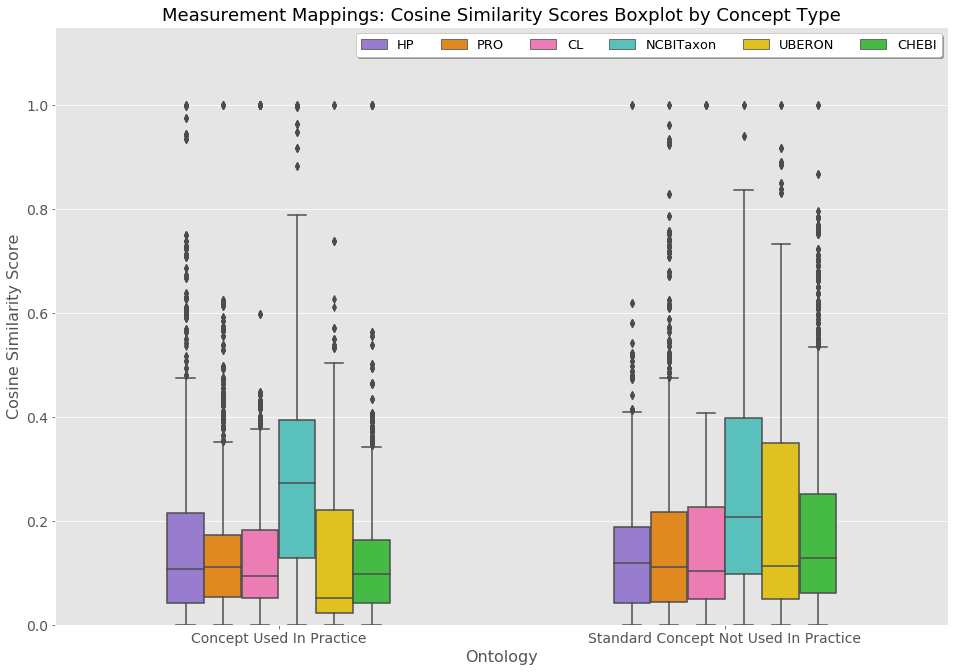

In [222]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(16, 11))
sboxplot = sns.boxplot(y='Similarity_Score', x='Concept_Type', hue='Ontology', data=lab_sim_plot, width=0.5, palette=my_pal)
    
plt.title('Measurement Mappings: Cosine Similarity Scores Boxplot by Concept Type', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Cosine Similarity Score', fontsize=16)
plt.tick_params(labelsize=14)
plt.ylim(0, 1.15)
plt.legend(title='', fontsize=13, title_fontsize=12,
           shadow=True, facecolor='white', edgecolor='darkgray', ncol=6)
plt.show()


***
**Click [here](#lab-mapping-results) to return to the Lab Mapping Results section**  
**Click [here](#mapping-results) to return to the Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**
***

#### Final Mapping Set    <a class="anchor" id="lab-fullmapres"></a>   

***

- [Human Phenotype Ontology](#lb-full-hpo)   
- [Uber-Anatomy Ontology](#lb-full-uberon)   
- [NCBI Organism Taxonomy](#lb-full-ncbi) 
- [Protein Ontology](#lb-full-pro) 
- [Chemical Entities of Biological Interest](#lb-full-chebi) 
- [Cell Ontology](#lb-full-cl) 



*Concept Frequency*

Concept frequency is only calculated for concepts that are used in practice (`n=1,606`). As shown below, there are two ways that concept frequency has been calculated: (1) raw concept counts from the `OMOP` measurement table and (2) converting counts from the `OMOP` measurement table that occur fewer than 100 times to 100. The median raw count is `25` (`min=1`, `max=56,823,139`).

In [223]:
# read in frequency counts data
chco_concept_counts = pd.read_csv(chco_concept_freq_url, sep=',', header=0)
chco_concept_counts.fillna('', inplace=True)

# reduce columns
chco_concept_counts = chco_concept_counts[['CONCEPT_ID', 'DOMAIN', 'CONCEPT_COUNT', 'CONCEPT_COUNT_ADJUSTED']]

# subset data to only keep conditions
chco_concept_counts = chco_concept_counts[chco_concept_counts['DOMAIN'] == 'Labs']

# view data
chco_concept_counts.head(n=5)


,CONCEPT_ID,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
591,3006228,Labs,1,100
694,3013530,Labs,1,100
695,3019677,Labs,1,100
847,3021535,Labs,1,100
848,3009381,Labs,1,100


In [224]:
min_score = min(chco_concept_counts['CONCEPT_COUNT'])
max_score = max(chco_concept_counts['CONCEPT_COUNT'])
median_score = statistics.median(chco_concept_counts['CONCEPT_COUNT'])

print('The median concept count is {} (min: {}, max: {})'.format(median_score, min_score, max_score))


The median concept count is 313 (min: 1, max: 56823139)


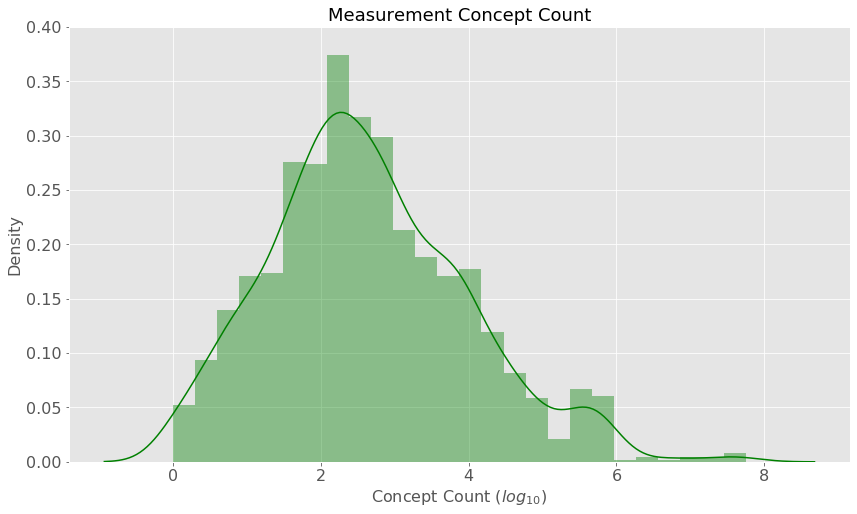

In [225]:
# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
distplot = sns.distplot([math.log10(x) for x in list(chco_concept_counts['CONCEPT_COUNT'])], color='green')
    
plt.title('Measurement Concept Count', fontsize=18)
plt.suptitle('')
plt.ylim(0.0, 0.4)
plt.xlabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

*Mapping Results*


In [226]:
# load mapping results
lab_mappings = pd.read_excel(labs_mapping_url, sheet_name='Aggregated_Mapping_Results', sep=',', header=0)
lab_mappings.fillna('', inplace=True)

# merge concept counts
lab_mappings = lab_mappings.merge(chco_concept_counts, how='left', on='CONCEPT_ID').drop_duplicates()

# view data
lab_mappings.head(n=5)


,COMPOSITE_ID,CONCEPT_TYPE,CONCEPT_ID,STANDARD,CONCEPT_SOURCE_CODE,CONCEPT_LABEL,UMLS_CUI,UMLS_SEMANTIC_TYPE,SCALE,RESULT_TYPE,...,NCBITAXON_MAPPING,NCBITAXON_EVIDENCE,PR_LOGIC,PR_URI,PR_LABEL,PR_MAPPING,PR_EVIDENCE,DOMAIN,CONCEPT_COUNT,CONCEPT_COUNT_ADJUSTED
0,3000003_Normal,LOINC2HPO Concept,3000003,S,7099-05-01 00:00:00,Asparagus IgE Ab [Units/volume] in Serum,C0483670,Clinical Attribute,QUANT,Normal,...,Manual,Hand Mapping,,PR_000050032,immunoglobulin complex (human),Manual,Hand Mapping,NaN,NaN,NaN
1,3000003_Low,LOINC2HPO Concept,3000003,S,7099-05-01 00:00:00,Asparagus IgE Ab [Units/volume] in Serum,C0483670,Clinical Attribute,QUANT,Low,...,Manual,Hand Mapping,,PR_000050032,immunoglobulin complex (human),Manual,Hand Mapping,NaN,NaN,NaN
2,3000003_High,LOINC2HPO Concept,3000003,S,7099-05-01 00:00:00,Asparagus IgE Ab [Units/volume] in Serum,C0483670,Clinical Attribute,QUANT,High,...,Manual,Hand Mapping,,PR_000050032,immunoglobulin complex (human),Manual,Hand Mapping,NaN,NaN,NaN
3,3000034_Normal,CHCO Concept Used In Practice,3000034,S,14957-5,Microalbumin urine,C0798130,Clinical Attribute,QUANT,Normal,...,Manual,Hand Mapping,,PR_000029067,homo sapiens protein,Manual,Hand Mapping,Labs,1009.0,1009.0
4,3000034_Low,CHCO Concept Used In Practice,3000034,S,14957-5,Microalbumin urine,C0798130,Clinical Attribute,QUANT,Low,...,Manual,Hand Mapping,,PR_000029067,homo sapiens protein,Manual,Hand Mapping,Labs,1009.0,1009.0


In [227]:
# split results by ontology
lab_mappings_stacked = reconfigures_dataframe(measurement_onts, lab_mappings)

# split stacked data by concept type
lab_mappings_ont_data = lab_mappings_stacked.groupby('CATEGORY')


*UMLS Semantic Type*

In [228]:
# cui counts
lab_map_cui_coverage = len([x for x in list(lab_mappings_stacked['UMLS_CUI']) if x != 'NO CONCEPT-LEVEL CUI'])
lab_map_cui_total = [x.strip() for y in list(lab_mappings_stacked['UMLS_CUI']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI']
lab_map_cui_unq = set(lab_map_cui_total)

# umls semantic type
lab_map_semantic_type = set([x.strip() for y in list(lab_mappings_stacked['UMLS_SEMANTIC_TYPE']) for x in y.split('|') if x != 'NO CONCEPT-LEVEL CUI'])

cui1 = 'UMLS CUIs were found for {} clinical concepts ({} total CUIs; {} unique CUIs)'.format(lab_map_cui_coverage,
                                                                                             len(lab_map_cui_total),
                                                                                             len(lab_map_cui_unq))
cui2 = '\nThe mapped CUIs represented {} unique Semantic Types'.format(len(lab_map_semantic_type))

print(cui1, cui2)


UMLS CUIs were found for 64932 clinical concepts (64932 total CUIs; 3868 unique CUIs) 
The mapped CUIs represented 1 unique Semantic Types


In [229]:
# get needed data
lab_mapping_results = process_mapping_results(lab_mappings, measurement_onts, 'CONCEPT_TYPE')

# re-group by ontology
lab_mapping_hp = lab_mapping_results['HP']
lab_mapping_chebi = lab_mapping_results['CHEBI']
lab_mapping_cl = lab_mapping_results['CL']
lab_mapping_uberon = lab_mapping_results['UBERON']
lab_mapping_pr = lab_mapping_results['PR']
lab_mapping_ncbi = lab_mapping_results['NCBITAXON']


Processing Ontology: HP
Processing Ontology: CHEBI
Processing Ontology: CL
Processing Ontology: UBERON
Processing Ontology: PR
Processing Ontology: NCBITAXON


<br>

***Human Phenotype Ontology Results***  <a class="anchor" id="lb-full-hpo"></a>  

Summarizing the results shown below, there were a total of `1,437` `CHCO Concepts Used in Practice` (`4,087` lab test results) and `2,462` `LOINC2HPO Concepts Not Used in Practice` (`6,801` lab test results) that mapped to at least 1 `HP` concept (not including `Unmapped` concepts). UMLS CUIs were found for `64,932` clinical concepts (`64,932` total CUIs, `3,868` unique CUIs) representing `1` unique Semantic Types.

**CHCO Concepts Used in Clinical Practice**  
- `4,087` ontology concepts were mapped to `4,136` OMOP concepts (`1.012` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `17` concept-level, `23` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `108` Concept Similarity, `3,902` Exact, `37` Constructor  
  - UnMapped: `5` None, `90` Not Mapped Test Type, `74` Unspecified Sample 
  
- *Mapping Evidence*   
  - `4,585` sources of (`193` unique)  
  - `7` were from dbXRefs (`5` unique identifier types)  
  - `12` were from synonyms (2 unique combinations), covering `1` OBO synonym types   
  - `28` were from labels (`3` unique combinations)  
  - `234` were from similarity (`0.346` median, `0.252` min, `0.805` max)


**LOINC2HPO Concepts Not Used in Practice**     
- `6,801` ontology concepts were mapped to `6,813` OMOP concepts (`1.002` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `3` concept-level, `20` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `5` Concept Similarity, `6,761` Exact, `12` Constructor  
  - UnMapped: `15` None, `1` Not Mapped Test Type, `14` Unspecified Sample 
  
- *Mapping Evidence*   
  - `7,099` sources of (`109` unique)  
  - `0` were from dbXRefs (0 unique identifier types)  
  - `4` were from synonyms (1 unique combinations), covering `1` OBO synonym types. 
  - `24` were from labels (`2` unique combinations)  
  - `128` were from similarity (`0.376` median, `0.251` min, `0.929` max)

CHCO CONCEPTS USED IN PRACTICE

In [230]:
# split data into concept type sets
lab_hp_map_prac = lab_mapping_hp['CHCO Concept Used In Practice']['data']

lab_res = lab_hp_map_prac[lab_hp_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
hp_prac_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(hp_prac_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(hp_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


1437 OMOP Concepts Used in practice with at least 1 ontology mapping
4087 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
4087 ontology concepts were mapped to 4136 OMOP concepts (1.012 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*


In [231]:
# mapping category
hp_lab_prac_map_categories = lab_hp_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_hp_map_prac_unmapped = lab_hp_map_prac[lab_hp_map_prac['CATEGORY_MAPPING'] =='Unmapped']
lab_hp_map_prac_unmapped_types = lab_hp_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in hp_lab_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_hp_map_prac_unmapped_types.items()]))

print(map1, map2)


Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=23)
  - Automatic Exact - Concept (n=17)
  - Manual (n=3902)
  - Manual Constructor (n=37)
  - Manual Exact - Concept Similarity (n=108)
  - Unmapped (n=169) 

Unmapped reasons:
  - NONE (n=5)
  - NOT MAPPED TEST TYPE (n=90)
  - UNSPECIFIED SAMPLE (n=74)


In [232]:
# concept frequency by mapping type 
lab_hp_map_prac_valid = lab_hp_map_prac[lab_hp_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
lab_hp_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(lab_hp_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
lab_hp_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
lab_hp_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                    
                                            min         max  median
CATEGORY_MAPPING                                                   
Automatic Exact - Ancestor                  2.0     37141.0   582.0
Automatic Exact - Concept                  47.0    390128.0   776.0
Manual                                      1.0  56823139.0   292.0
Manual Constructor                          2.0    327735.0   831.0
Manual Exact - Concept Similarity           1.0  54754554.0  1365.0

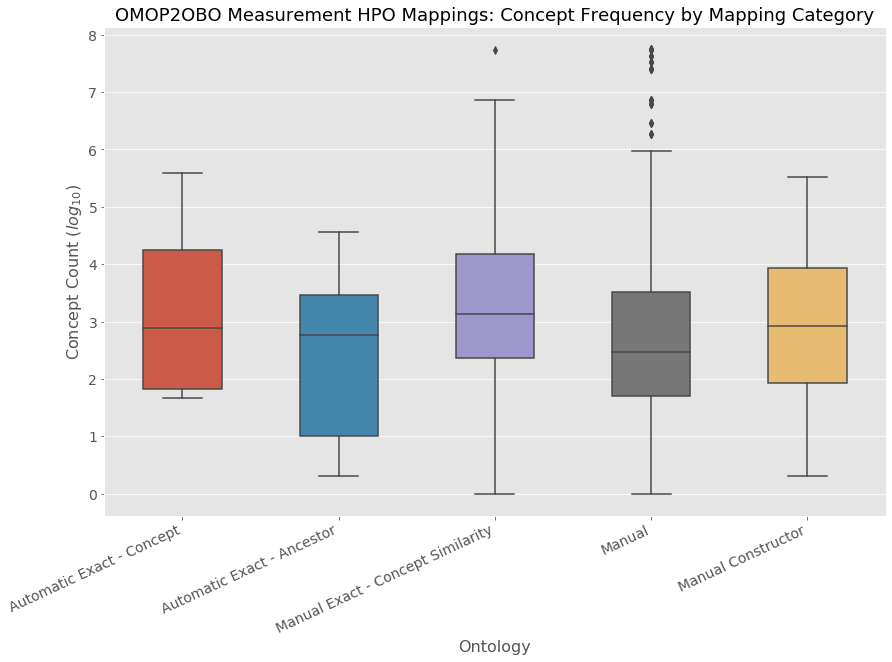

In [233]:
# get log of counts to improve plotting
lab_hp_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(lab_hp_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Exact - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=lab_hp_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Measurement HPO Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [234]:
# parses evidence
lab_hp_map_evidence = process_mapping_evidence(list(lab_hp_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_hp_map_evidence['all']), len(set(lab_hp_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_hp_map_evidence['dbxref']), len(set(lab_hp_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_hp_map_evidence['synonym']),
                                                                                                      len(set(lab_hp_map_evidence['synonym'])),
                                                                                                      len(lab_hp_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_hp_map_evidence['label']), len(set(lab_hp_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_hp_map_evidence['similarity']),
                                                                                         statistics.median(lab_hp_map_evidence['similarity']),
                                                                                         min(lab_hp_map_evidence['similarity']),
                                                                                         max(lab_hp_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 4585 (193 unique) pieces of evidence 
Among the evidence, 7 were from dbXRefs (5 unique) 
Among the evidence, 12 were from synonyms (2 unique), covering 1 OBO synonym types 
Among the evidence, 28 were from labels (3 unique) 
Among the evidence, 234 were from similarity (0.346 median, 0.252 min, 0.805 max)


LOINC2HPO CONCEPTS NOT USED IN PRACTICE

In [235]:
# split data into concept type sets
lab_hp_map_stnd = lab_mapping_hp['LOINC2HPO Concept']['data']

lab_res = lab_hp_map_stnd[lab_hp_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} LOINC2HPO Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
hp_stnd_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(hp_stnd_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(hp_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


2462 LOINC2HPO Concepts Used in practice with at least 1 ontology mapping
6801 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
6801 ontology concepts were mapped to 6813 OMOP concepts (1.002 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [236]:
# mapping category
hp_lab_stnd_map_categories = lab_hp_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_hp_map_stnd_unmapped = lab_hp_map_stnd[lab_hp_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
lab_hp_map_stnd_unmapped_types = lab_hp_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in hp_lab_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_hp_map_stnd_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=20)
  - Automatic Exact - Concept (n=3)
  - Manual (n=6761)
  - Manual Constructor (n=12)
  - Manual Exact - Concept Similarity (n=5)
  - Unmapped (n=15) 

Unmapped reasons:
  - NOT MAPPED TEST TYPE (n=1)
  - UNSPECIFIED SAMPLE (n=14)


*Mapping Evidence*

In [237]:
# parses evidence
lab_hp_map_stnd_valid = lab_hp_map_stnd[lab_hp_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
lab_hp_map_evidence = process_mapping_evidence(list(lab_hp_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_hp_map_evidence['all']), len(set(lab_hp_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_hp_map_evidence['dbxref']), len(set(lab_hp_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_hp_map_evidence['synonym']),
                                                                                                      len(set(lab_hp_map_evidence['synonym'])),
                                                                                                      len(lab_hp_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_hp_map_evidence['label']), len(set(lab_hp_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_hp_map_evidence['similarity']),
                                                                                         statistics.median(lab_hp_map_evidence['similarity']),
                                                                                         min(lab_hp_map_evidence['similarity']),
                                                                                         max(lab_hp_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)



The valid mappings had 7099 (109 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 4 were from synonyms (1 unique), covering 1 OBO synonym types 
Among the evidence, 24 were from labels (2 unique) 
Among the evidence, 128 were from similarity (0.376 median, 0.251 min, 0.929 max)


<br>

***Uber-Anatomy Ontology Results***  <a class="anchor" id="lb-full-uberon"></a>  

Summarizing the results shown below, there were a total of `1,437` `CHCO Concepts Used in Practice` (`4,087` lab test results) and `2,462` `LOINC2HPO Concepts Not Used in Practice` (`6,801` lab test results) that mapped to at least 1 `UBERON` concept (not including `Unmapped` concepts). UMLS CUIs were found for `64,932` clinical concepts (`64,932` total CUIs, `3,868` unique CUIs) representing `1` unique Semantic Types.

**CHCO Concepts Used in Clinical Practice**  
- `4,087` ontology concepts were mapped to `5,336` OMOP concepts (`1.306` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `1,793` concept-level, `592` ancestor-level  
  - Automatic Constructor (1:Many): `10` concept-level, `2` ancestor-level 
  - Manual: `50` Concept Similarity, `406` Exact, `1,234` Constructor  
  - UnMapped: `5` None, `90` Not Mapped Test Type, `74` Unspecified Sample 
  
- *Mapping Evidence*   
  - `16,154` sources of (`230` unique)  
  - `6` were from dbXRefs (`2` unique identifier types)  
  - `5,232` were from synonyms (`6` unique combinations), covering `3` OBO synonym types   
  - `1,637` were from labels (`4` unique combinations)  
  - `699` were from similarity (`0.3` median, `0.25` min, `0.804` max)


**LOINC2HPO Concepts Not Used in Practice**    
- `6,801` ontology concepts were mapped to `8,869` OMOP concepts (`1.304` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `3,589` concept-level, `593` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `92` Concept Similarity, `462` Exact, `2,065` Constructor  
  - UnMapped: `15` None, `1` Not Mapped Test Type, `14` Unspecified Sample 
  
- *Mapping Evidence*   
  - `24,782` sources of (`207` unique)  
  - `26` were from dbXRefs (2 unique identifier types)  
  - `8,308` were from synonyms (5 unique combinations), covering `3` OBO synonym types. 
  - `1,242` were from labels (`3` unique combinations)  
  - `553` were from similarity (`0.349` median, `0.251` min, `0.65` max)

CHCO CONCEPTS USED IN PRACTICE

In [238]:
# split data into concept type sets
lab_uberon_map_prac = lab_mapping_uberon['CHCO Concept Used In Practice']['data']

lab_res = lab_uberon_map_prac[lab_uberon_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
uberon_prac_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(uberon_prac_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(uberon_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

1437 OMOP Concepts Used in practice with at least 1 ontology mapping
4087 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
4087 ontology concepts were mapped to 5336 OMOP concepts (1.306 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [239]:
# mapping category
uberon_lab_prac_map_categories = lab_uberon_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_uberon_map_prac_unmapped = lab_uberon_map_prac[lab_uberon_map_prac['CATEGORY_MAPPING'] =='Unmapped']
lab_uberon_map_prac_unmapped_types = lab_uberon_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in uberon_lab_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_uberon_map_prac_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=2)
  - Automatic Constructor - Concept (n=10)
  - Automatic Exact - Ancestor (n=592)
  - Automatic Exact - Concept (n=1793)
  - Manual (n=406)
  - Manual Constructor (n=1234)
  - Manual Exact - Concept Similarity (n=50)
  - Unmapped (n=169) 

Unmapped reasons:
  - NONE (n=5)
  - NOT MAPPED TEST TYPE (n=90)
  - UNSPECIFIED SAMPLE (n=74)


In [240]:
# concept frequency by mapping type 
lab_uberon_map_prac_valid = lab_uberon_map_prac[lab_uberon_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
lab_uberon_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(lab_uberon_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
lab_uberon_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
lab_uberon_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})

CONCEPT_COUNT                     
                                            min         max   median
CATEGORY_MAPPING                                                    
Automatic Constructor - Ancestor           13.0        13.0     13.0
Automatic Constructor - Concept            47.0       267.0    257.0
Automatic Exact - Ancestor                  1.0    119980.0    107.0
Automatic Exact - Concept                   1.0  56823139.0    375.0
Manual                                      1.0  33844898.0    809.0
Manual Constructor                          1.0    715141.0    472.5
Manual Exact - Concept Similarity           2.0  54754554.0  60335.0

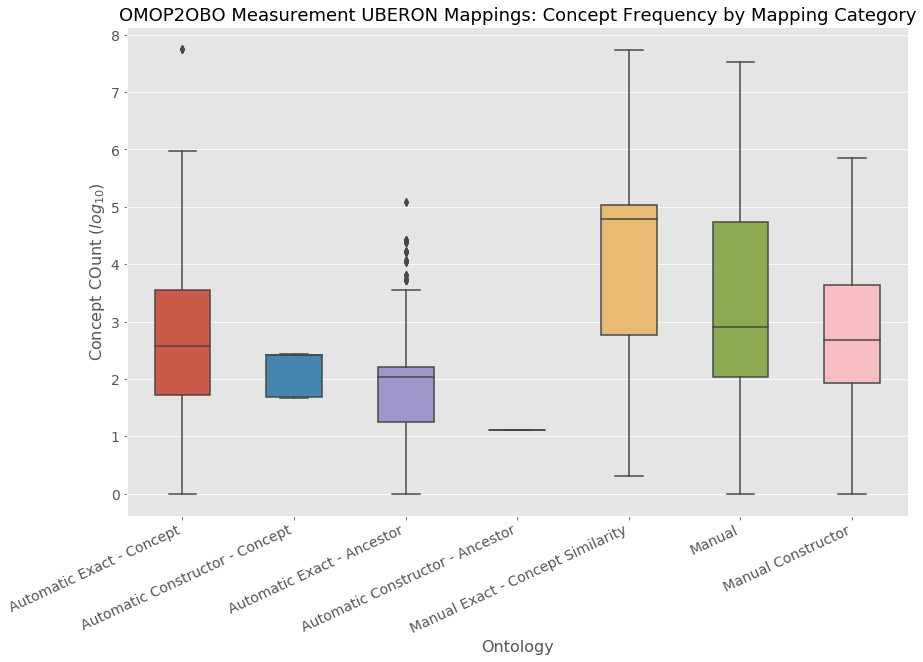

In [241]:
# get log of counts to improve plotting
lab_uberon_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(lab_uberon_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=lab_uberon_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Measurement UBERON Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept COunt ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()

*Mapping Evidence*

In [242]:
# parses evidence
lab_uberon_map_evidence = process_mapping_evidence(list(lab_uberon_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_uberon_map_evidence['all']), len(set(lab_uberon_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_uberon_map_evidence['dbxref']), len(set(lab_uberon_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_uberon_map_evidence['synonym']),
                                                                                                      len(set(lab_uberon_map_evidence['synonym'])),
                                                                                                      len(lab_uberon_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_uberon_map_evidence['label']), len(set(lab_uberon_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_uberon_map_evidence['similarity']),
                                                                                         statistics.median(lab_uberon_map_evidence['similarity']),
                                                                                         min(lab_uberon_map_evidence['similarity']),
                                                                                         max(lab_uberon_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 16154 (230 unique) pieces of evidence 
Among the evidence, 6 were from dbXRefs (2 unique) 
Among the evidence, 5232 were from synonyms (6 unique), covering 3 OBO synonym types 
Among the evidence, 1637 were from labels (4 unique) 
Among the evidence, 699 were from similarity (0.3 median, 0.25 min, 0.804 max)


LOINC2HPO CONCEPTS NOT USED IN PRACTICE

In [243]:
# split data into concept type sets
lab_uberon_map_stnd = lab_mapping_uberon['LOINC2HPO Concept']['data']

lab_res = lab_uberon_map_stnd[lab_uberon_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} LOINC2HPO Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
uberon_stnd_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(uberon_stnd_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(uberon_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

2462 LOINC2HPO Concepts Used in practice with at least 1 ontology mapping
6801 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
6801 ontology concepts were mapped to 8869 OMOP concepts (1.304 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [244]:
# mapping category
uberon_lab_stnd_map_categories = lab_uberon_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_uberon_map_stnd_unmapped = lab_uberon_map_stnd[lab_uberon_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
lab_uberon_map_stnd_unmapped_types = lab_uberon_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in uberon_lab_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_uberon_map_stnd_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=593)
  - Automatic Exact - Concept (n=3589)
  - Manual (n=462)
  - Manual Constructor (n=2065)
  - Manual Exact - Concept Similarity (n=92)
  - Unmapped (n=15) 

Unmapped reasons:
  - NOT MAPPED TEST TYPE (n=1)
  - UNSPECIFIED SAMPLE (n=14)


*Mapping Evidence*

In [245]:
# parses evidence
lab_uberon_map_stnd_valid = lab_uberon_map_stnd[lab_uberon_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
lab_uberon_map_evidence = process_mapping_evidence(list(lab_uberon_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_uberon_map_evidence['all']), len(set(lab_uberon_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_uberon_map_evidence['dbxref']), len(set(lab_uberon_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_uberon_map_evidence['synonym']),
                                                                                                      len(set(lab_uberon_map_evidence['synonym'])),
                                                                                                      len(lab_uberon_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_uberon_map_evidence['label']), len(set(lab_uberon_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_uberon_map_evidence['similarity']),
                                                                                         statistics.median(lab_uberon_map_evidence['similarity']),
                                                                                         min(lab_uberon_map_evidence['similarity']),
                                                                                         max(lab_uberon_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 24782 (207 unique) pieces of evidence 
Among the evidence, 26 were from dbXRefs (2 unique) 
Among the evidence, 8308 were from synonyms (5 unique), covering 3 OBO synonym types 
Among the evidence, 1242 were from labels (3 unique) 
Among the evidence, 553 were from similarity (0.349 median, 0.251 min, 0.65 max)


<br>

***NCBI Organism Taxonomy Ontology Results***  <a class="anchor" id="lb-full-ncbi"></a>  

Summarizing the results shown below, there were a total of `910` `CHCO Concepts Used in Practice` (`2,572` lab test results) and `1,788` `LOINC2HPO Concepts Not Used in Practice` (`4,888` lab test results) that mapped to at least 1 `NCBITaxon` concept (not including `Unmapped` concepts). UMLS CUIs were found for `64,932` clinical concepts (`64,932` total CUIs, `3,868` unique CUIs) representing `1` unique Semantic Types.

**CHCO Concepts Used in Clinical Practice**
- `2,572` ontology concepts were mapped to `2,601` OMOP concepts (`1.011` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `320` concept-level, `184` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `44` Concept Similarity, `2,019` Exact, `5` Constructor  
  - UnMapped: `1,520` None, `90` Not Mapped Test Type, `74` Unspecified Sample 
  
- *Mapping Evidence*   
  - `4,354` sources of (`354` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `465` were from synonyms (`6` unique combinations), covering `3` OBO synonym types   
  - `310` were from labels (`4` unique combinations)  
  - `487` were from similarity (`0.393` median, `0.25` min, `0.684` max)


**LOINC2HPO Concepts Not Used in Practice**    
- `4,888` ontology concepts were mapped to `6,362` OMOP concepts (`1.302` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `444` concept-level, `360` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `114` Concept Similarity, `3,516` Exact, `454` Constructor  
  - UnMapped: `1,913` None, `1` Not Mapped Test Type, `14` Unspecified Sample 
  
- *Mapping Evidence*   
  - `9,358` sources of (`493` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `1,627` were from synonyms (`5` unique combinations), covering `2` OBO synonym types. 
  - `467` were from labels (`4` unique combinations)  
  - `844` were from similarity (`0.385` median, `0.25` min, `0.715` max)

CHCO CONCEPTS USED IN PRACTICE

In [246]:
# split data into concept type sets
lab_ncbi_map_prac = lab_mapping_ncbi['CHCO Concept Used In Practice']['data']

lab_res = lab_ncbi_map_prac[lab_ncbi_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
ncbi_prac_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(ncbi_prac_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(ncbi_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

910 OMOP Concepts Used in practice with at least 1 ontology mapping
2572 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
2572 ontology concepts were mapped to 2601 OMOP concepts (1.011 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [247]:
# mapping category
ncbi_lab_prac_map_categories = lab_ncbi_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_ncbi_map_prac_unmapped = lab_ncbi_map_prac[lab_ncbi_map_prac['CATEGORY_MAPPING'] =='Unmapped']
lab_ncbi_map_prac_unmapped_types = lab_ncbi_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in ncbi_lab_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_ncbi_map_prac_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=184)
  - Automatic Exact - Concept (n=320)
  - Manual (n=2019)
  - Manual Constructor (n=5)
  - Manual Exact - Concept Similarity (n=44)
  - Unmapped (n=1684) 

Unmapped reasons:
  - NONE (n=1520)
  - NOT MAPPED TEST TYPE (n=90)
  - UNSPECIFIED SAMPLE (n=74)


In [248]:
# concept frequency by mapping type 
lab_ncbi_map_prac_valid = lab_ncbi_map_prac[lab_ncbi_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
lab_ncbi_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(lab_ncbi_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
lab_ncbi_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
lab_ncbi_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                 
                                            min       max median
CATEGORY_MAPPING                                                
Automatic Exact - Ancestor                  1.0  142819.0  249.0
Automatic Exact - Concept                   1.0  623982.0  152.0
Manual                                      1.0  726455.0  248.0
Manual Constructor                        711.0    8521.0  711.0
Manual Exact - Concept Similarity           1.0    2105.0   53.0

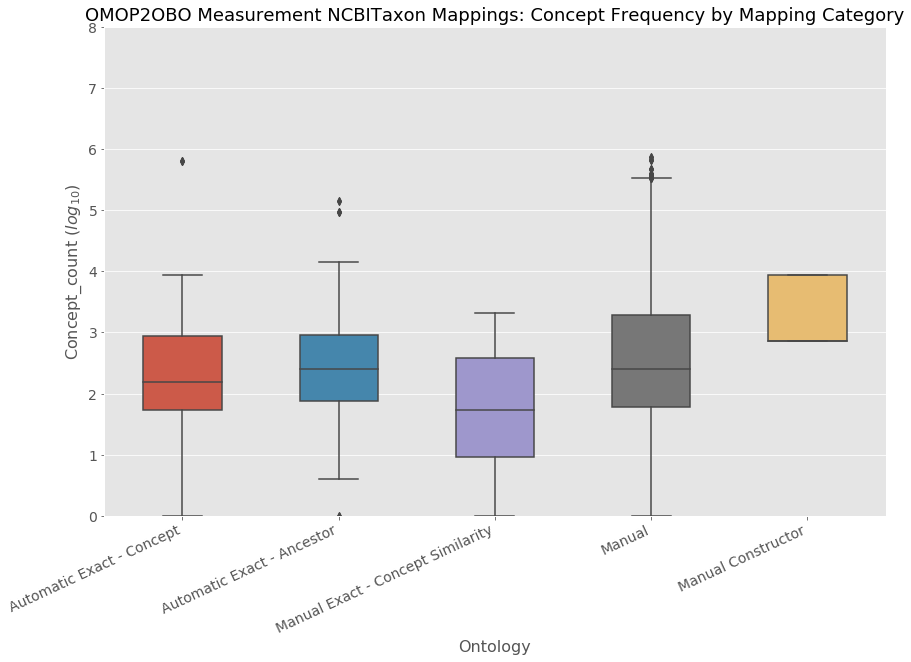

In [249]:
# get log of counts to improve plotting
lab_ncbi_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(lab_ncbi_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Exact - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=lab_ncbi_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Measurement NCBITaxon Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylim(0, 8)
plt.ylabel('Concept_count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()


*Mapping Evidence*

In [250]:
# parses evidence
lab_ncbi_map_evidence = process_mapping_evidence(list(lab_ncbi_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_ncbi_map_evidence['all']), len(set(lab_ncbi_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_ncbi_map_evidence['dbxref']), len(set(lab_ncbi_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_ncbi_map_evidence['synonym']),
                                                                                                      len(set(lab_ncbi_map_evidence['synonym'])),
                                                                                                      len(lab_ncbi_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_ncbi_map_evidence['label']), len(set(lab_ncbi_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_ncbi_map_evidence['similarity']),
                                                                                         statistics.median(lab_ncbi_map_evidence['similarity']),
                                                                                         min(lab_ncbi_map_evidence['similarity']),
                                                                                         max(lab_ncbi_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 4354 (354 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 465 were from synonyms (6 unique), covering 3 OBO synonym types 
Among the evidence, 310 were from labels (4 unique) 
Among the evidence, 487 were from similarity (0.393 median, 0.25 min, 0.684 max)


LOINC2HPO CONCEPTS NOT USED IN PRACTICE

In [251]:
# split data into concept type sets
lab_ncbi_map_stnd = lab_mapping_ncbi['LOINC2HPO Concept']['data']

lab_res = lab_ncbi_map_stnd[lab_ncbi_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} LOINC2HPO Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
ncbi_stnd_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(ncbi_stnd_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(ncbi_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))


1788 LOINC2HPO Concepts Used in practice with at least 1 ontology mapping
4888 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
4888 ontology concepts were mapped to 6362 OMOP concepts (1.302 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [252]:
# mapping category
ncbi_lab_stnd_map_categories = lab_ncbi_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_ncbi_map_stnd_unmapped = lab_ncbi_map_stnd[lab_ncbi_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
lab_ncbi_map_stnd_unmapped_types = lab_ncbi_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in ncbi_lab_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_ncbi_map_stnd_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=360)
  - Automatic Exact - Concept (n=444)
  - Manual (n=3516)
  - Manual Constructor (n=454)
  - Manual Exact - Concept Similarity (n=114)
  - Unmapped (n=1928) 

Unmapped reasons:
  - NONE (n=1913)
  - NOT MAPPED TEST TYPE (n=1)
  - UNSPECIFIED SAMPLE (n=14)


*Mapping Evidence*

In [253]:
# parses evidence
lab_ncbi_map_stnd_valid = lab_ncbi_map_stnd[lab_ncbi_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
lab_ncbi_map_evidence = process_mapping_evidence(list(lab_ncbi_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_ncbi_map_evidence['all']), len(set(lab_ncbi_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_ncbi_map_evidence['dbxref']), len(set(lab_ncbi_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_ncbi_map_evidence['synonym']),
                                                                                                      len(set(lab_ncbi_map_evidence['synonym'])),
                                                                                                      len(lab_ncbi_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_ncbi_map_evidence['label']), len(set(lab_ncbi_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_ncbi_map_evidence['similarity']),
                                                                                         statistics.median(lab_ncbi_map_evidence['similarity']),
                                                                                         min(lab_ncbi_map_evidence['similarity']),
                                                                                         max(lab_ncbi_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 9358 (493 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 1627 were from synonyms (5 unique), covering 2 OBO synonym types 
Among the evidence, 467 were from labels (4 unique) 
Among the evidence, 844 were from similarity (0.385 median, 0.25 min, 0.715 max)


<br>

***Protein Ontology Results***  <a class="anchor" id="lb-full-pro"></a>  

Summarizing the results shown below, there were a total of `567` `CHCO Concepts Used in Practice` (`1,572` lab test results) and `1,237` `LOINC2HPO Concepts Not Used in Practice` (`3,283` lab test results) that mapped to at least 1 `NCBITaxon` concept (not including `Unmapped` concepts). UMLS CUIs were found for `64,932` clinical concepts (`64,932` total CUIs, `3,868` unique CUIs) representing `1` unique Semantic Types.

**CHCO Concepts Used in Clinical Practice**  
- `1,572` ontology concepts were mapped to `1,726` OMOP concepts (`1.098` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `44` concept-level, `15` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `4103 Concept Similarity, `1,261` Exact, `149` Constructor  
  - UnMapped: `2,520` None, `90` Not Mapped Test Type, `74` Unspecified Sample 
  
- *Mapping Evidence*   
  - `1,949` sources of (`92` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `73` were from synonyms (`5` unique combinations), covering `2` OBO synonym types   
  - `35` were from labels (`4` unique combinations)  
  - `165` were from similarity (`0.367` median, `0.271` min, `0.694` max)


**LOINC2HPO Concepts Not Used in Practice**     
- `3,283` ontology concepts were mapped to `3,493` OMOP concepts (`1.064` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `12` concept-level, `6` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `29` Concept Similarity, `3,047` Exact, `189` Constructor  
  - UnMapped: `3,518` None, `1` Not Mapped Test Type, `14` Unspecified Sample 
  
- *Mapping Evidence*   
  - `3,421` sources of (`40` unique)  
  - `0` were from dbXRefs (`0` unique identifier types)  
  - `24` were from synonyms (`5` unique combinations), covering `2` OBO synonym types. 
  - `14` were from labels (`4` unique combinations)  
  - `61` were from similarity (`0.354` median, `0.254` min, `0.594` max)

CHCO CONCEPTS USED IN PRACTICE

In [254]:
# split data into concept type sets
lab_pr_map_prac = lab_mapping_pr['CHCO Concept Used In Practice']['data']

lab_res = lab_pr_map_prac[lab_pr_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
pr_prac_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(pr_prac_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(pr_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

567 OMOP Concepts Used in practice with at least 1 ontology mapping
1572 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
1572 ontology concepts were mapped to 1726 OMOP concepts (1.098 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [255]:
# mapping category
pr_lab_prac_map_categories = lab_pr_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_pr_map_prac_unmapped = lab_pr_map_prac[lab_pr_map_prac['CATEGORY_MAPPING'] =='Unmapped']
lab_pr_map_prac_unmapped_types = lab_pr_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in pr_lab_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_pr_map_prac_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=15)
  - Automatic Exact - Concept (n=44)
  - Manual (n=1261)
  - Manual Constructor (n=149)
  - Manual Exact - Concept Similarity (n=103)
  - Unmapped (n=2684) 

Unmapped reasons:
  - NONE (n=2520)
  - NOT MAPPED TEST TYPE (n=90)
  - UNSPECIFIED SAMPLE (n=74)


In [256]:
# concept frequency by mapping type 
lab_pr_map_prac_valid = lab_pr_map_prac[lab_pr_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
lab_pr_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(lab_pr_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
lab_pr_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
lab_pr_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                  
                                            min       max  median
CATEGORY_MAPPING                                                 
Automatic Exact - Ancestor                 12.0  328304.0  1167.0
Automatic Exact - Concept                   1.0   93168.0   321.0
Manual                                      1.0  726455.0   165.0
Manual Constructor                          1.0   20576.0   206.0
Manual Exact - Concept Similarity           4.0  123977.0   188.0

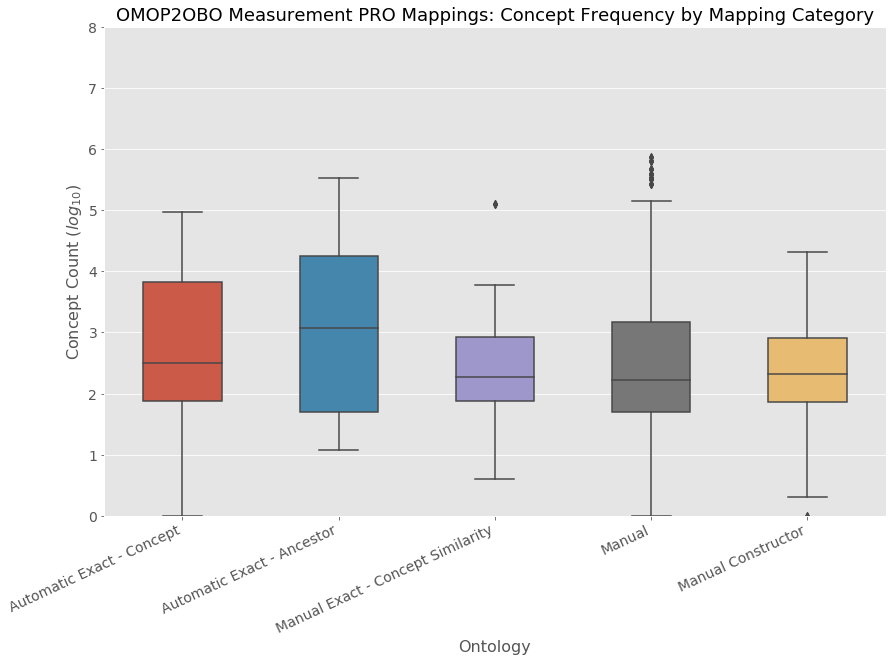

In [257]:
# get log of counts to improve plotting
lab_pr_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(lab_pr_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Exact - Ancestor',
            'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=lab_pr_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Measurement PRO Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylim(0, 8)
plt.tick_params(labelsize=14)

plt.show()

*Mapping Evidence*

In [258]:
# parses evidence
lab_pr_map_evidence = process_mapping_evidence(list(lab_pr_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_pr_map_evidence['all']), len(set(lab_pr_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_pr_map_evidence['dbxref']), len(set(lab_pr_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_pr_map_evidence['synonym']),
                                                                                                      len(set(lab_pr_map_evidence['synonym'])),
                                                                                                      len(lab_pr_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_pr_map_evidence['label']), len(set(lab_pr_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_pr_map_evidence['similarity']),
                                                                                         statistics.median(lab_pr_map_evidence['similarity']),
                                                                                         min(lab_pr_map_evidence['similarity']),
                                                                                         max(lab_pr_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 1949 (92 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 73 were from synonyms (5 unique), covering 2 OBO synonym types 
Among the evidence, 35 were from labels (4 unique) 
Among the evidence, 165 were from similarity (0.367 median, 0.271 min, 0.694 max)


LOINC2HPO CONCEPTS NOT USED IN PRACTICE

In [259]:
# split data into concept type sets
lab_pr_map_stnd = lab_mapping_pr['LOINC2HPO Concept']['data']

lab_res = lab_pr_map_stnd[lab_pr_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} LOINC2HPO Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
pr_stnd_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(pr_stnd_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(pr_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

1237 LOINC2HPO Concepts Used in practice with at least 1 ontology mapping
3283 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
3283 ontology concepts were mapped to 3493 OMOP concepts (1.064 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [260]:
# mapping category
pr_lab_stnd_map_categories = lab_pr_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_pr_map_stnd_unmapped = lab_pr_map_stnd[lab_pr_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
lab_pr_map_stnd_unmapped_types = lab_pr_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in pr_lab_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_pr_map_stnd_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=6)
  - Automatic Exact - Concept (n=12)
  - Manual (n=3047)
  - Manual Constructor (n=189)
  - Manual Exact - Concept Similarity (n=29)
  - Unmapped (n=3533) 

Unmapped reasons:
  - NONE (n=3518)
  - NOT MAPPED TEST TYPE (n=1)
  - UNSPECIFIED SAMPLE (n=14)


*Mapping Evidence*

In [261]:
# parses evidence
lab_pr_map_stnd_valid = lab_pr_map_stnd[lab_pr_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
lab_pr_map_evidence = process_mapping_evidence(list(lab_pr_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_pr_map_evidence['all']), len(set(lab_pr_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_pr_map_evidence['dbxref']), len(set(lab_pr_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_pr_map_evidence['synonym']),
                                                                                                      len(set(lab_pr_map_evidence['synonym'])),
                                                                                                      len(lab_pr_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_pr_map_evidence['label']), len(set(lab_pr_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_pr_map_evidence['similarity']),
                                                                                         statistics.median(lab_pr_map_evidence['similarity']),
                                                                                         min(lab_pr_map_evidence['similarity']),
                                                                                         max(lab_pr_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 3421 (40 unique) pieces of evidence 
Among the evidence, 0 were from dbXRefs (0 unique) 
Among the evidence, 24 were from synonyms (5 unique), covering 2 OBO synonym types 
Among the evidence, 14 were from labels (4 unique) 
Among the evidence, 61 were from similarity (0.354 median, 0.254 min, 0.594 max)


<br>

***Chemical Entities of Biological Interest Results***  <a class="anchor" id="lb-full-chebi"></a>  

Summarizing the results shown below, there were a total of `1,226` `CHCO Concepts Used in Practice` (`13,487` lab test results) and `2,327` `LOINC2HPO Concepts Not Used in Practice` (`6,415` lab test results) that mapped to at least 1 `NCBITaxon` concept (not including `Unmapped` concepts). UMLS CUIs were found for `64,932` clinical concepts (`64,932` total CUIs, `3,868` unique CUIs) representing `1` unique Semantic Types.

**CHCO Concepts Used in Clinical Practice**  
- `3,487` ontology concepts were mapped to `3,914` OMOP concepts (`1.122` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `263` concept-level, `1,382` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `21` ancestor-level 
  - Manual: `102` Concept Similarity, `1,369` Exact, `350` Constructor  
  - UnMapped: `605` None, `90` Not Mapped Test Type, `74` Unspecified Sample 
  
- *Mapping Evidence*   
  - `13,748` sources of (`1,034` unique)  
  - `409` were from dbXRefs (`86` unique identifier types)  
  - `2,824` were from synonyms (`7` unique combinations), covering `3` OBO synonym types   
  - `3,035` were from labels (`6` unique combinations)  
  - `1,485` were from similarity (`0.36` median, `0.25` min, `1.0` max)


**LOINC2HPO Concepts Not Used in Practice**   
- `6,415` ontology concepts were mapped to `8,301` OMOP concepts (`1.294` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `400` concept-level, `1,912` ancestor-level  
  - Automatic Constructor (1:Many): `0` concept-level, `0` ancestor-level 
  - Manual: `362` Concept Similarity, `2,376` Exact, `1,365` Constructor  
  - UnMapped: `386` None, `1` Not Mapped Test Type, `14` Unspecified Sample 
  
- *Mapping Evidence*   
  - `27,219` sources of (`742` unique)  
  - `960` were from dbXRefs (`28` unique identifier types)  
  - `6,348` were from synonyms (`6` unique combinations), covering `3` OBO synonym types. 
  - `5,797` were from labels (`4` unique combinations)  
  - `2,092` were from similarity (`0.3225` median, `0.25` min, `0.64` max)

CHCO CONCEPTS USED IN PRACTICE

In [262]:
# split data into concept type sets
lab_chebi_map_prac = lab_mapping_chebi['CHCO Concept Used In Practice']['data']

lab_res = lab_chebi_map_prac[lab_chebi_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
chebi_prac_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(chebi_prac_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(chebi_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

1226 OMOP Concepts Used in practice with at least 1 ontology mapping
3487 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
3487 ontology concepts were mapped to 3914 OMOP concepts (1.122 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [263]:
# mapping category
chebi_lab_prac_map_categories = lab_chebi_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_chebi_map_prac_unmapped = lab_chebi_map_prac[lab_chebi_map_prac['CATEGORY_MAPPING'] =='Unmapped']
lab_chebi_map_prac_unmapped_types = lab_chebi_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in chebi_lab_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_chebi_map_prac_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=21)
  - Automatic Exact - Ancestor (n=1382)
  - Automatic Exact - Concept (n=263)
  - Manual (n=1369)
  - Manual Constructor (n=350)
  - Manual Exact - Concept Similarity (n=102)
  - Unmapped (n=769) 

Unmapped reasons:
  - NONE (n=605)
  - NOT MAPPED TEST TYPE (n=90)
  - UNSPECIFIED SAMPLE (n=74)


In [264]:
# concept frequency by mapping type 
lab_chebi_map_prac_valid = lab_chebi_map_prac[lab_chebi_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
lab_chebi_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(lab_chebi_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
lab_chebi_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
lab_chebi_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})


CONCEPT_COUNT                   
                                            min         max median
CATEGORY_MAPPING                                                  
Automatic Constructor - Ancestor           18.0       171.0   22.0
Automatic Exact - Ancestor                  1.0    945735.0  282.0
Automatic Exact - Concept                   1.0    142819.0  457.0
Manual                                      1.0  56823139.0  192.0
Manual Constructor                          1.0    765449.0  155.0
Manual Exact - Concept Similarity           2.0    107295.0  455.0

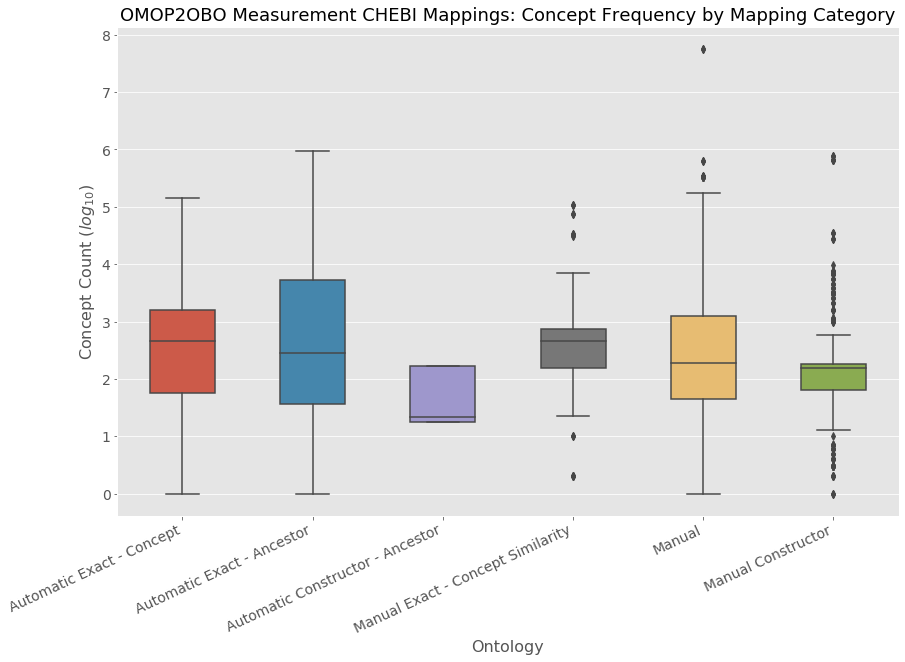

In [265]:
# get log of counts to improve plotting
lab_chebi_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(lab_chebi_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=lab_chebi_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Measurement CHEBI Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.tick_params(labelsize=14)

plt.show()

*Mapping Evidence*


In [266]:
# parses evidence
lab_chebi_map_evidence = process_mapping_evidence(list(lab_chebi_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_chebi_map_evidence['all']), len(set(lab_chebi_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_chebi_map_evidence['dbxref']), len(set(lab_chebi_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_chebi_map_evidence['synonym']),
                                                                                                      len(set(lab_chebi_map_evidence['synonym'])),
                                                                                                      len(lab_chebi_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_chebi_map_evidence['label']), len(set(lab_chebi_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_chebi_map_evidence['similarity']),
                                                                                         statistics.median(lab_chebi_map_evidence['similarity']),
                                                                                         min(lab_chebi_map_evidence['similarity']),
                                                                                         max(lab_chebi_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 13748 (1034 unique) pieces of evidence 
Among the evidence, 409 were from dbXRefs (86 unique) 
Among the evidence, 2824 were from synonyms (7 unique), covering 3 OBO synonym types 
Among the evidence, 3035 were from labels (6 unique) 
Among the evidence, 1485 were from similarity (0.36 median, 0.25 min, 1.0 max)


LOINC2HPO CONCEPTS NOT USED IN PRACTICE

In [267]:
# split data into concept type sets
lab_chebi_map_stnd = lab_mapping_chebi['LOINC2HPO Concept']['data']

lab_res = lab_chebi_map_stnd[lab_chebi_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} LOINC2HPO Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
chebi_stnd_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(chebi_stnd_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(chebi_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

2327 LOINC2HPO Concepts Used in practice with at least 1 ontology mapping
6415 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
6415 ontology concepts were mapped to 8301 OMOP concepts (1.294 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [268]:
# mapping category
chebi_lab_stnd_map_categories = lab_chebi_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_chebi_map_stnd_unmapped = lab_chebi_map_stnd[lab_chebi_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
lab_chebi_map_stnd_unmapped_types = lab_chebi_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in chebi_lab_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_chebi_map_stnd_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Exact - Ancestor (n=1912)
  - Automatic Exact - Concept (n=400)
  - Manual (n=2376)
  - Manual Constructor (n=1365)
  - Manual Exact - Concept Similarity (n=362)
  - Unmapped (n=401) 

Unmapped reasons:
  - NONE (n=386)
  - NOT MAPPED TEST TYPE (n=1)
  - UNSPECIFIED SAMPLE (n=14)


*Mapping Evidence*

In [269]:
# parses evidence
lab_chebi_map_stnd_valid = lab_chebi_map_stnd[lab_chebi_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
lab_chebi_map_evidence = process_mapping_evidence(list(lab_chebi_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_chebi_map_evidence['all']), len(set(lab_chebi_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_chebi_map_evidence['dbxref']), len(set(lab_chebi_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_chebi_map_evidence['synonym']),
                                                                                                      len(set(lab_chebi_map_evidence['synonym'])),
                                                                                                      len(lab_chebi_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_chebi_map_evidence['label']), len(set(lab_chebi_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_chebi_map_evidence['similarity']),
                                                                                         statistics.median(lab_chebi_map_evidence['similarity']),
                                                                                         min(lab_chebi_map_evidence['similarity']),
                                                                                         max(lab_chebi_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)


The valid mappings had 27219 (742 unique) pieces of evidence 
Among the evidence, 960 were from dbXRefs (28 unique) 
Among the evidence, 6348 were from synonyms (6 unique), covering 3 OBO synonym types 
Among the evidence, 5797 were from labels (4 unique) 
Among the evidence, 2092 were from similarity (0.3225 median, 0.25 min, 0.64 max)


<br>

***Cell Ontology Results***  <a class="anchor" id="lb-full-cl"></a>  

Summarizing the results shown below, there were a total of `225` `CHCO Concepts Used in Practice` (`616` lab test results) and `152` `LOINC2HPO Concepts Not Used in Practice` (`429` lab test results) that mapped to at least 1 `NCBITaxon` concept (not including `Unmapped` concepts). UMLS CUIs were found for `64,932` clinical concepts (`64,932` total CUIs, `3,868` unique CUIs) representing `1` unique Semantic Types.

**CHCO Concepts Used in Clinical Practice**  
- `616` ontology concepts were mapped to `707` OMOP concepts (`1.148` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `182` concept-level, `14` ancestor-level  
  - Automatic Constructor (1:Many): `46` concept-level, `3` ancestor-level 
  - Manual: `85` Concept Similarity, `256` Exact, `30` Constructor  
  - UnMapped: `3,476` None, `90` Not Mapped Test Type, `74` Unspecified Sample 
  
- *Mapping Evidence*   
  - `2,370` sources of (`139` unique)  
  - `261` were from dbXRefs (`18` unique identifier types)  
  - `486` were from synonyms (`4` unique combinations), covering `3` OBO synonym types   
  - `296` were from labels (`1` unique combinations)  
  - `296` were from similarity (`0.427` median, `0.257` min, `1.0` max)


**LOINC2HPO Concepts Not Used in Practice**    
- `429` ontology concepts were mapped to `474` OMOP concepts (`1.105` ontology concepts/OMOP vocabulary concept)
- *Mapping Categories*  
  - Automatic Exact (1:1): `186` concept-level, `0` ancestor-level  
  - Automatic Constructor (1:Many): `24` concept-level, `0` ancestor-level 
  - Manual: `20` Concept Similarity, `178` Exact, `21` Constructor  
  - UnMapped: `6,372` None, `1` Not Mapped Test Type, `14` Unspecified Sample 
  
- *Mapping Evidence*   
  - `1,781` sources of (`107` unique)  
  - `145` were from dbXRefs (`8` unique identifier types)  
  - `413` were from synonyms (`4` unique combinations), covering `3` OBO synonym types 
  - `226` were from labels (`1` unique combinations)  
  - `232` were from similarity (`0.435` median, `0.258` min, `1.0` max)

CHCO CONCEPTS USED IN PRACTICE

In [270]:
# split data into concept type sets
lab_cl_map_prac = lab_mapping_cl['CHCO Concept Used In Practice']['data']

lab_res = lab_cl_map_prac[lab_cl_map_prac['CATEGORY_MAPPING'] !='Unmapped']
print('{} OMOP Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
cl_prac_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(cl_prac_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(cl_prac_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

225 OMOP Concepts Used in practice with at least 1 ontology mapping
616 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
616 ontology concepts were mapped to 707 OMOP concepts (1.148 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [271]:
# mapping category
cl_lab_prac_map_categories = lab_cl_map_prac.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_cl_map_prac_unmapped = lab_cl_map_prac[lab_cl_map_prac['CATEGORY_MAPPING'] =='Unmapped']
lab_cl_map_prac_unmapped_types = lab_cl_map_prac_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cl_lab_prac_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_cl_map_prac_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Constructor - Ancestor (n=3)
  - Automatic Constructor - Concept (n=46)
  - Automatic Exact - Ancestor (n=14)
  - Automatic Exact - Concept (n=182)
  - Manual (n=256)
  - Manual Constructor (n=30)
  - Manual Exact - Concept Similarity (n=85)
  - Unmapped (n=3640) 

Unmapped reasons:
  - NONE (n=3476)
  - NOT MAPPED TEST TYPE (n=90)
  - UNSPECIFIED SAMPLE (n=74)


In [272]:
# concept frequency by mapping type 
lab_cl_map_prac_valid = lab_cl_map_prac[lab_cl_map_prac['CATEGORY_MAPPING'] !='Unmapped']

# make sure counts data is correct type
lab_cl_map_prac_valid['CONCEPT_COUNT'] = pd.to_numeric(lab_cl_map_prac_valid['CONCEPT_COUNT'])

# get concept count stats for valid mapped concepts
lab_cl_map_prac_valid['CONCEPT_COUNT'].describe()

# print concept frequency by mapping category
lab_cl_map_prac_valid.groupby('CATEGORY_MAPPING').agg({'CONCEPT_COUNT': ['min', 'max', 'median']})

CONCEPT_COUNT                   
                                            min       max   median
CATEGORY_MAPPING                                                  
Automatic Constructor - Ancestor          412.0     412.0    412.0
Automatic Constructor - Concept           679.0  633422.0   8531.0
Automatic Exact - Ancestor                  4.0  690382.0  22195.0
Automatic Exact - Concept                   1.0  724018.0  17839.0
Manual                                      1.0  765449.0    474.5
Manual Constructor                          5.0  284403.0  12144.5
Manual Exact - Concept Similarity           1.0   99578.0    117.0

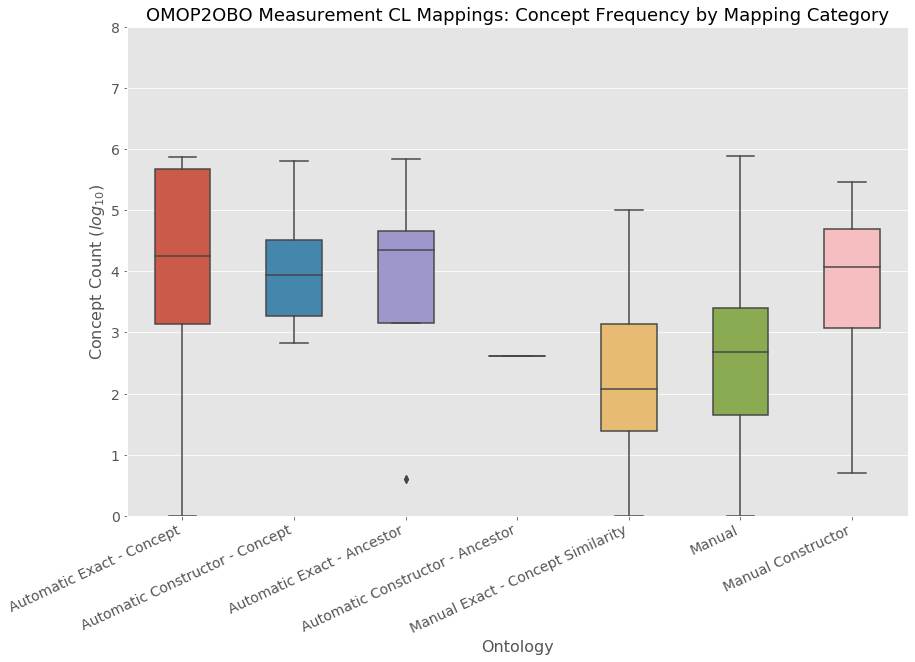

In [273]:
# get log of counts to improve plotting
lab_cl_map_prac_valid['CONCEPT_COUNT_LOG10'] = np.log10(lab_cl_map_prac_valid['CONCEPT_COUNT'])

# set boxplot order
ordering = ['Automatic Exact - Concept', 'Automatic Constructor - Concept',
           'Automatic Exact - Ancestor', 'Automatic Constructor - Ancestor',
           'Manual Exact - Concept Similarity', 'Manual', 'Manual Constructor']

# create box plot
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
sboxplot = sns.boxplot(y='CONCEPT_COUNT_LOG10', x='CATEGORY_MAPPING',
                       data=lab_cl_map_prac_valid, width=0.5, order=ordering)
sboxplot.set_xticklabels(sboxplot.get_xticklabels(), rotation=25, horizontalalignment='right')    
plt.title('OMOP2OBO Measurement CL Mappings: Concept Frequency by Mapping Category', fontsize=18)
plt.suptitle("")
plt.xlabel('Ontology', fontsize=16)
plt.ylabel('Concept Count ($log_{10}$)', fontsize=16)
plt.ylim(0, 8)
plt.tick_params(labelsize=14)

plt.show()

*Mapping Evidence*

In [274]:
# parses evidence
lab_cl_map_evidence = process_mapping_evidence(list(lab_cl_map_prac_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_cl_map_evidence['all']), len(set(lab_cl_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_cl_map_evidence['dbxref']), len(set(lab_cl_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_cl_map_evidence['synonym']),
                                                                                                      len(set(lab_cl_map_evidence['synonym'])),
                                                                                                      len(lab_cl_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_cl_map_evidence['label']), len(set(lab_cl_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_cl_map_evidence['similarity']),
                                                                                         statistics.median(lab_cl_map_evidence['similarity']),
                                                                                         min(lab_cl_map_evidence['similarity']),
                                                                                         max(lab_cl_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 2370 (139 unique) pieces of evidence 
Among the evidence, 261 were from dbXRefs (18 unique) 
Among the evidence, 486 were from synonyms (4 unique), covering 3 OBO synonym types 
Among the evidence, 296 were from labels (1 unique) 
Among the evidence, 296 were from similarity (0.427 median, 0.257 min, 1.0 max)


LOINC2HPO CONCEPTS NOT USED IN PRACTICE

In [275]:
# split data into concept type sets
lab_cl_map_stnd = lab_mapping_cl['LOINC2HPO Concept']['data']

lab_res = lab_cl_map_stnd[lab_cl_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
print('{} LOINC2HPO Concepts Used in practice with at least 1 ontology mapping'.format(len(set(lab_res['CONCEPT_ID']))))
print('{} OMOP Lab Test Results Used in practice with at least 1 ontology mapping'.format(len(lab_res)))

# get counts of ontologies mapped to each OMOP concepts
cl_stnd_concept_coverage = [x for y in lab_res['CATEGORY_URI'] for x in y.split(' | ')]
concept_coverage = len(cl_stnd_concept_coverage)/len(lab_res)

print('{} ontology concepts were mapped to {} OMOP concepts ({} ontology concepts/OMOP vocabulary concept)'.format(len(lab_res),
                                                                                                                  len(cl_stnd_concept_coverage),
                                                                                                                  round(concept_coverage, 3)))

152 LOINC2HPO Concepts Used in practice with at least 1 ontology mapping
429 OMOP Lab Test Results Used in practice with at least 1 ontology mapping
429 ontology concepts were mapped to 474 OMOP concepts (1.105 ontology concepts/OMOP vocabulary concept)


*Mapping Categories*

In [276]:
# mapping category
cl_lab_stnd_map_categories = lab_cl_map_stnd.groupby(['CATEGORY_MAPPING']).size().to_dict()

# get unmapped types
lab_cl_map_stnd_unmapped = lab_cl_map_stnd[lab_cl_map_stnd['CATEGORY_MAPPING'] =='Unmapped']
lab_cl_map_stnd_unmapped_types = lab_cl_map_stnd_unmapped.groupby(['CATEGORY_URI']).size().to_dict()

map1 = 'Counts by Mapping Category:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in cl_lab_stnd_map_categories.items()]))
map2 = '\n\nUnmapped reasons:\n{}'.format('\n'.join(['  - ' + k + ' (n=' + str(v) + ')' for k,v in lab_cl_map_stnd_unmapped_types.items()]))

print(map1, map2)

Counts by Mapping Category:
  - Automatic Constructor - Concept (n=24)
  - Automatic Exact - Concept (n=186)
  - Manual (n=178)
  - Manual Constructor (n=21)
  - Manual Exact - Concept Similarity (n=20)
  - Unmapped (n=6387) 

Unmapped reasons:
  - NONE (n=6372)
  - NOT MAPPED TEST TYPE (n=1)
  - UNSPECIFIED SAMPLE (n=14)


*Mapping Evidence*


In [277]:
# parses evidence
lab_cl_map_stnd_valid = lab_cl_map_stnd[lab_cl_map_stnd['CATEGORY_MAPPING'] !='Unmapped']
lab_cl_map_evidence = process_mapping_evidence(list(lab_cl_map_stnd_valid['CATEGORY_EVIDENCE']))

# print values
ev1 = 'The valid mappings had {} ({} unique) pieces of evidence'.format(len(lab_cl_map_evidence['all']), len(set(lab_cl_map_evidence['all'])))
ev2 = '\nAmong the evidence, {} were from dbXRefs ({} unique)'.format(len(lab_cl_map_evidence['dbxref']), len(set(lab_cl_map_evidence['dbxref'])))
ev3 = '\nAmong the evidence, {} were from synonyms ({} unique), covering {} OBO synonym types'.format(len(lab_cl_map_evidence['synonym']),
                                                                                                      len(set(lab_cl_map_evidence['synonym'])),
                                                                                                      len(lab_cl_map_evidence['synonym_type']))
ev4 = '\nAmong the evidence, {} were from labels ({} unique)'.format(len(lab_cl_map_evidence['label']), len(set(lab_cl_map_evidence['label'])))

ev5 = '\nAmong the evidence, {} were from similarity ({} median, {} min, {} max)'.format(len(lab_cl_map_evidence['similarity']),
                                                                                         statistics.median(lab_cl_map_evidence['similarity']),
                                                                                         min(lab_cl_map_evidence['similarity']),
                                                                                         max(lab_cl_map_evidence['similarity']))

print(ev1, ev2, ev3, ev4, ev5)

The valid mappings had 1781 (107 unique) pieces of evidence 
Among the evidence, 145 were from dbXRefs (8 unique) 
Among the evidence, 413 were from synonyms (4 unique), covering 3 OBO synonym types 
Among the evidence, 226 were from labels (1 unique) 
Among the evidence, 232 were from similarity (0.435 median, 0.258 min, 1.0 max)


***
**Click [here](#lab-mapping-results) to return to the Lab Mapping Results section**  
**Click [here](#mapping-results) to return to the Mapping Results section**  
**Click [here](#toc) to return to the Table of Contents**
***

<br>

***
***

This project is licensed under MIT - see the **[`LICENSE.md`](https://github.com/callahantiff/OMOP2OBO/blob/master/LICENSE)** file for details. If you intend to use any of the information on this Wiki, please provide the appropriate attribution by citing this repository:  

```
@misc{callahan_tj_2020_4247939,
  author       = {Callahan, TJ},
  title        = {OMOP2OBO},
  month        = jun,
  year         = 2021,
  doi          = {10.5281/zenodo.4247939},
  url          = {https://doi.org/10.5281/zenodo.4247939}
}
```